# R Destiny
## Xiaonan Wang
## 08Jun2020

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import os
import smqpp
import re
import anndata
from mpl_toolkits.mplot3d import Axes3D

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
cdict = {'red': ((0.0, 0.0, 0.0),
                 (0.1, 0.5, 0.5),
                 (0.2, 0.0, 0.0),
                 (0.4, 0.2, 0.2),
                 (0.6, 0.0, 0.0),
                 (0.8, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green':((0.0, 0.0, 0.0),
                 (0.1, 0.0, 0.0),
                 (0.2, 0.0, 0.0),
                 (0.4, 1.0, 1.0),
                 (0.6, 1.0, 1.0),
                 (0.8, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
        'blue': ((0.0, 0.0, 0.0),
                 (0.1, 0.5, 0.5),
                 (0.2, 1.0, 1.0),
                 (0.4, 1.0, 1.0),
                 (0.6, 0.0, 0.0),
                 (0.8, 0.0, 0.0),
                 (1.0, 0.0, 0.0))}

def plot_3d(adata_ref, obs_key, adata_new=None, obsm_key='X_diffmap', ncols=4,figsize=(6,6), alpha=0.5, azim=250,elev=30, markersize=1,components=[1,2,3], cmap=None):
    nkey = len(obs_key)
    if nkey <=4:
        ncols = nkey
    nrows = int(np.ceil((nkey)/ncols))
    fig = plt.figure(figsize=figsize)
    for nk in range(nkey):
        k = obs_key[nk]
        ax = fig.add_subplot(nrows, ncols, nk+1, projection='3d')
        ax.view_init(azim=azim, elev=elev)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        if adata_new is None:
            adata = adata_ref.copy()
        else:
            adata = adata_new.copy()
            dm_ref = adata_ref.obsm[obsm_key]
            ax.plot(dm_ref[:,components[0]],dm_ref[:,components[1]],dm_ref[:,components[2]], '.', markersize=markersize, c='#d3d3d3', label = 'Ref_data', alpha =alpha)

        dm_new = adata.obsm[obsm_key]
        obs_term = adata.obs[k]
        if obs_term.dtype == 'float' or obs_term.dtype == int:
            if cmap is None:
                cmap = LinearSegmentedColormap('my_colormap',cdict,256) 
            #print(np.array(obs_term.values))
            conti_fig = ax.scatter(dm_new[:,components[0]],dm_new[:,components[1]],dm_new[:,components[2]], '.', s=markersize, c=np.array(obs_term.values), cmap=cmap, alpha =alpha)
            fig.colorbar(conti_fig, shrink=0.5)
            
        
        else:
            obs_term = obs_term.astype('category')
            cats = obs_term.cat.categories
            if k+'_colors' in adata.uns_keys():
                color_pal = adata.uns[k+'_colors']
            else:
                color_pal = sc.pl.palettes.default_20[0:len(cats)]
            for i in range(len(cats)):
                #print(cats[i])
                idx = obs_term==cats[i]
                ax.plot(dm_new[idx,components[0]],dm_new[idx,components[1]],dm_new[idx,components[2]], '.', markersize=markersize, c=color_pal[i], label = cats[i], alpha =alpha)

            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()

In [27]:
wdir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Carys/'

# DPT in R

In [28]:
MPB_raw = sc.read(wdir+'MPB1234/write/MPB1234_raw.h5ad')
MPB_raw.var_names_make_unique()
print('MPB shape: '+ str(MPB_raw.shape))
BM_raw = sc.read(wdir+'BM789/write/BM789_raw.h5ad')
BM_raw.var_names_make_unique()
print('BM shape: '+ str(BM_raw.shape))
CB_raw = sc.read(wdir+'MPB1234/write/CBdata_raw.h5ad')
CB_raw.var_names_make_unique()
print('CB shape: '+ str(CB_raw.shape))

MPB shape: (1512, 65988)
BM shape: (634, 65988)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CB shape: (535, 65988)


In [29]:
CB_raw.obs['Batch'] = CB_raw.obs['batch']

In [30]:
adata = CB_raw.concatenate(MPB_raw, BM_raw)

filtered out 13661 genes that are detected in less than 1 cells
Calculate SF for genes:
Filtered matrix shape: (2681, 17)
Number of valid means:17
MeanForFit:  5
11662
Length of HVGs: 3479


... storing 'Batch' as categorical
... storing 'CI_annotation_of_index' as categorical
... storing 'CRI_identifier' as categorical
... storing 'CRI_run' as categorical
... storing 'Cell_Type' as categorical
... storing 'Cell_type_general' as categorical
... storing 'Cell_type_subtype' as categorical
... storing 'ClusterCol' as categorical
... storing 'Condition' as categorical
... storing 'Day' as categorical
... storing 'Details' as categorical
... storing 'FACs_index_data' as categorical
... storing 'FSC.A' as categorical
... storing 'FSC.W' as categorical
... storing 'Gottgens_ID_RBGxxx' as categorical
... storing 'Index' as categorical
... storing 'Index_name_in_library_Set' as categorical
... storing 'Owner' as categorical
... storing 'Plate' as categorical
... storing 'Plate_number' as categorical
... storing 'Position_in_96_well_plate_RNA.seq' as categorical
... storing 'Position_in_96_well_plate_RNA_seq' as categorical
... storing 'SSC.A' as categorical
... storing 'Sample_ID' 

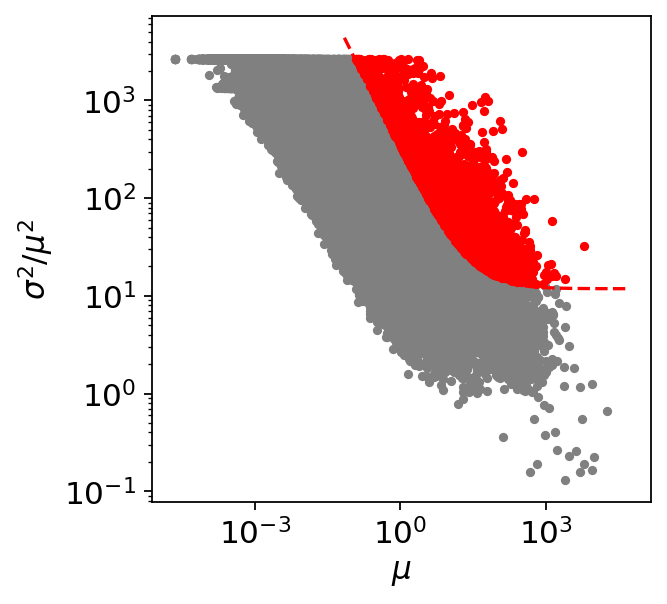

In [31]:
sc.pp.filter_genes(adata, min_cells=1)
adata.var_names_make_unique()
# normalisation
smqpp.normalise_data(adata)
adata.raw = adata
smqpp.tech_var(adata, useERCC=False, meanForFit=5) 
smqpp.plot_tech_var(adata)
adata.write('./write/CB_MPB_BM_lognorm.h5ad')

In [32]:
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)

In [33]:
sc.pp.combat(adata, key='Batch')

Standardizing Data across genes.

Found 9 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



In [34]:
adata.obs_names= [x[:-2] for x in adata.obs_names]

In [35]:
adata.write('./write/combat_R/CB_MPB_BM_lognorm_combatBC_original.h5ad')

# Destiny R

In [44]:
adata =sc.read('./write/combat_R/CB_MPB_BM_lognorm_combatBC.h5ad') 

In [45]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [46]:
CB_bcD = adata[adata.obs['batch'] == '0', ].X.toarray()
MPB_bcD = adata[adata.obs['batch'] == '1', ].X.toarray()
BM_bcD = adata[adata.obs['batch'] == '2', ].X.toarray()

In [4]:
%reload_ext rpy2.ipython

In [7]:
%%R -i CB_bcD -i MPB_bcD -i BM_bcD
suppressMessages(library(destiny))
print("Calculating Diffusion Map CB")
dm_CB = DiffusionMap(CB_bcD, distance="cosine")
saveRDS(dm_CB, file="dm_CB.rds")
print("Calculating Projection MPB")
MPB_proj = dm_predict(dm_CB, MPB_bcD)
saveRDS(MPB_proj, file="MPB_proj.rds")
print("Calculating Projection BM")
BM_proj = dm_predict(dm_CB, BM_bcD)
saveRDS(BM_proj, file="BM_proj.rds")
write.table(dm_CB@eigenvectors, "X_DM_CB.csv", quote=F, row.names=T, col.names=T, sep=",")
write.table(as.matrix(MPB_proj), "X_DM_MPB.csv", quote=F, row.names=T, col.names=T, sep=",")
write.table(as.matrix(BM_proj), "X_DM_BM.csv", quote=F, row.names=T, col.names=T, sep=",")

print("Calculating Diffusion Map all")
dm_all = DiffusionMap(rbind(CB_bcD, MPB_bcD, BM_bcD), distance="cosine")
saveRDS(dm_all, file="dm_all.rds")
write.table(dm_all@eigenvectors, "X_DM_R.csv", quote=F, row.names=T, col.names=T, sep=",")

[1] "Calculating Diffusion Map all"


### Plot all

In [26]:
adata =sc.read('./write/combat_R/CB_MPB_BM_lognorm_combatBC.h5ad') 

In [10]:
DM_co = pd.read_csv('X_DM_R.csv', index_col=0, header=0)

In [11]:
adata.obsm['X_diffmap'] = np.array(DM_co)

In [72]:
CBdata = adata[adata.obs['batch'] == '0'].copy()
CBdata.obs = CB_raw.obs
MPBdata = adata[adata.obs['batch'] == '1'].copy()
MPBdata.obs = MPB_raw.obs
BMdata = adata[adata.obs['batch'] == '2'].copy()
BMdata.obs = BM_raw.obs

In [73]:
CBdata.obsm['X_diffmap'] = np.array(DM_co.iloc[0:535,:])
MPBdata.obsm['X_diffmap'] = np.array(DM_co.iloc[535:2047,:])
BMdata.obsm['X_diffmap'] = np.array(DM_co.iloc[2047:2681,:])

In [73]:
CBdata.write('./write/combat_R/CBdata_combat.h5ad')
MPBdata.write('./write/combat_R/MPBdata_combat.h5ad')
BMdata.write('./write/combat_R/BMdata_combat.h5ad')
adata.write('./write/combat_R/CB_MPB_BM_lognorm_combatBC.h5ad') 

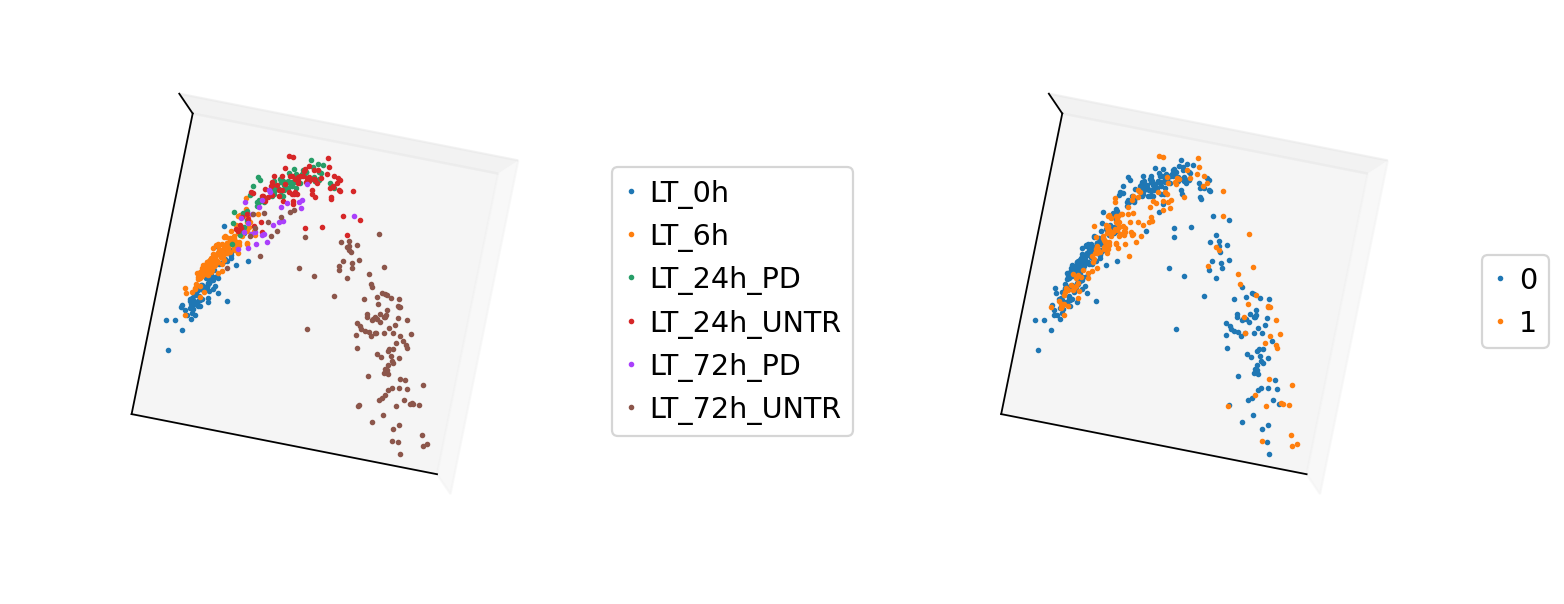

In [74]:
plot_3d(CBdata, ['Details', 'batch'], figsize=(10,4), azim=100,elev=90, components=[0,1,2], alpha=1, markersize=3) #100,90

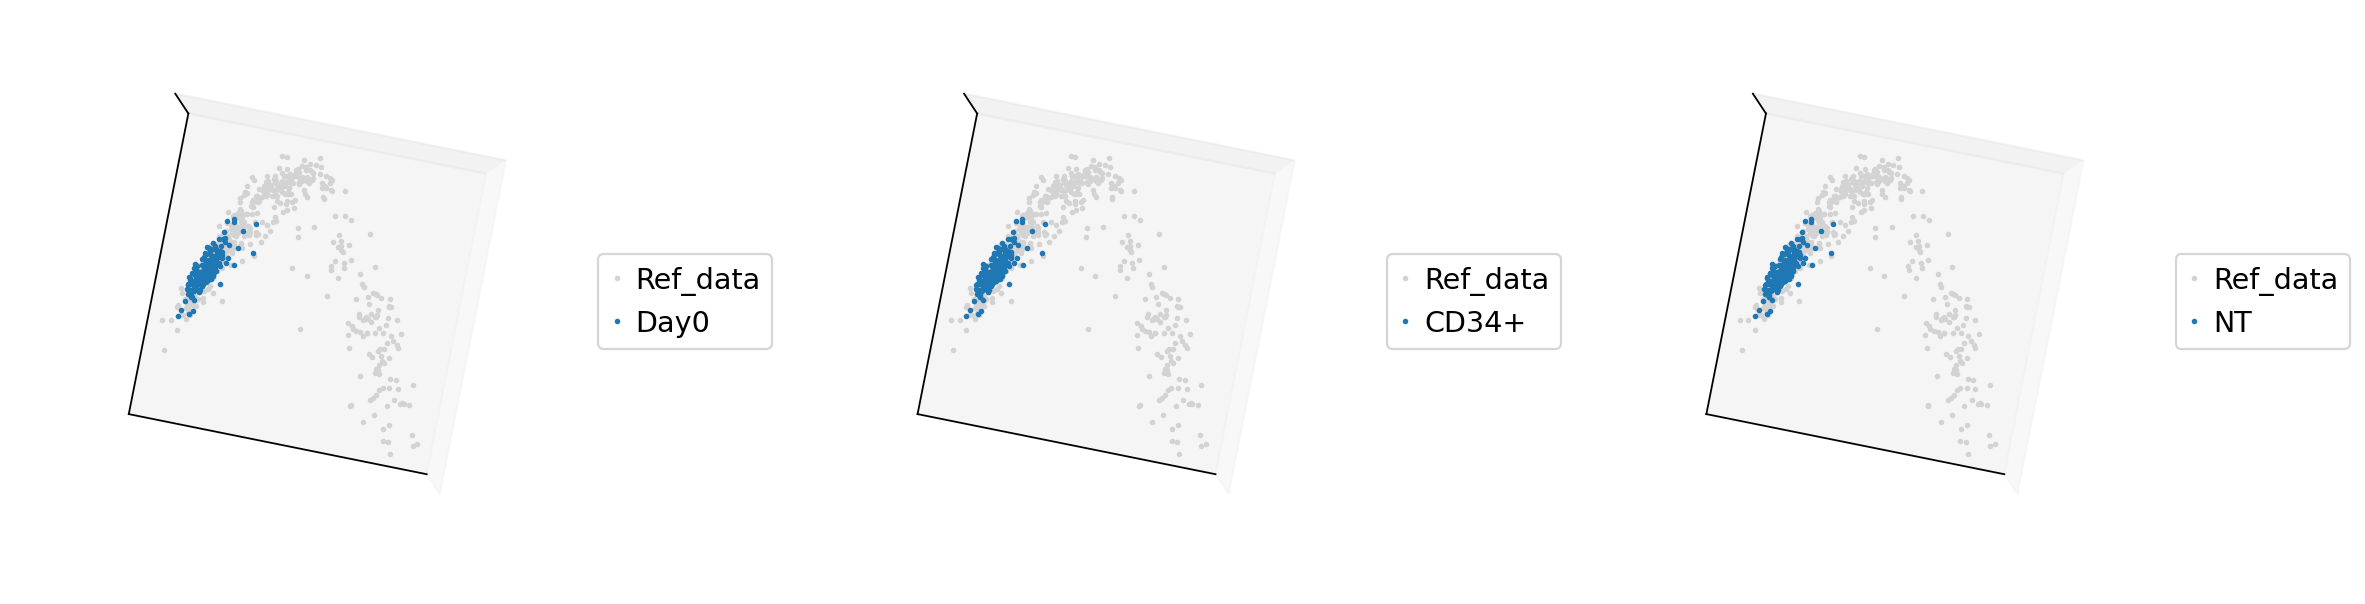

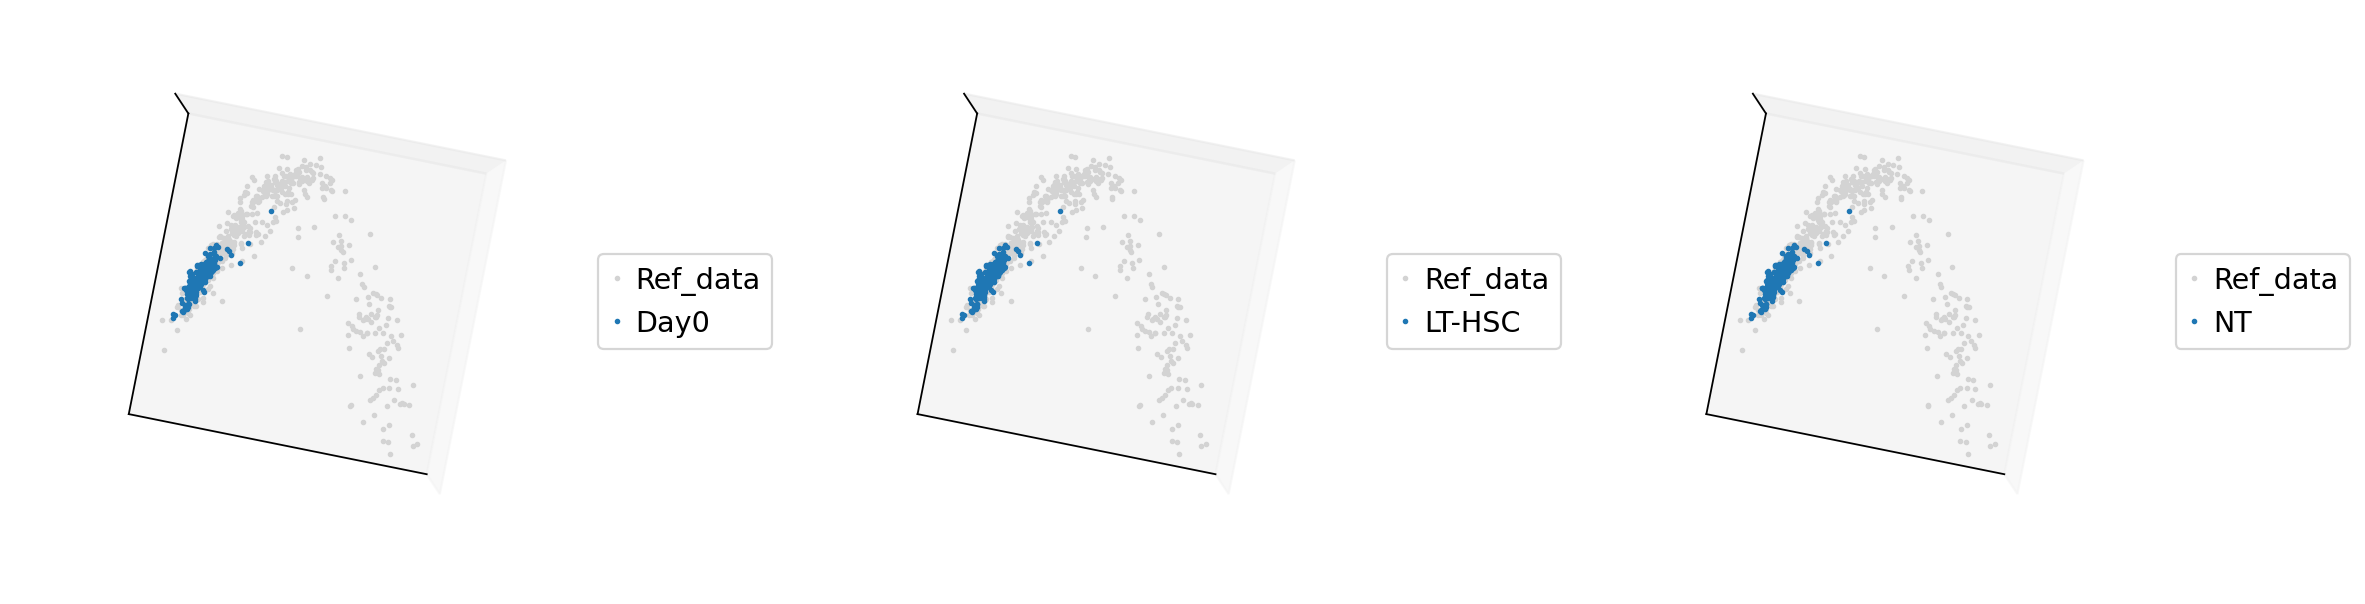

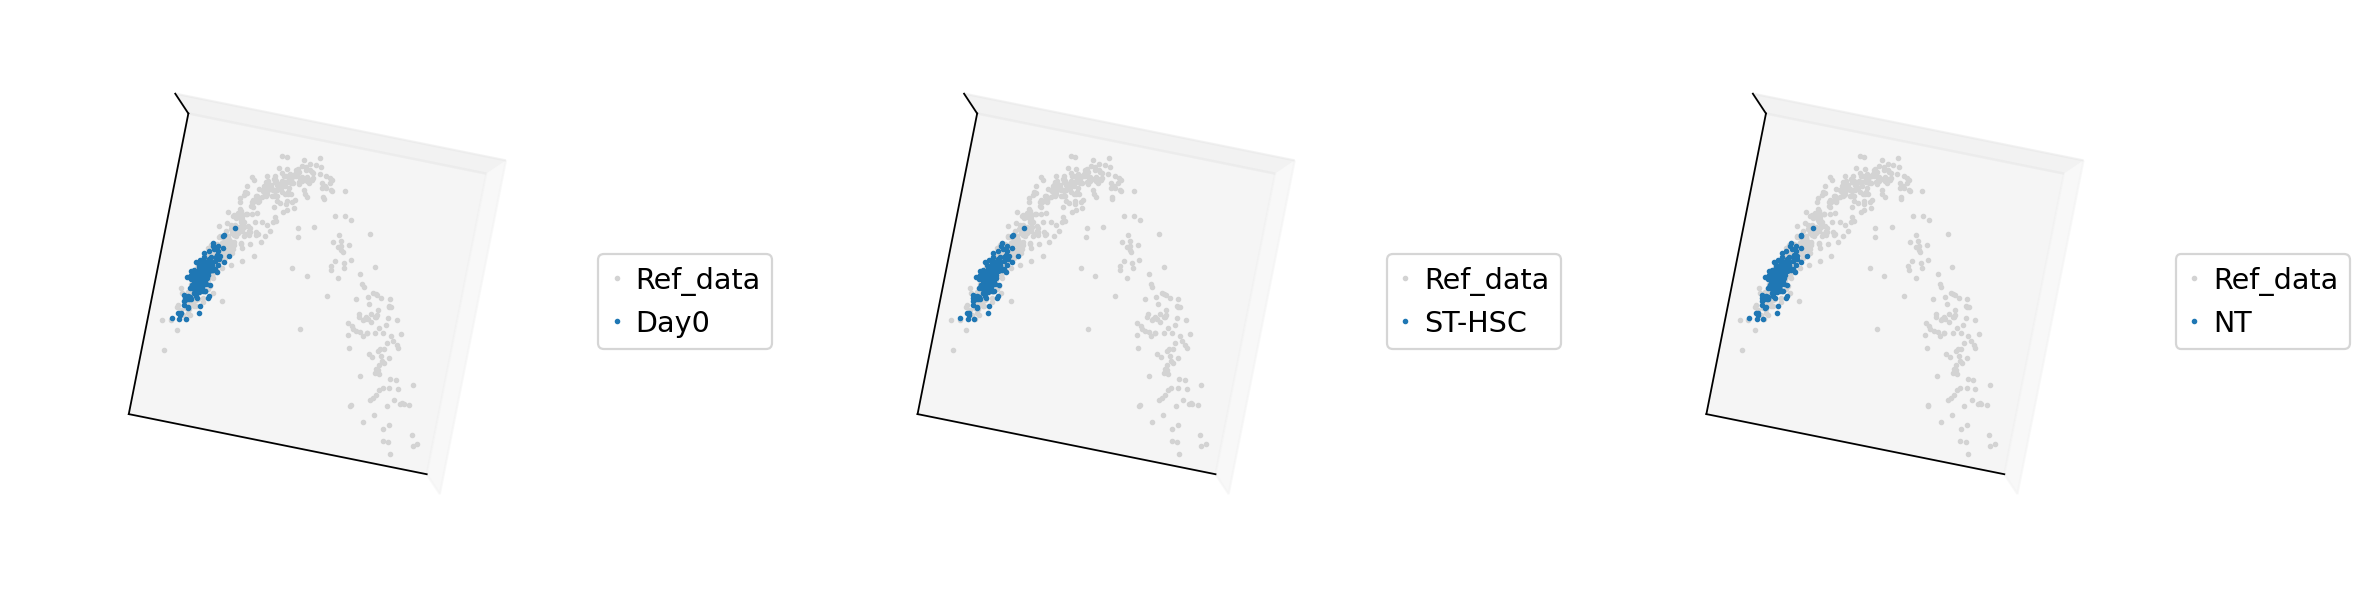

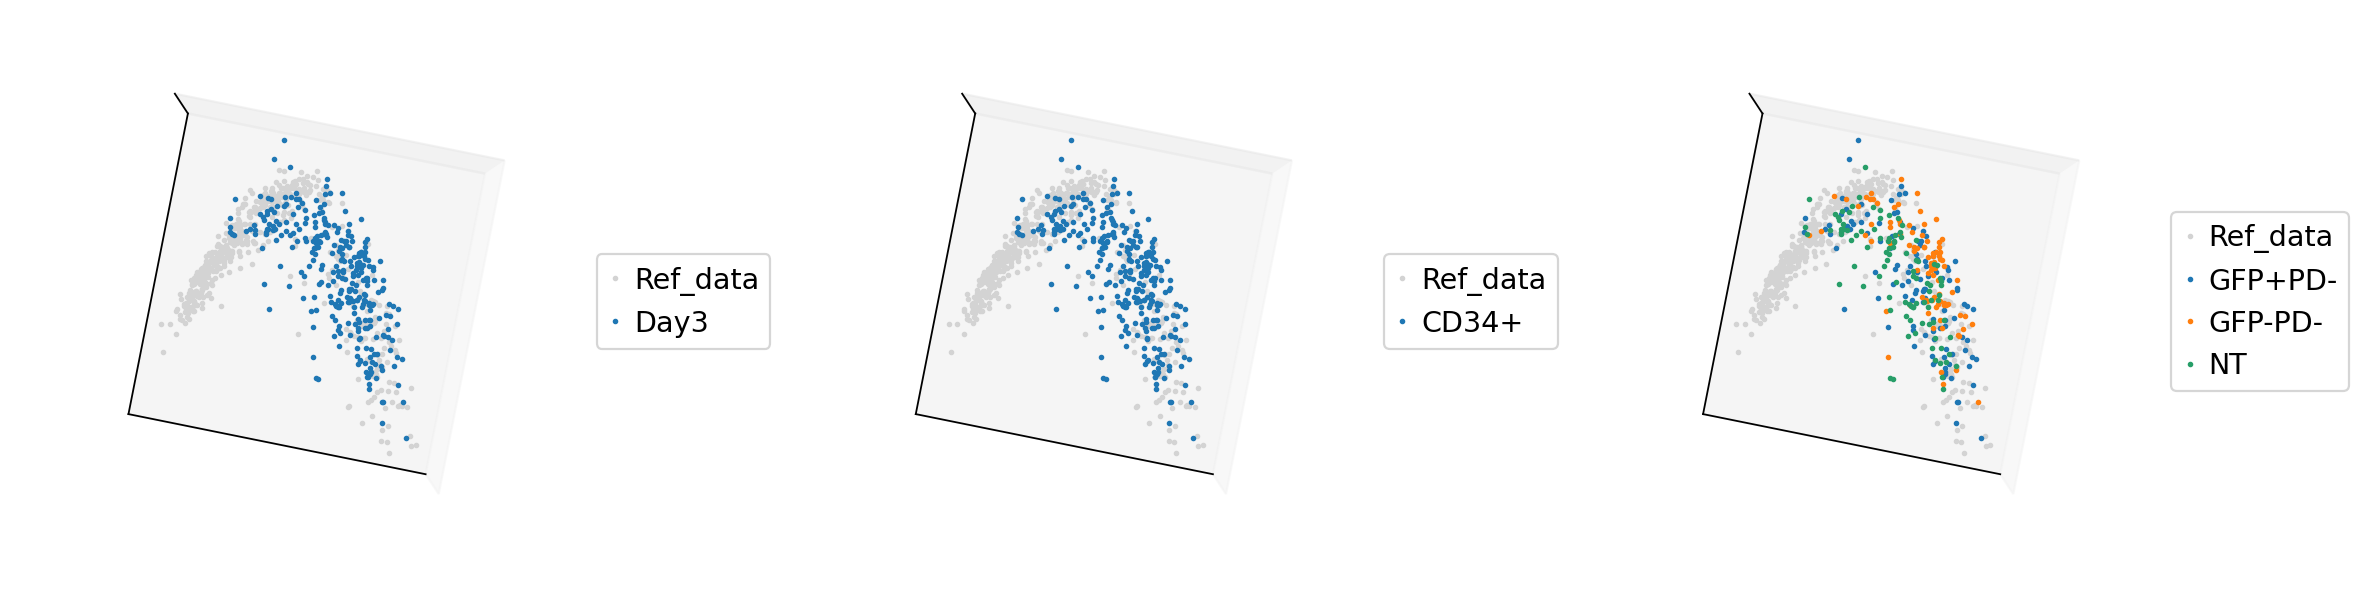

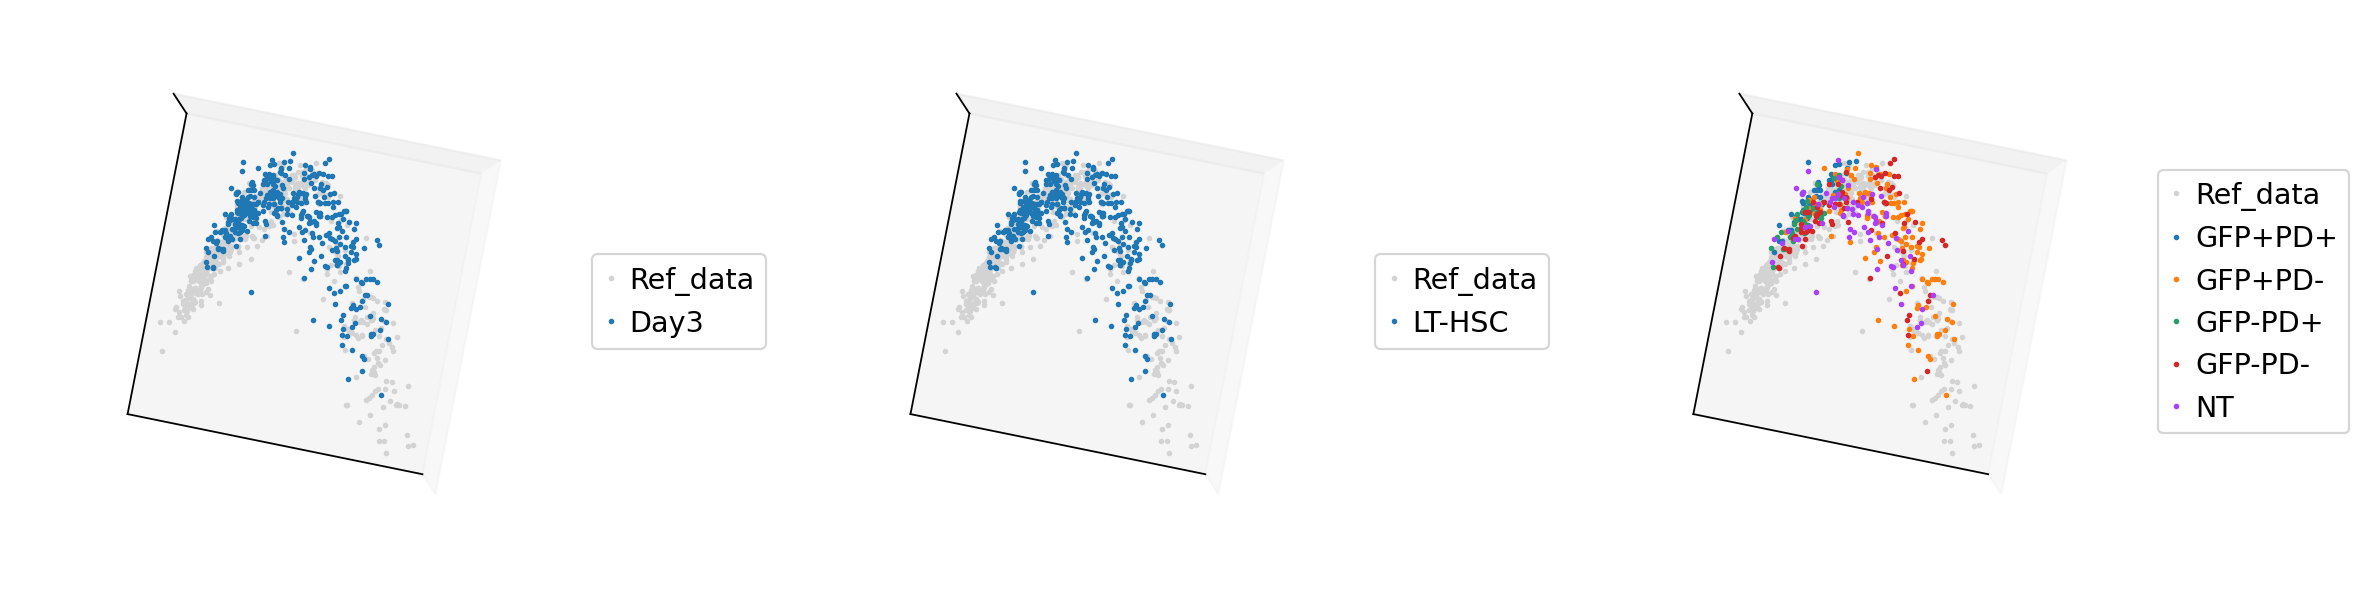

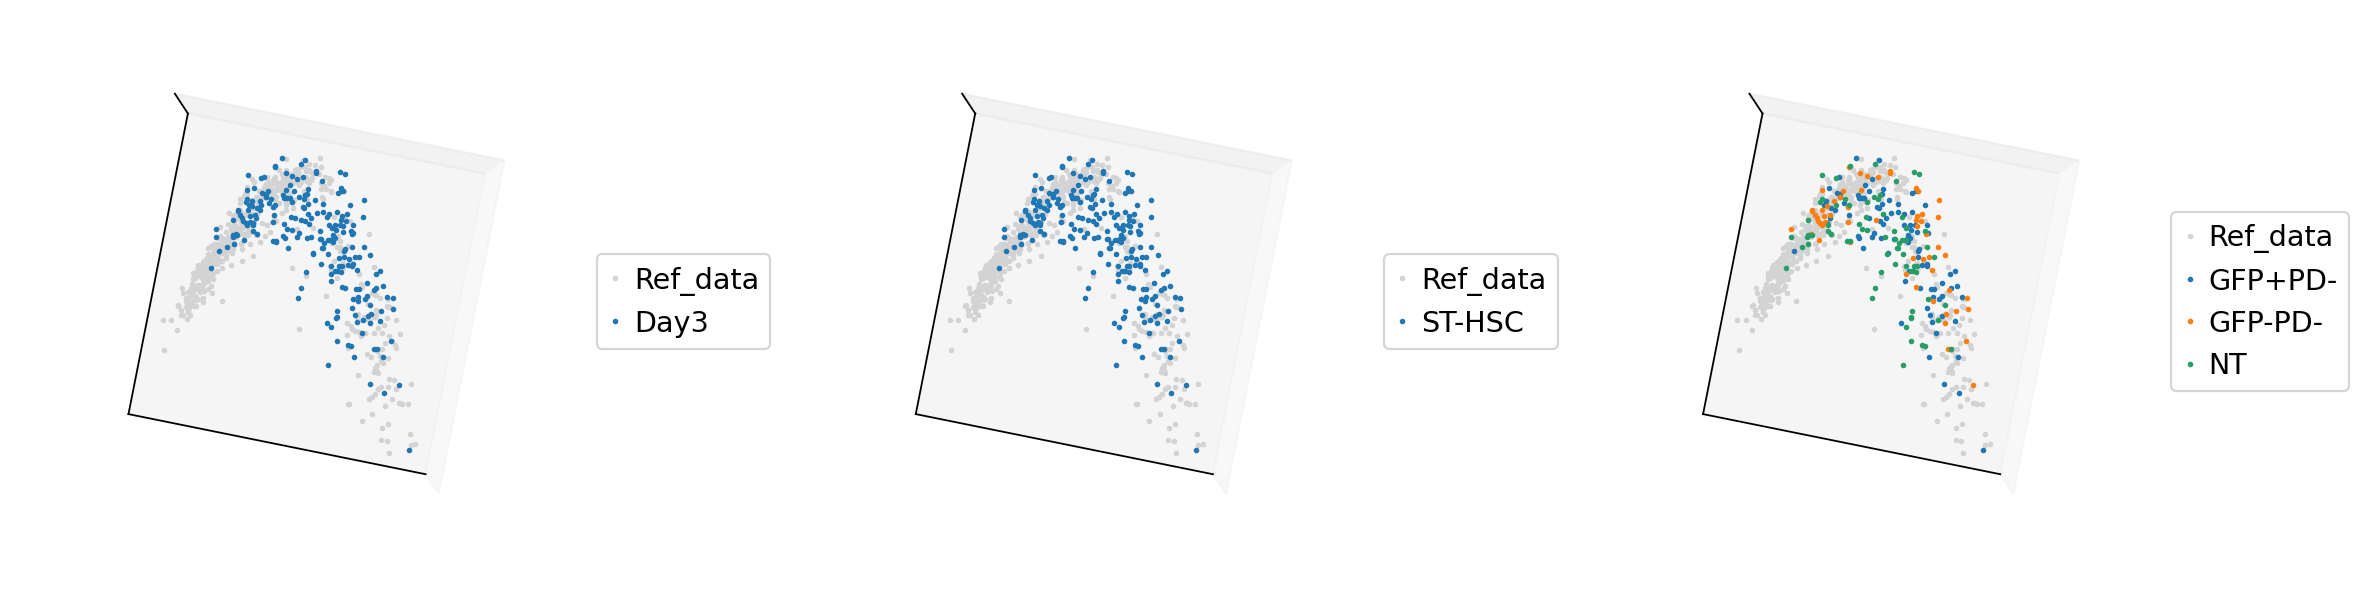

In [75]:
for i in np.unique(MPBdata.obs['Day']):
    for j in np.unique(MPBdata.obs['Cell_Type']):
        plot_3d(CBdata, ['Day', 'Cell_Type', 'Condition'], MPBdata[((MPBdata.obs['Day'] == i) & (MPBdata.obs['Cell_Type'] == j))], figsize=(15,4), azim=100,elev=90, components=[0,1,2], alpha=1, markersize=3)

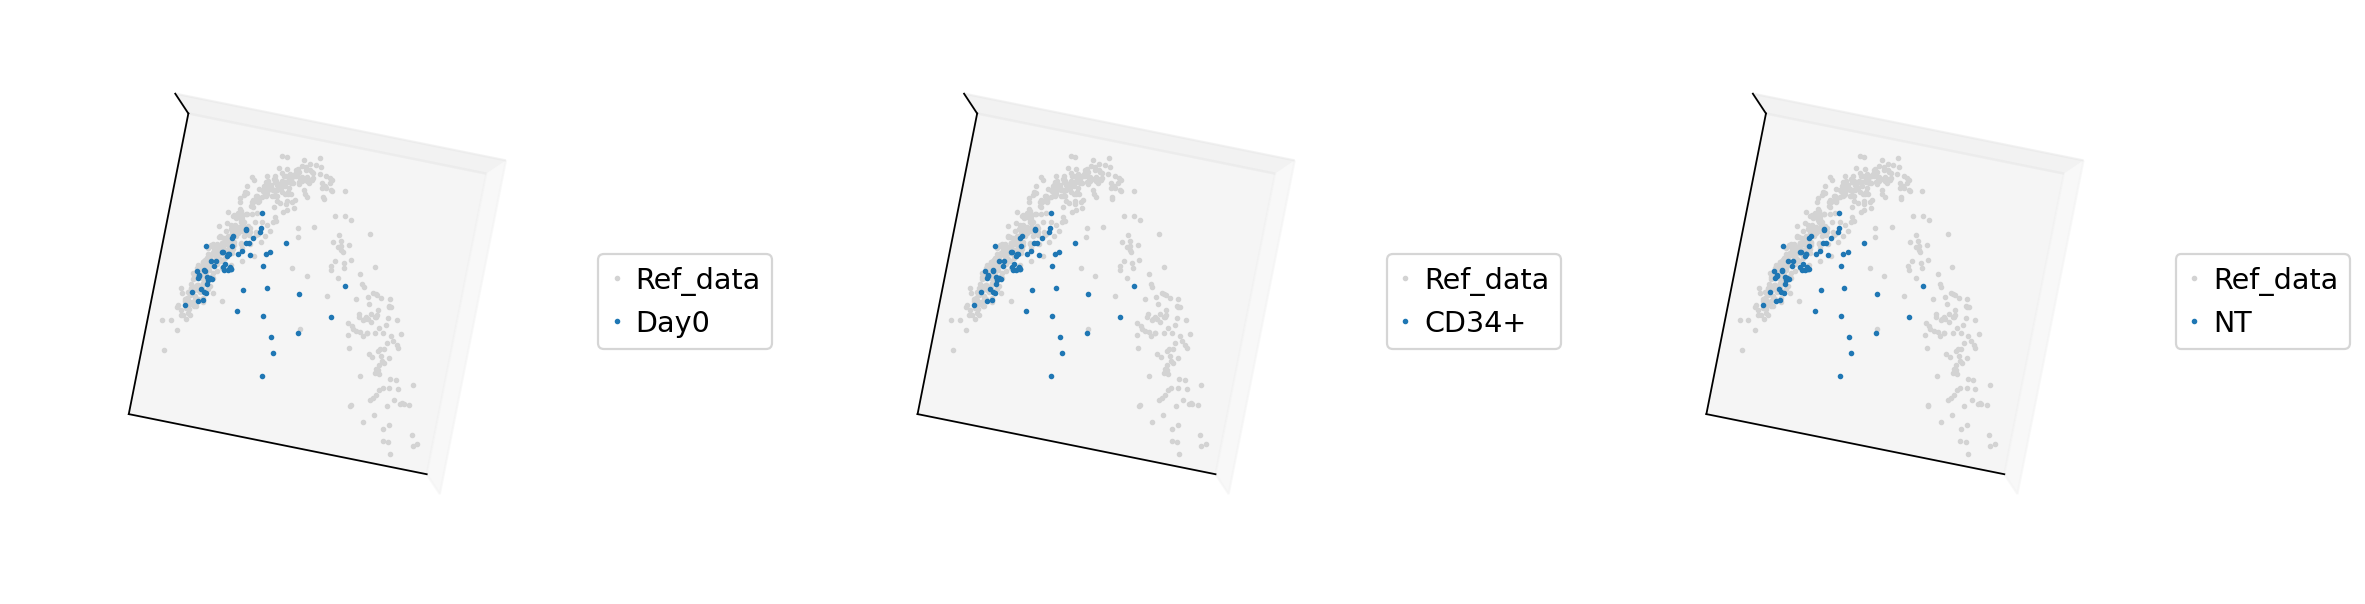

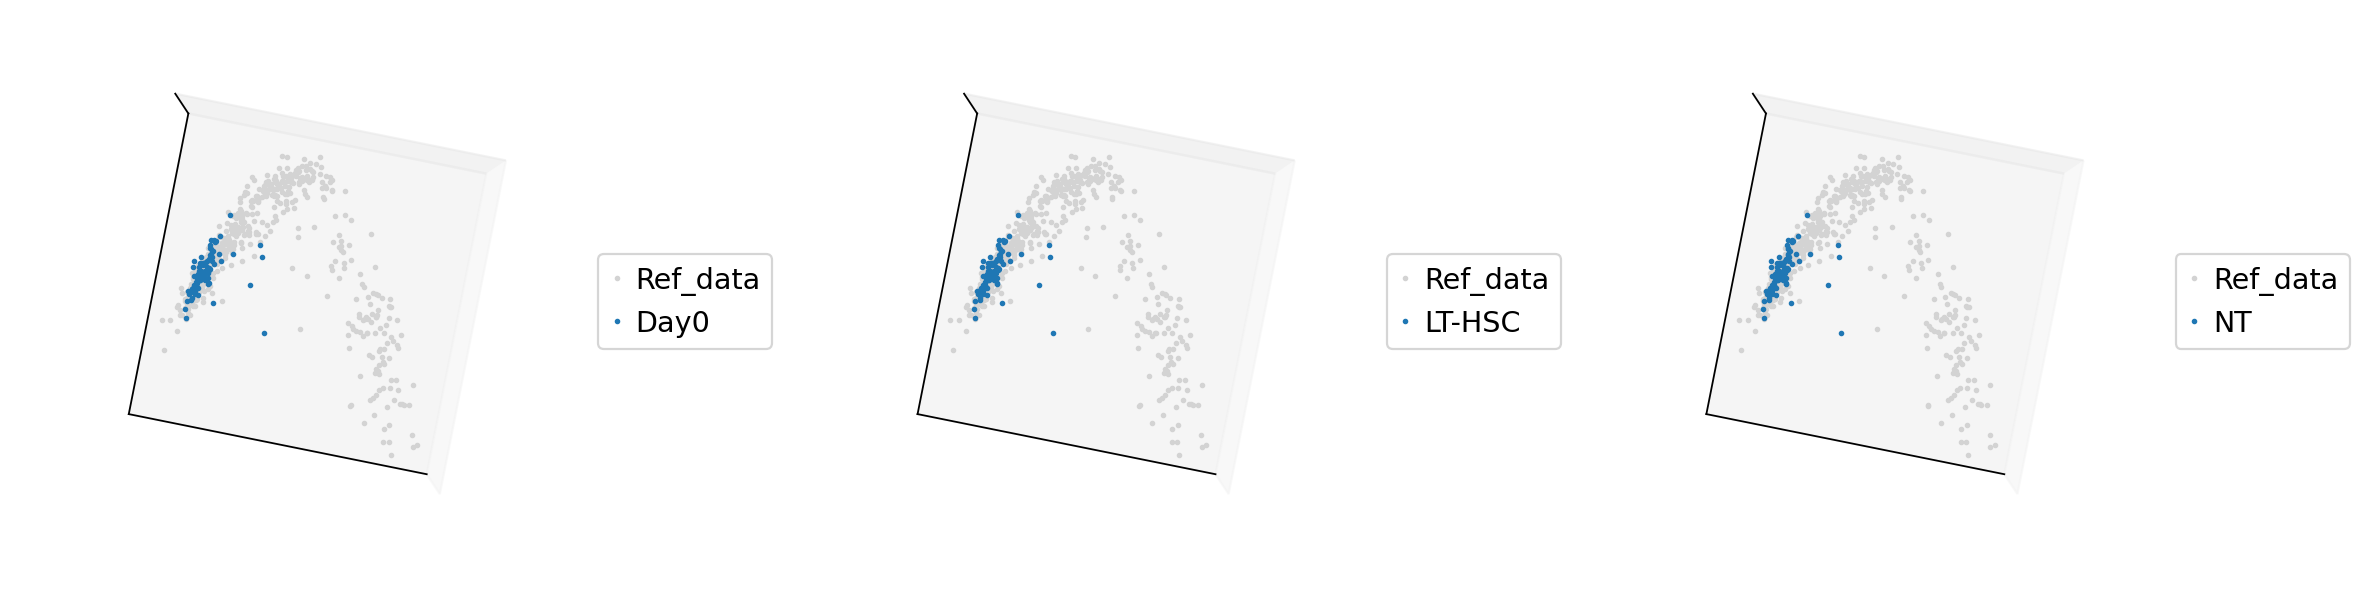

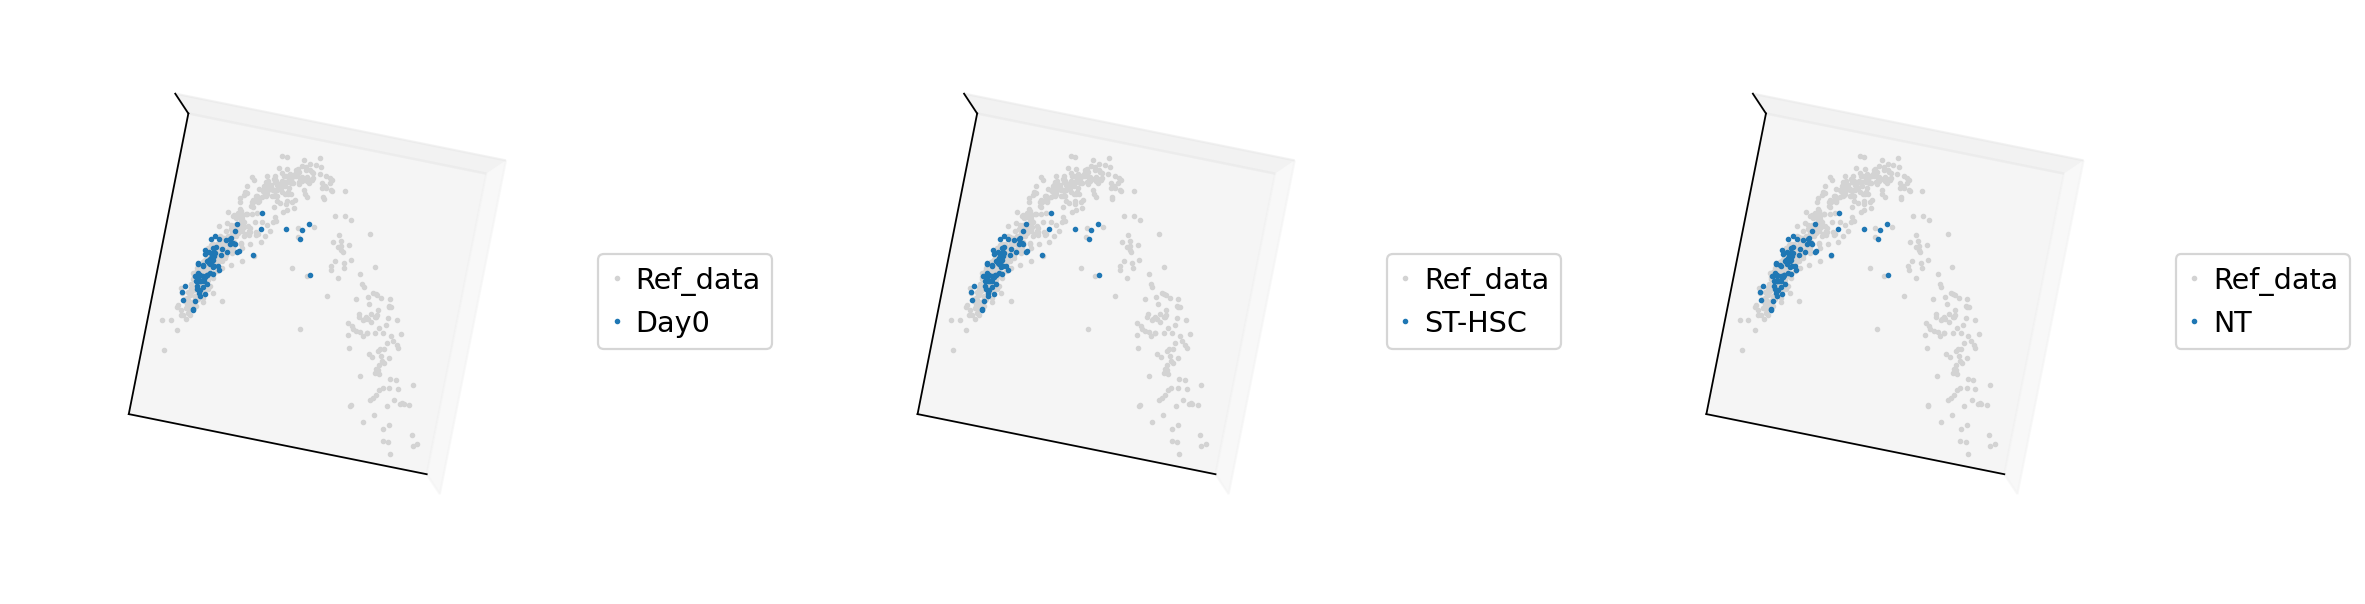

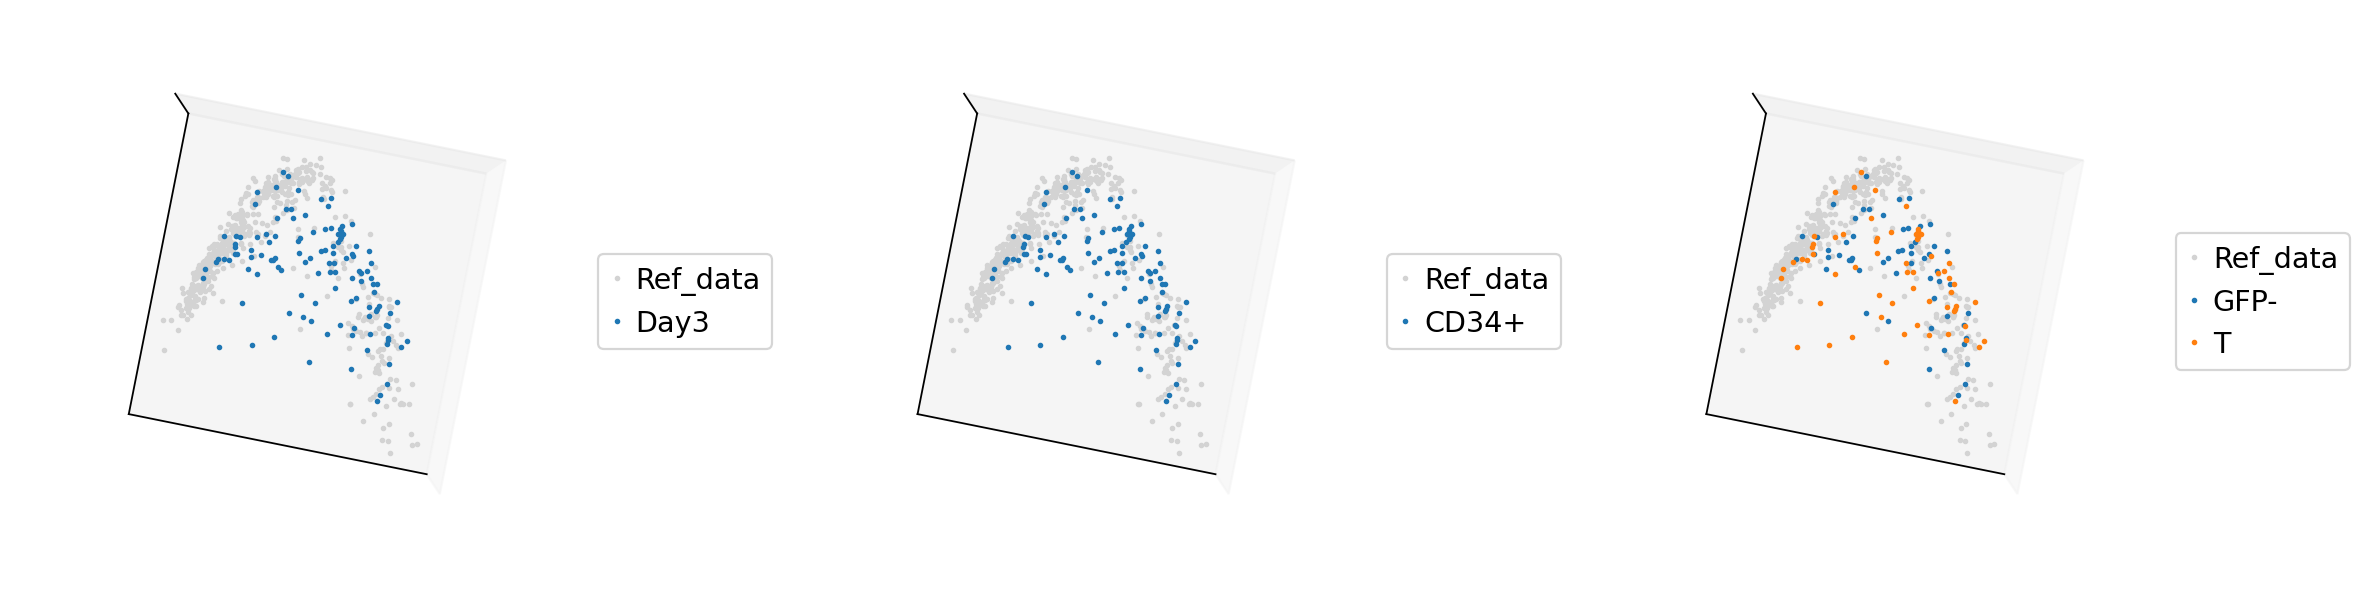

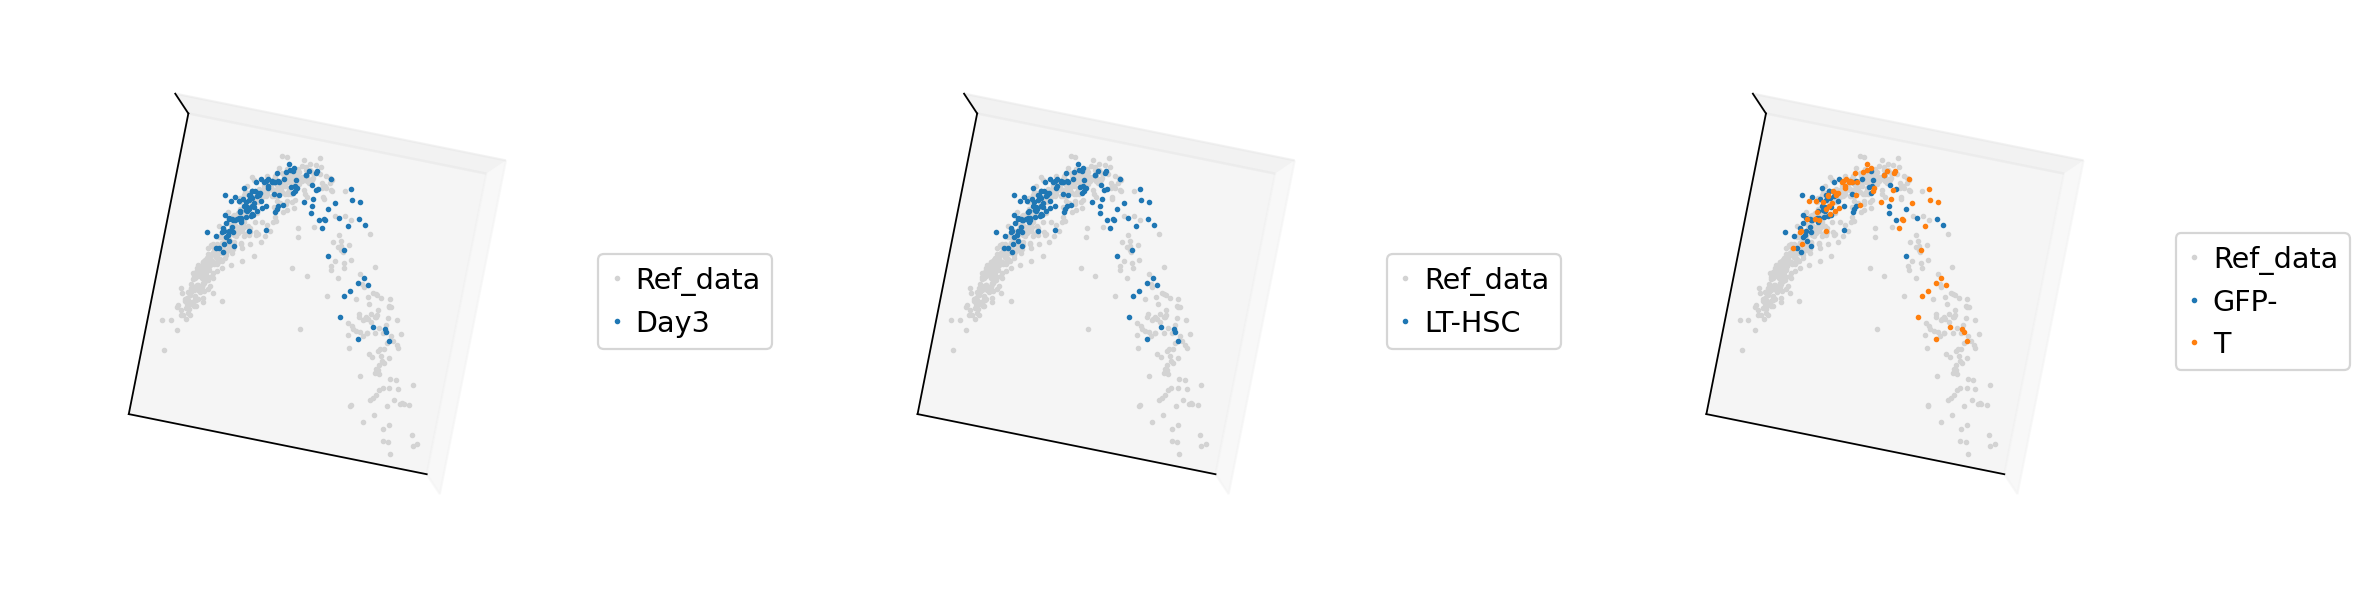

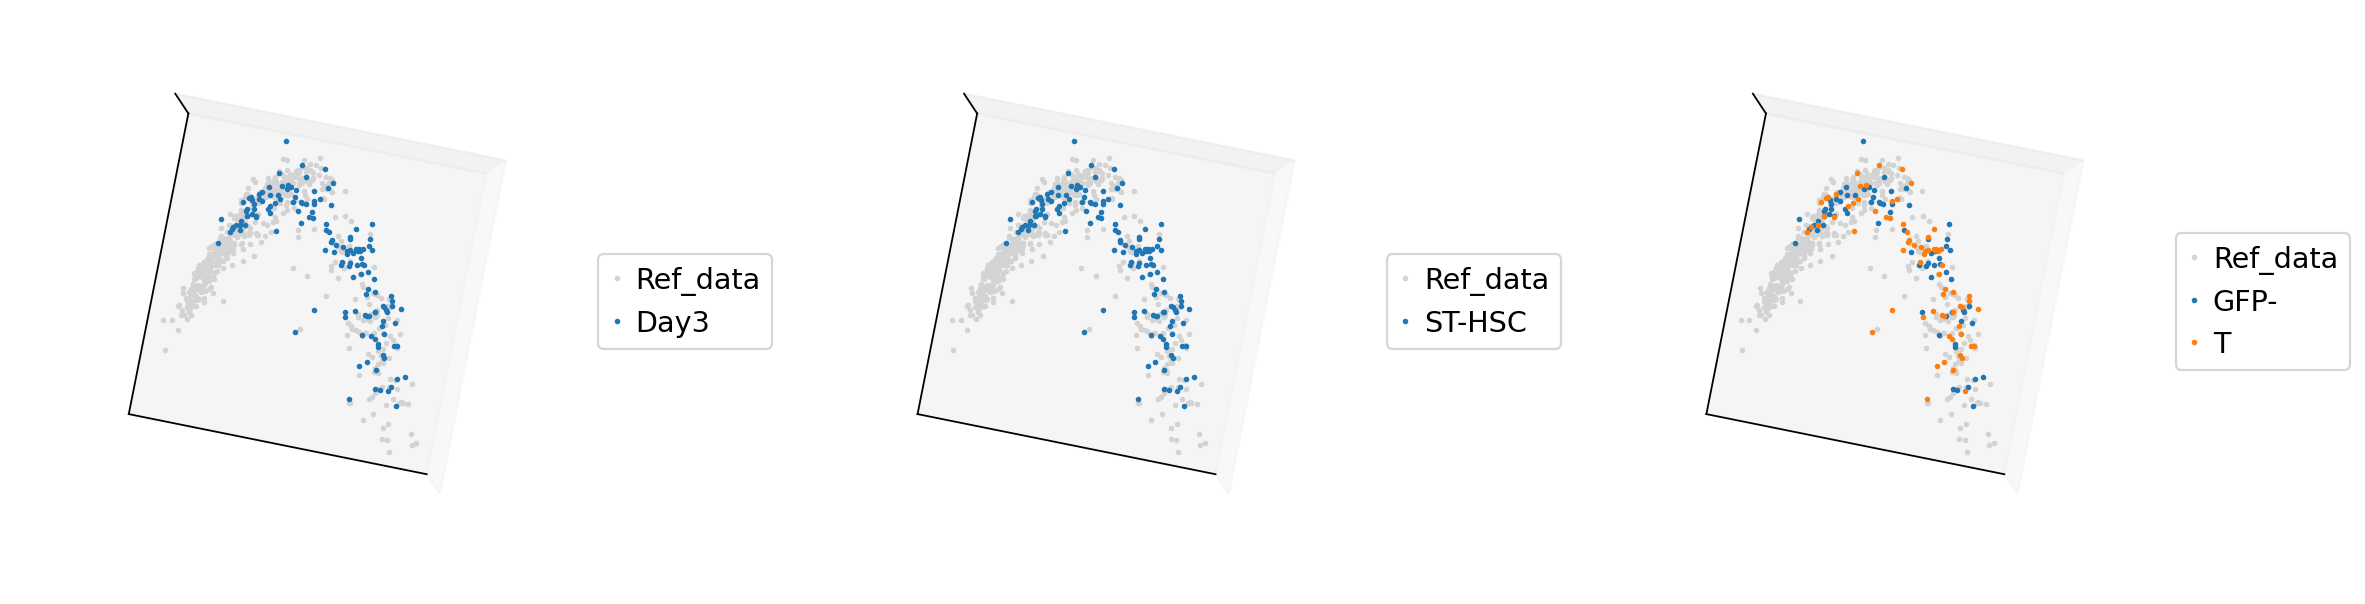

In [76]:
for i in np.unique(BMdata.obs['Day']):
    for j in np.unique(BMdata.obs['Cell_Type']):
        plot_3d(CBdata, ['Day', 'Cell_Type', 'Condition'], BMdata[((BMdata.obs['Day'] == i) & (BMdata.obs['Cell_Type'] == j))], figsize=(15,4), azim=100,elev=90, components=[0,1,2], alpha=1,markersize=3)

## PT calculation

In [6]:
%reload_ext rpy2.ipython

In [7]:
%%R
suppressMessages(library(destiny))
dm_all = readRDS('dm_all.rds')
dpt_all = DPT(dm_all)
saveRDS(dpt_all, file="dpt_all.rds")

In [79]:
adata = sc.read('./write/CB_MPB_BM_lognorm_combatBC.h5ad') 

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [50]:
%%R
print(which(dpt_all@tips[,1] == TRUE))

[1]    7  476 1516


In [92]:
adata.obs_names[[6,475, 1515]]

Index(['SLX.16064.i709_i502', 'SLX.12563.N702_S505', 'SLX.17056.i711_i503'], dtype='object')

In [93]:
adata.obs['iroot_kenny'] = np.in1d(adata.obs_names,'SLX.12561.N702_S502')
adata.obs['iroot_destiny'] = np.in1d(adata.obs_names,'SLX.16064.i709_i502')

In [68]:
adata.uns['iroot_kenny_colors'] = ['#d3d3d3', '#8B0000']
adata.uns['iroot_destiny_colors'] = ['#d3d3d3', '#8B0000']

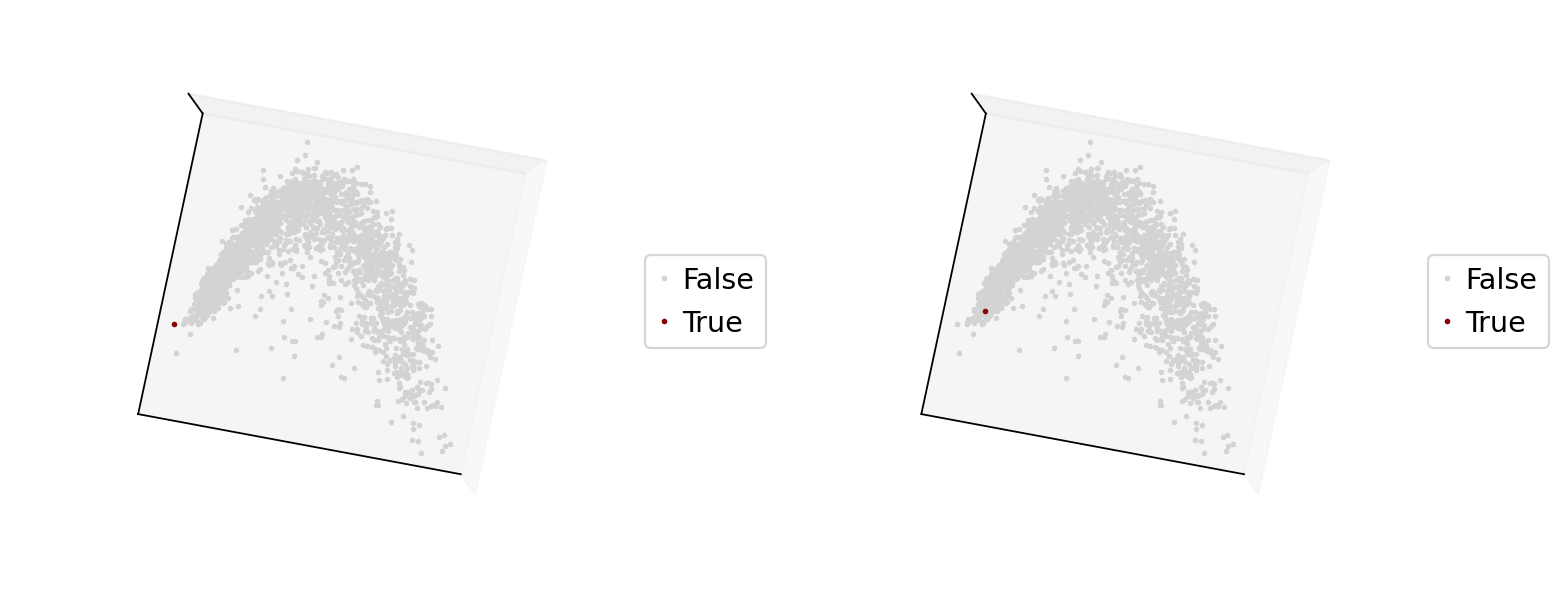

In [71]:
plot_3d(adata, ['iroot_destiny', 'iroot_kenny'], figsize=(10,4), azim=100,elev=90, components=[0,1,2], alpha=1, markersize=3) #100,90

In [64]:
np.where(adata.obs['iroot_kenny']==True)

(array([364]),)

In [94]:
adata.uns['iroot'] = 364

Calculate DPT based on iroot_kenny

In [96]:
%%R -o pt_kenny
suppressMessages(library(destiny))
dm_all = readRDS('dm_all.rds')
dpt_kenny = DPT(dm_all, tips=as.integer(365))
saveRDS(dpt_kenny, file="dpt_kenny.rds")
dpt_flat <-  branch_divide(dpt_kenny, integer(0L))
pt_kenny <- destiny:::dpt_for_branch(dpt_flat, 1)

In [98]:
adata.obs['destiny_pt_kenny'] = pt_kenny

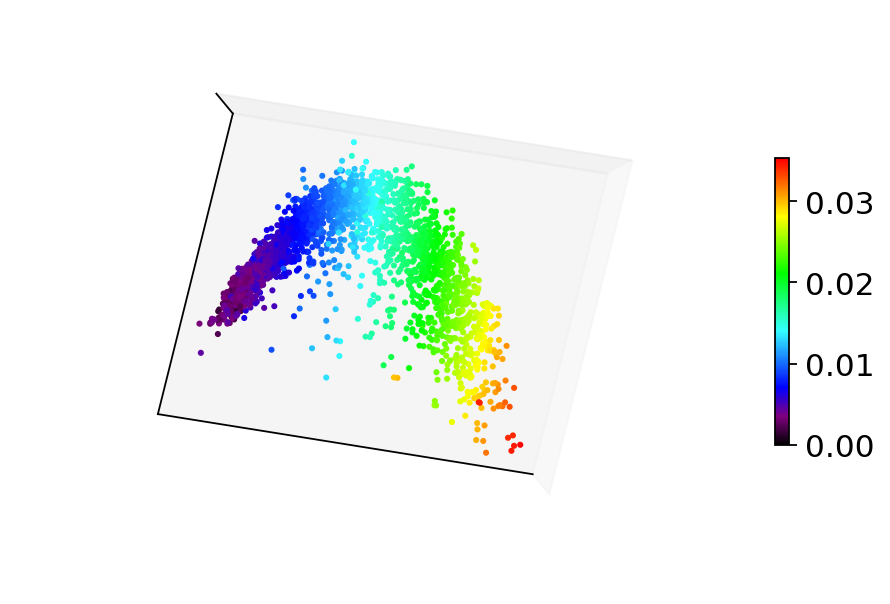

In [72]:
plot_3d(adata, ['destiny_pt_kenny'], figsize=(6,4), azim=100,elev=90, components=[0,1,2], alpha=1, markersize=3) #100,90

In [107]:
CBdata.obs['destiny_pt_kenny'] = adata[CBdata.obs_names].obs['destiny_pt_kenny']
MPBdata.obs['destiny_pt_kenny'] = adata[MPBdata.obs_names].obs['destiny_pt_kenny']
BMdata.obs['destiny_pt_kenny'] = adata[BMdata.obs_names].obs['destiny_pt_kenny']

In [99]:
adata.write('./write/combat_R/CB_MPB_BM_lognorm_combatBC.h5ad') 

In [4]:
adata = sc.read('./write/combat_R/CB_MPB_BM_lognorm_combatBC.h5ad') 

In [108]:
CB_con = CB_raw.obs['Details']
MPB_con = MPB_raw.obs['Day'].astype(str)+'_'+MPB_raw.obs['Cell_Type'].astype(str)+'_'+MPB_raw.obs['Condition'].astype(str)
MPBdata.obs['cond_comb'] = MPB_con
BM_con = BM_raw.obs['Day'].astype(str)+'_'+BM_raw.obs['Cell_Type'].astype(str)+'_'+BM_raw.obs['Condition'].astype(str)
BMdata.obs['cond_comb'] = BM_con
cond_comb = np.concatenate([['CB_'+x for x in CB_con],['MPB_'+x for x in MPB_con], ['BM_'+x for x in BM_con]])
adata.obs['cond_comb'] = cond_comb

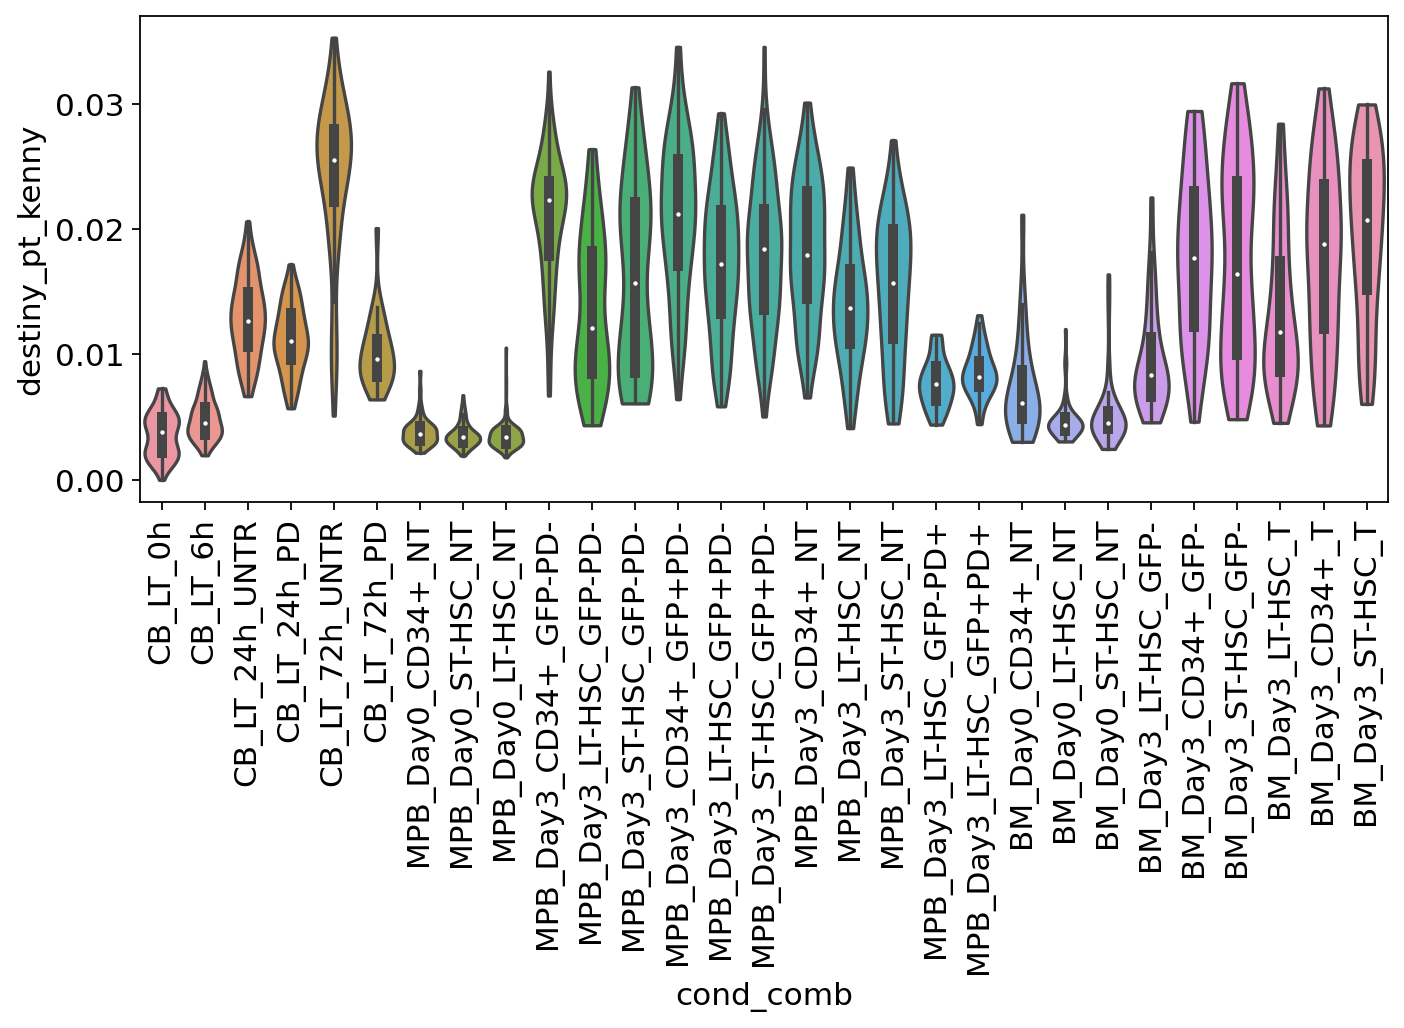

In [101]:
import seaborn as sns
ax, fig = plt.subplots(figsize=(10,4))
ax = sns.violinplot(x='cond_comb', y='destiny_pt_kenny',data=adata.obs, scale='width', cut=0)
ax.grid(False)
ax.tick_params(axis='x',labelrotation=90)

In [109]:
CB_con = CB_raw.obs['Details']
MPB_con = MPB_raw.obs['Day'].astype(str)+'_'+MPB_raw.obs['Cell_Type'].astype(str)
MPBdata.obs['cond_comb1'] = MPB_con
BM_con = BM_raw.obs['Day'].astype(str)+'_'+BM_raw.obs['Cell_Type'].astype(str)
BMdata.obs['cond_comb1'] = BM_con
cond_comb = np.concatenate([['CB_'+x for x in CB_con],['MPB_'+x for x in MPB_con], ['BM_'+x for x in BM_con]])
adata.obs['cond_comb1'] = cond_comb

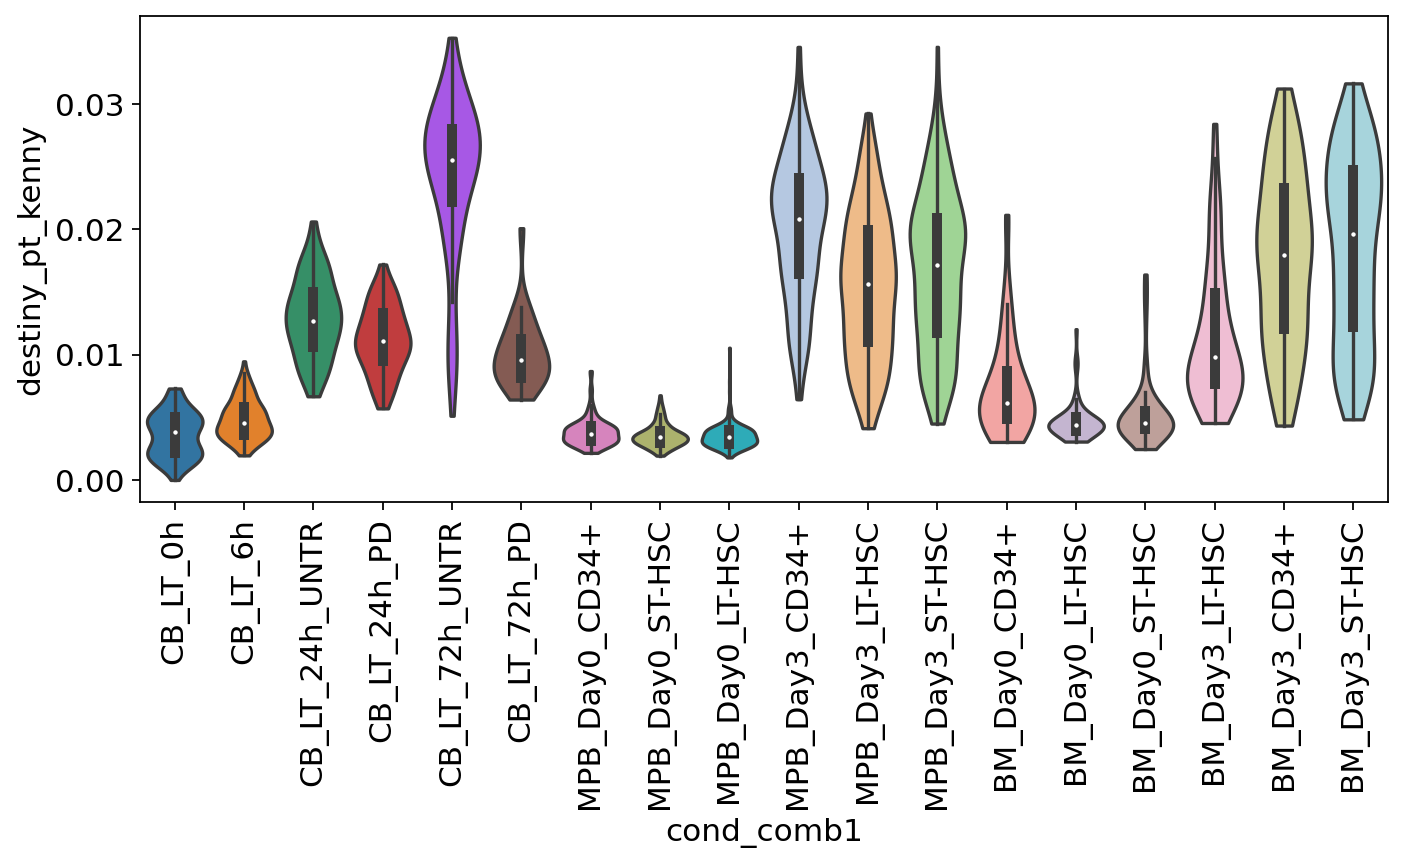

In [103]:
import seaborn as sns
ax, fig = plt.subplots(figsize=(10,4))
ax = sns.violinplot(x='cond_comb1', y='destiny_pt_kenny',data=adata[['PD+' not in x for x in adata.obs['Condition']]].obs, scale='width', cut=0)
ax.grid(False)
ax.tick_params(axis='x',labelrotation=90)

In [110]:
adata.write('./write/combat_R/CB_MPB_BM_lognorm_combatBC.h5ad') 
CBdata.write('./write/combat_R/CBdata_combat.h5ad')
MPBdata.write('./write/combat_R/MPBdata_combat.h5ad')
BMdata.write('./write/combat_R/BMdata_combat.h5ad')

... storing 'cond_comb' as categorical
... storing 'cond_comb1' as categorical
... storing 'cond_comb' as categorical
... storing 'cond_comb1' as categorical
... storing 'cond_comb' as categorical
... storing 'cond_comb1' as categorical


In [36]:
CBdata = sc.read('./write/combat_R/CBdata_combat.h5ad')
MPBdata = sc.read('./write/combat_R/MPBdata_combat.h5ad')
BMdata = sc.read('./write/combat_R/BMdata_combat.h5ad')
adata = sc.read('./write/combat_R/CB_MPB_BM_lognorm_combatBC.h5ad') 

MPB data

Day0_CD34+


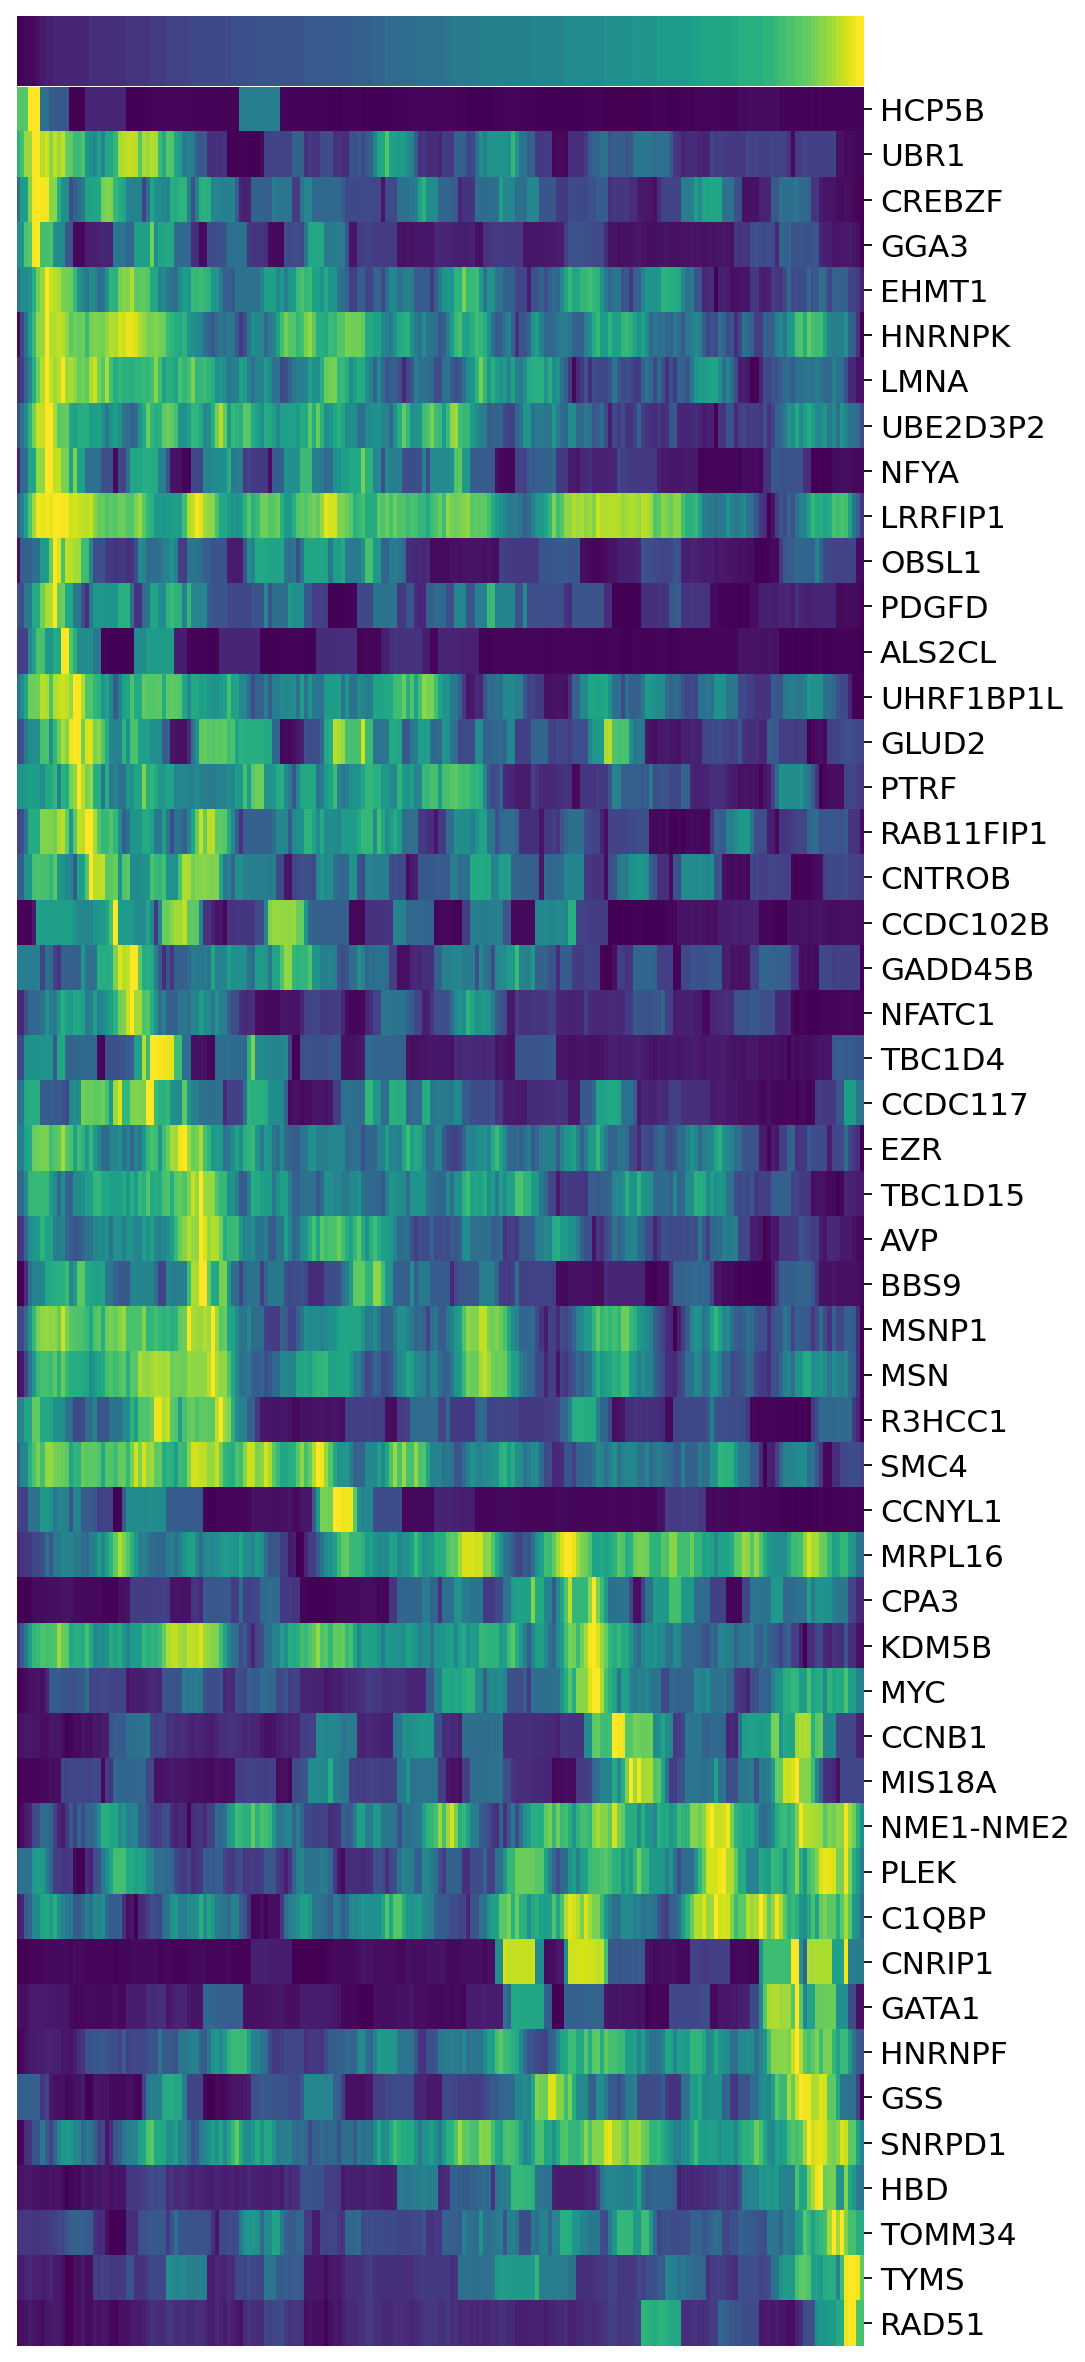

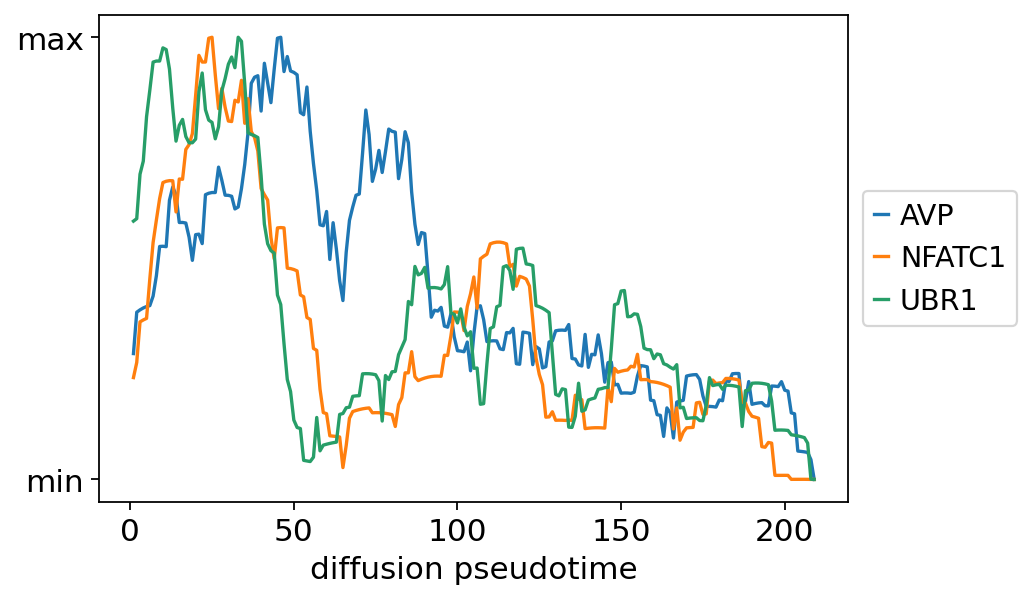

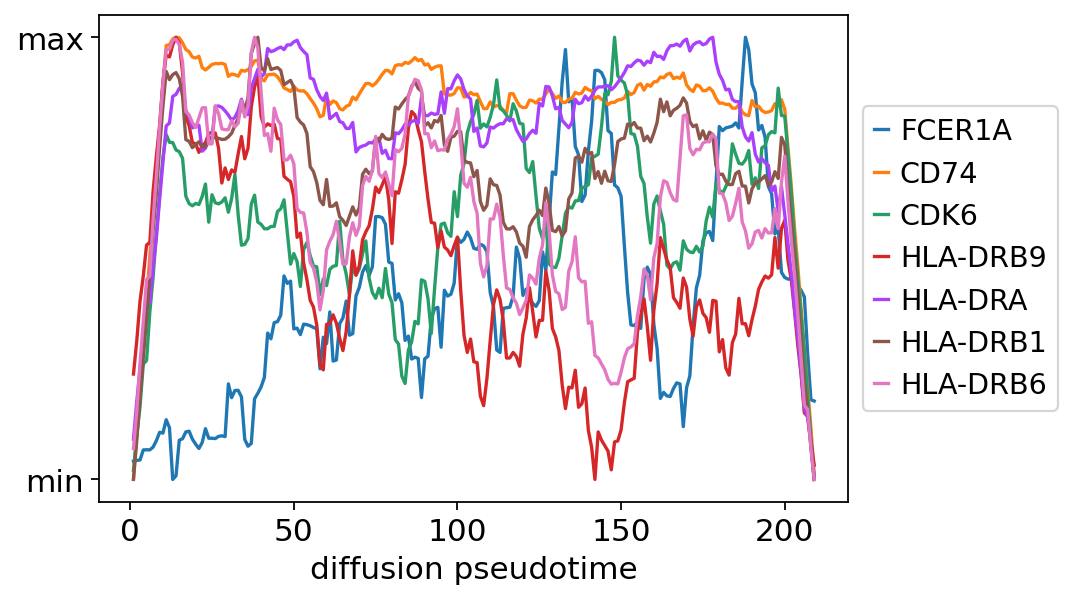

Day0_LT-HSC


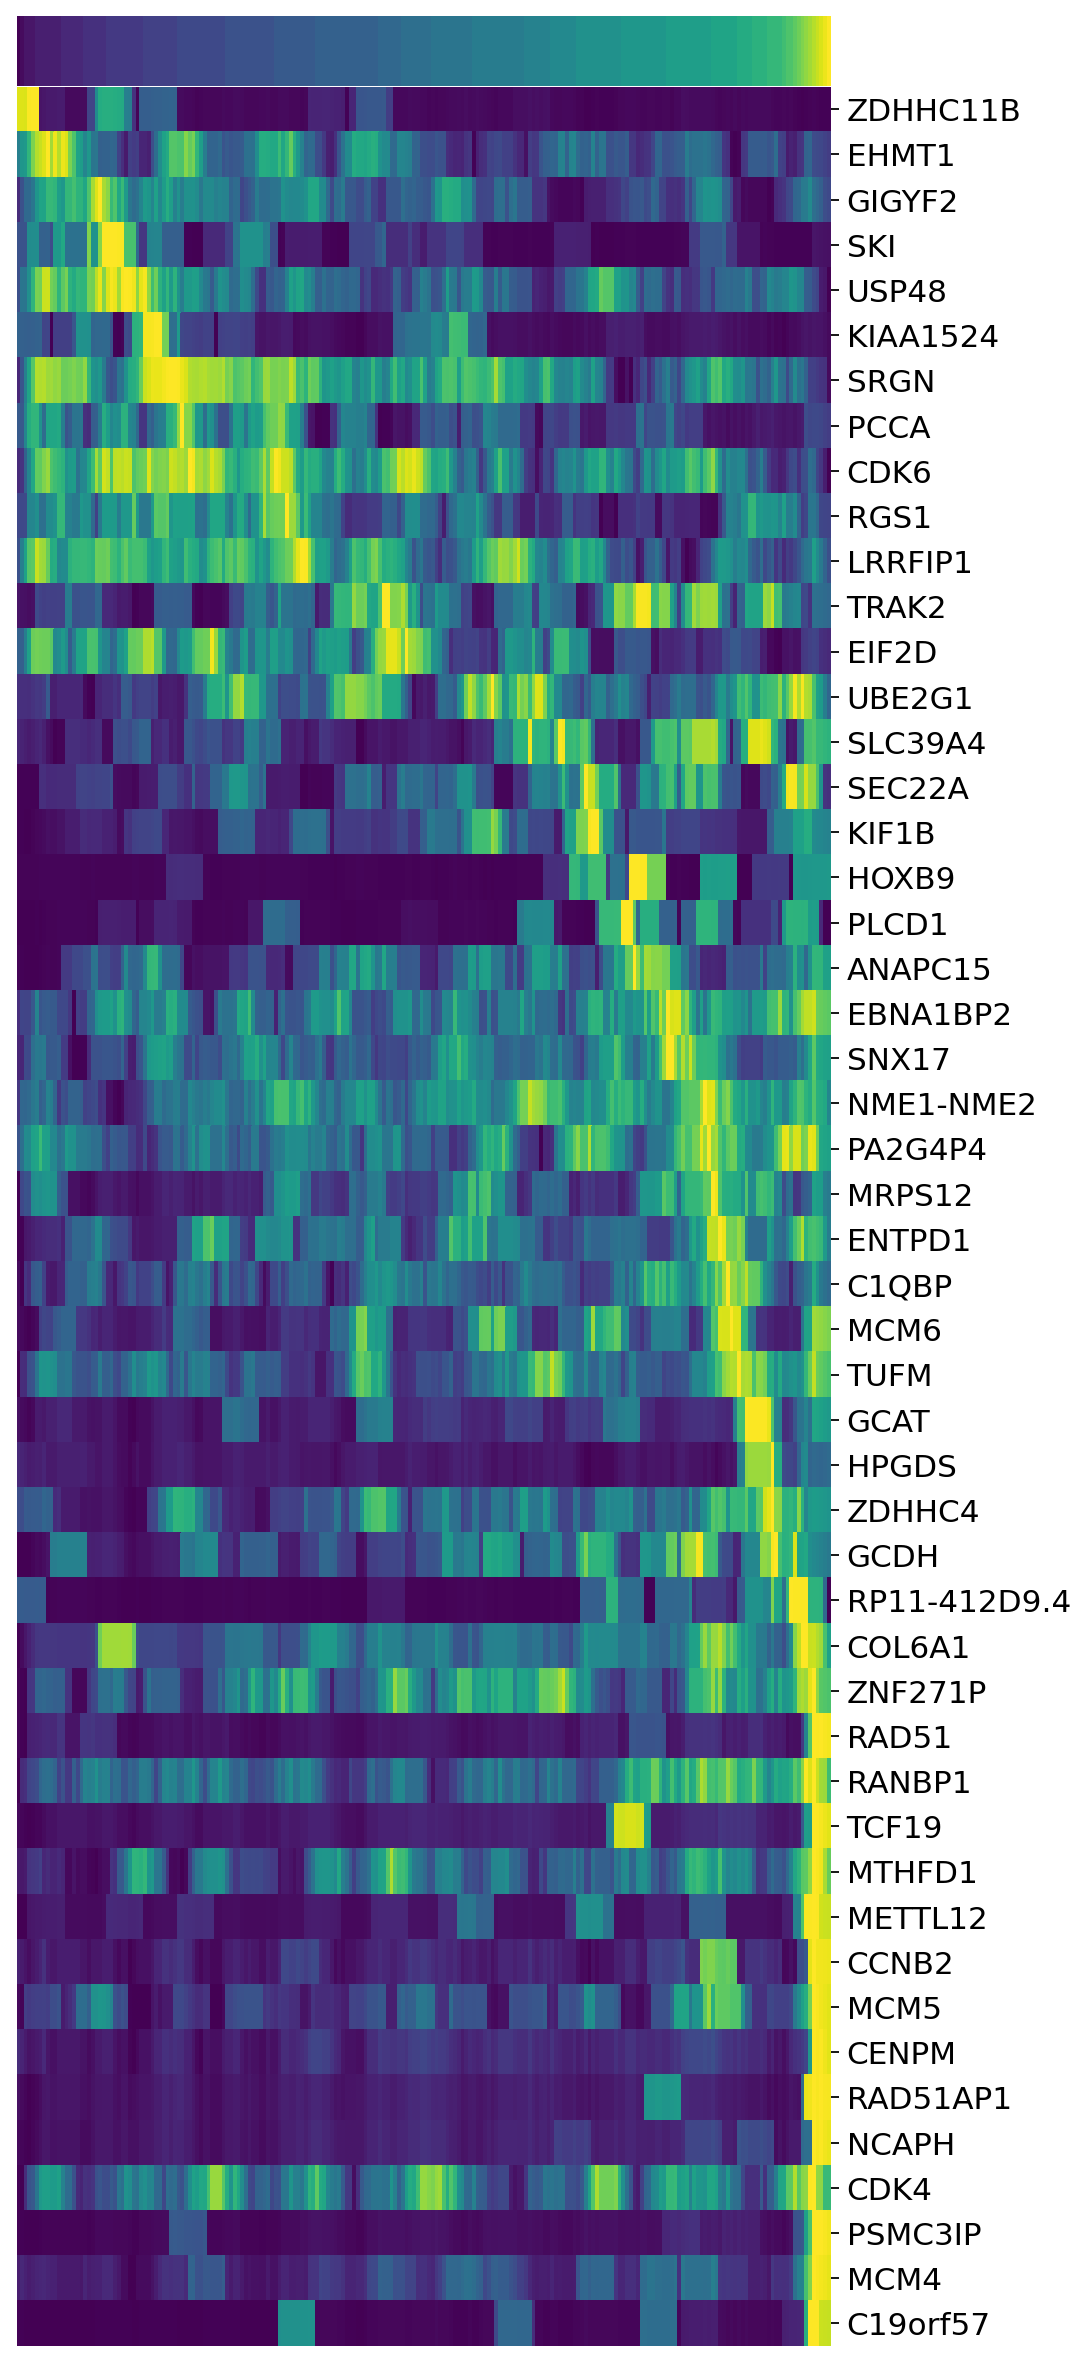

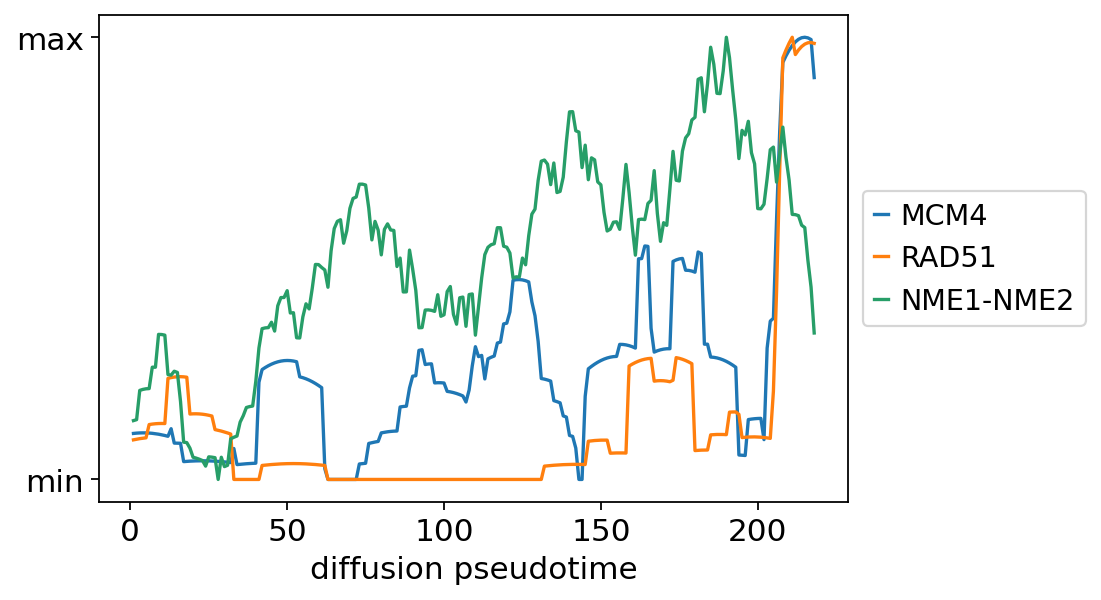

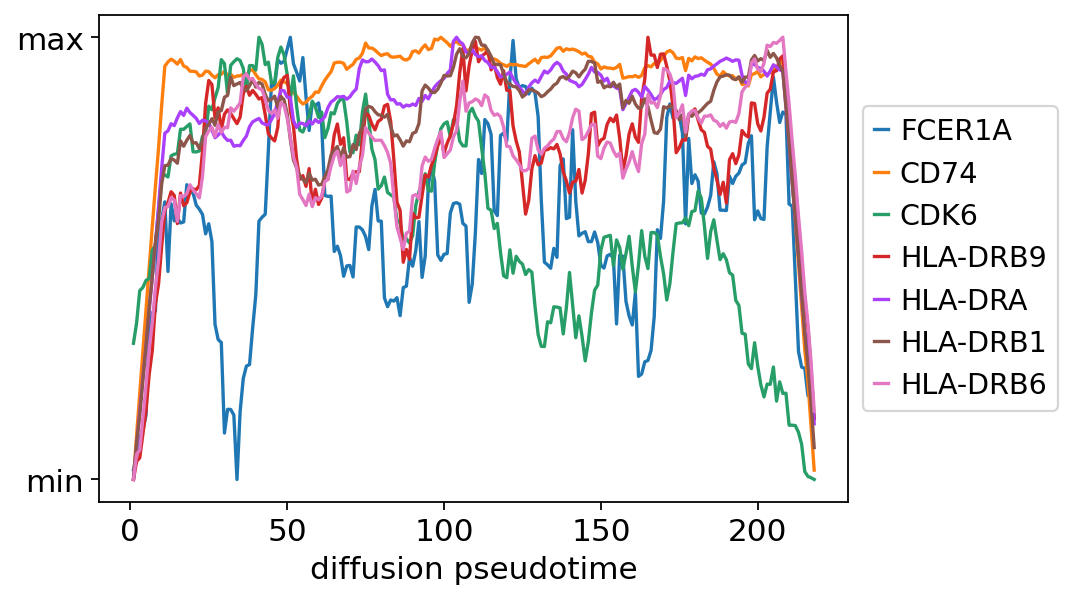

Day0_ST-HSC


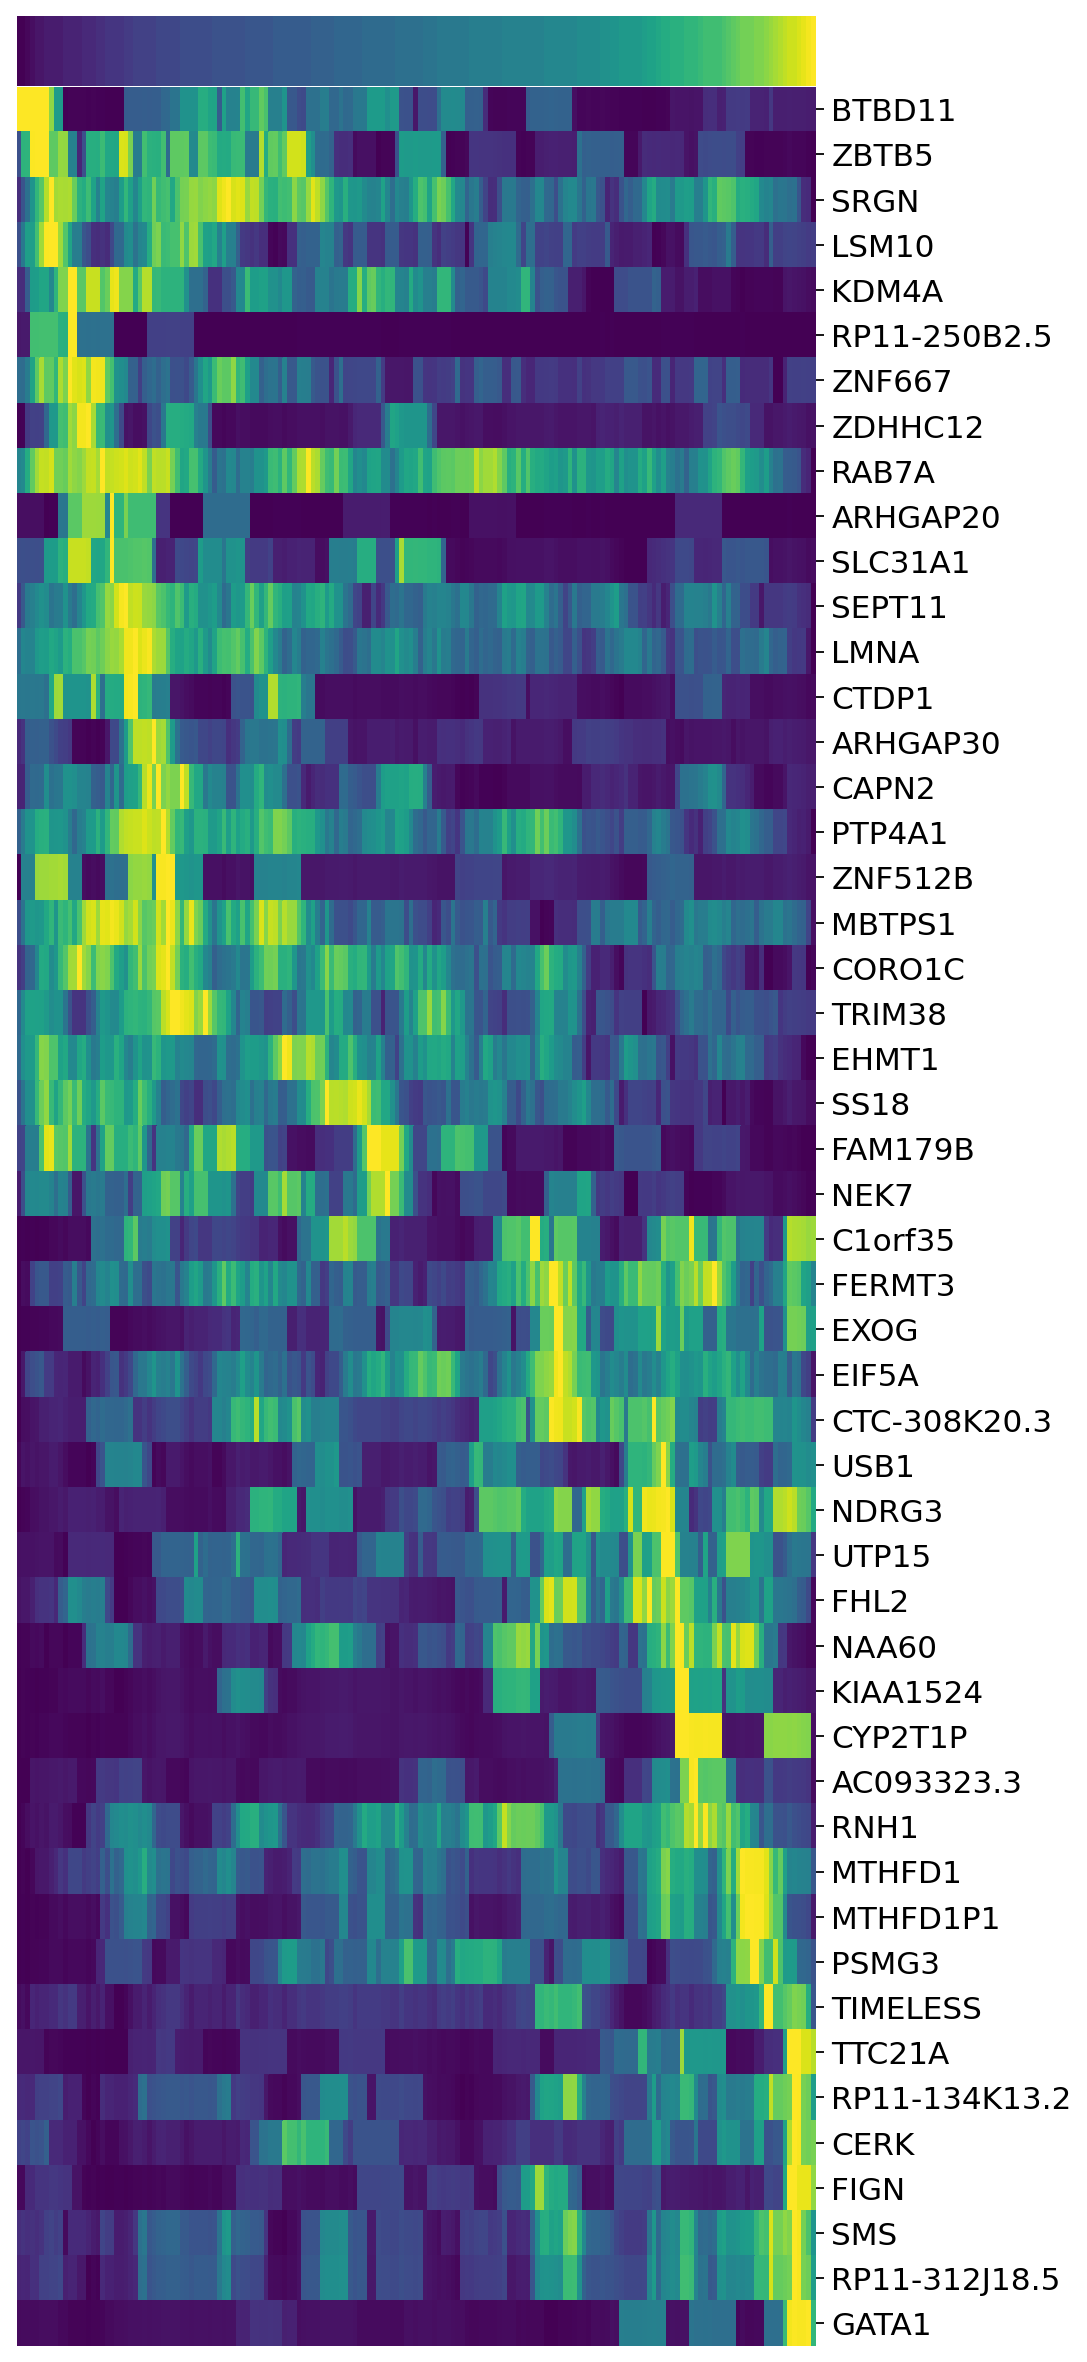

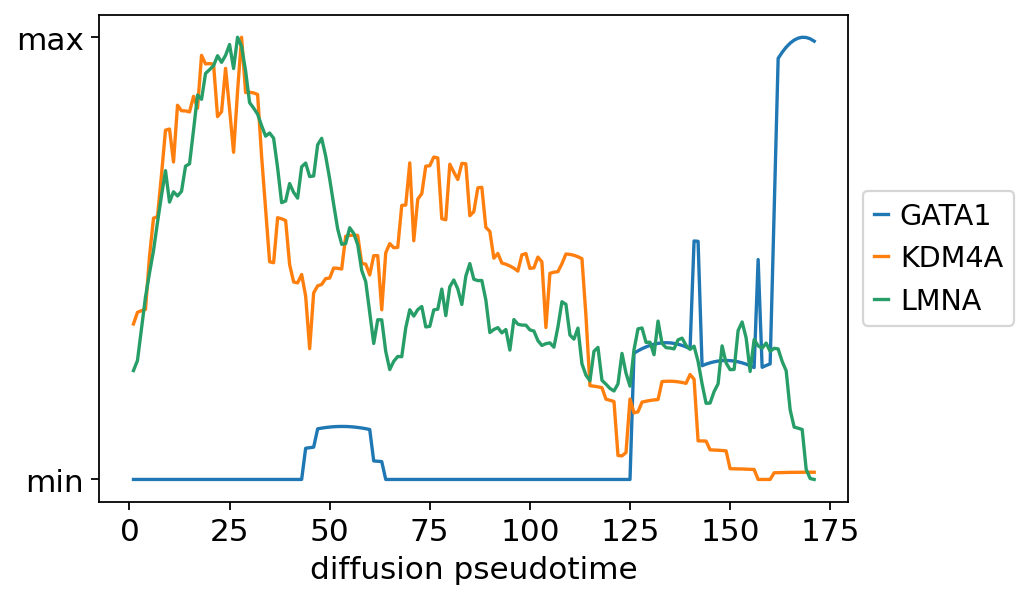

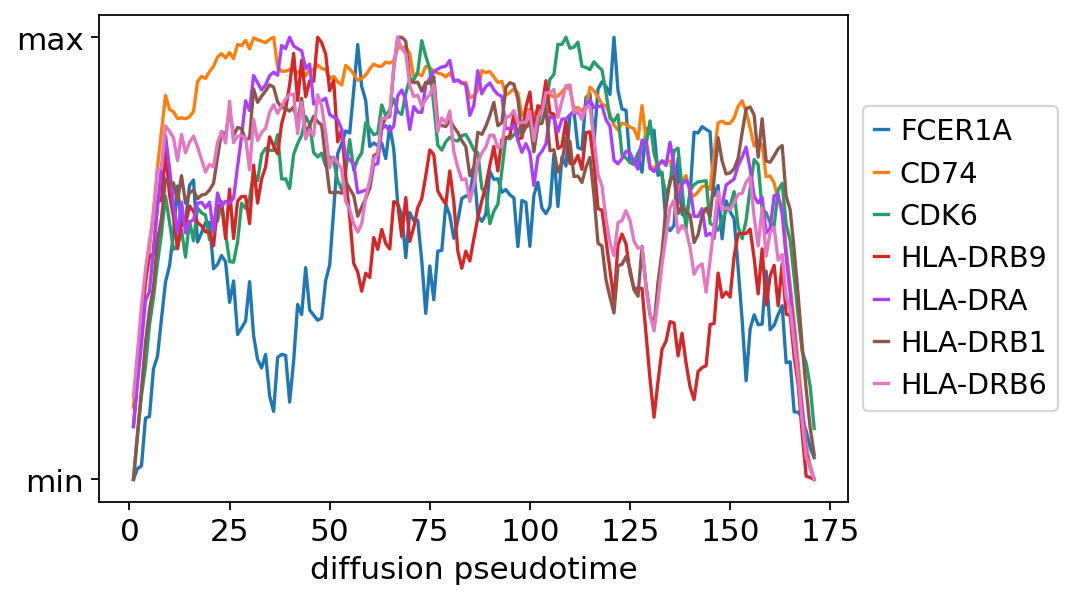

Day3_CD34+


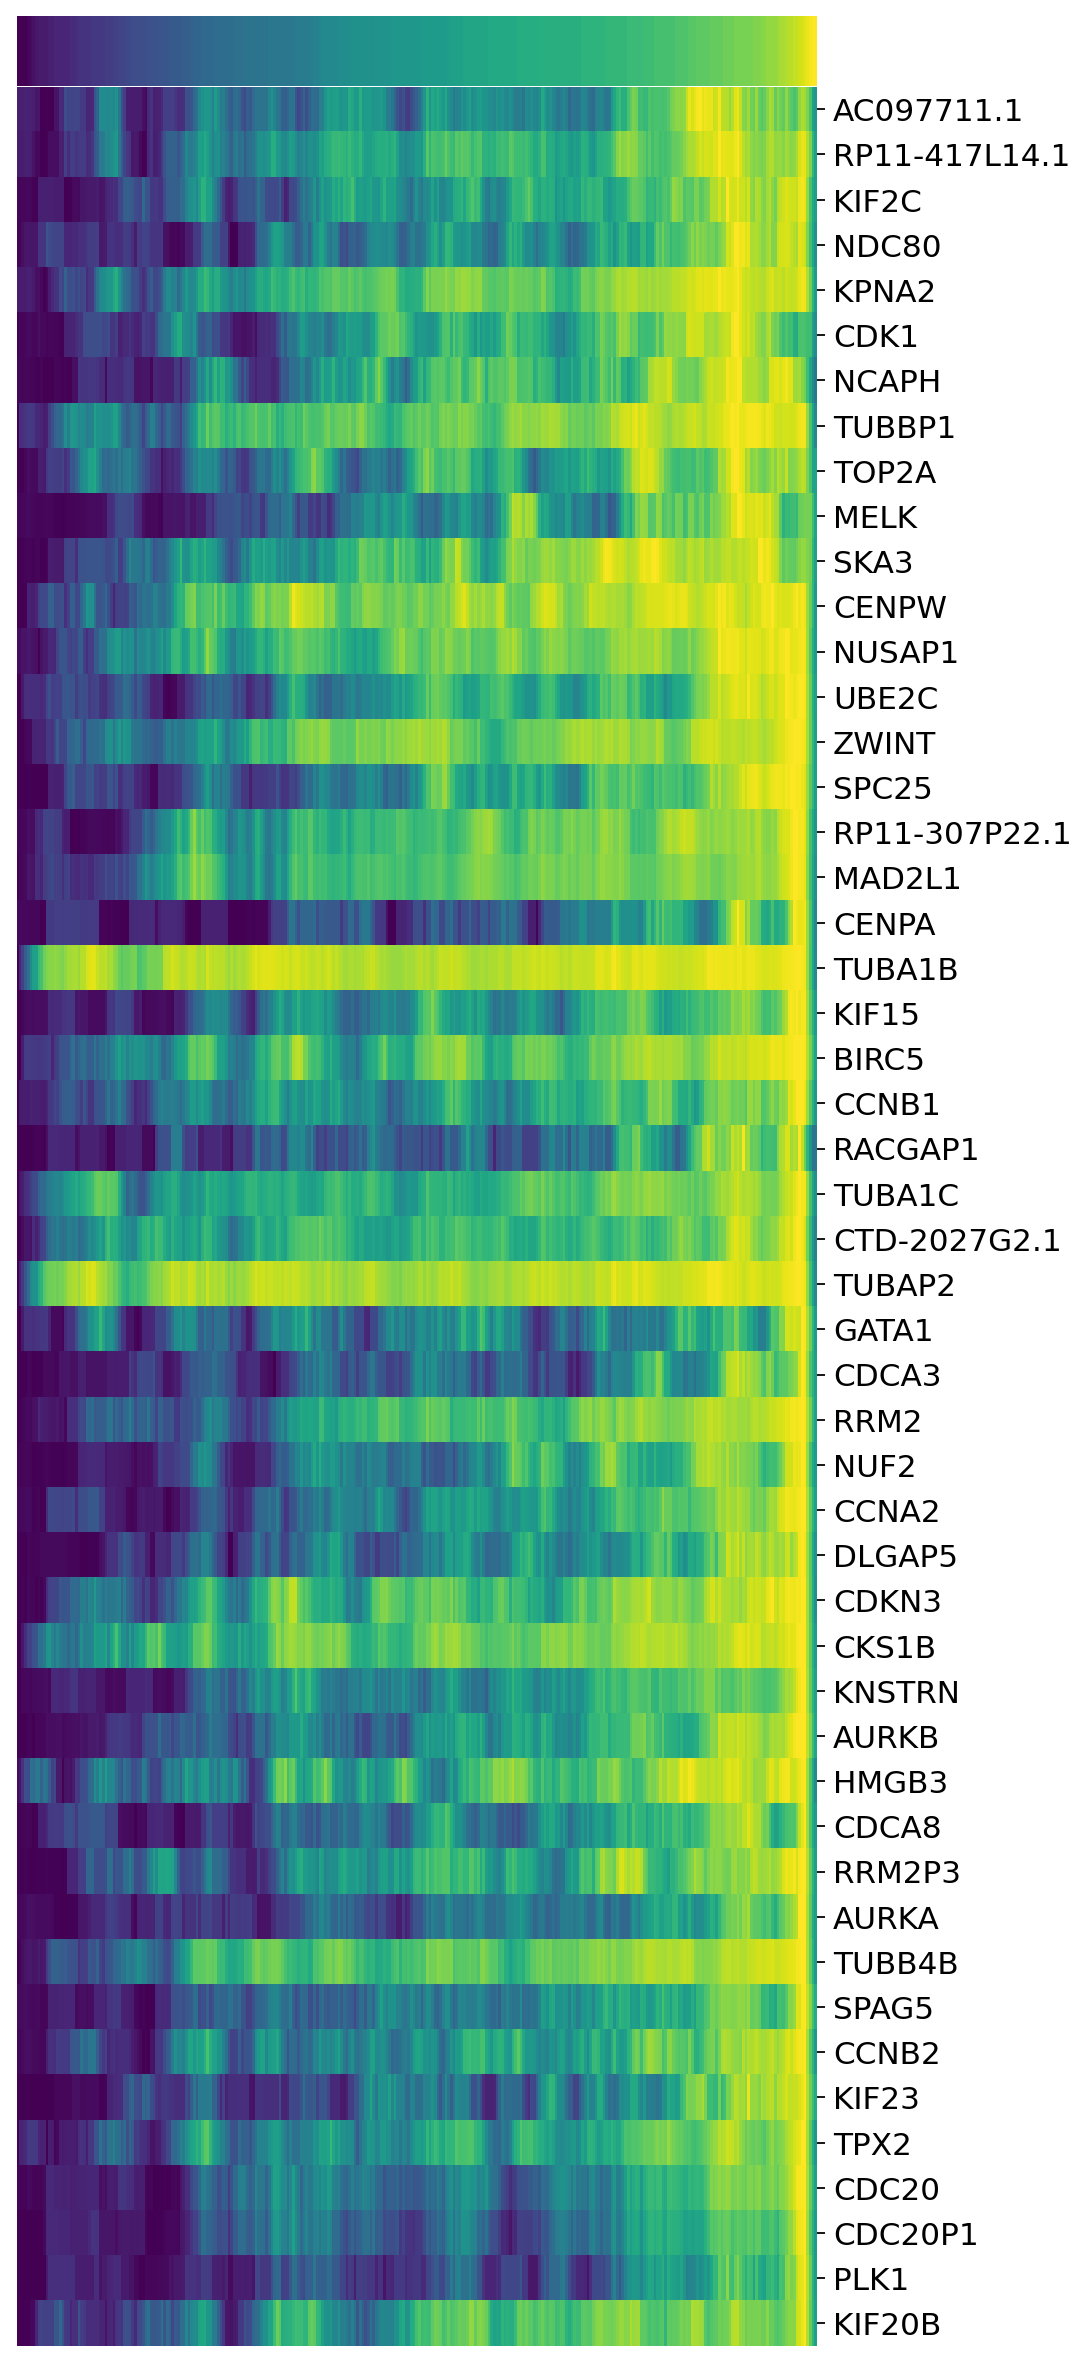

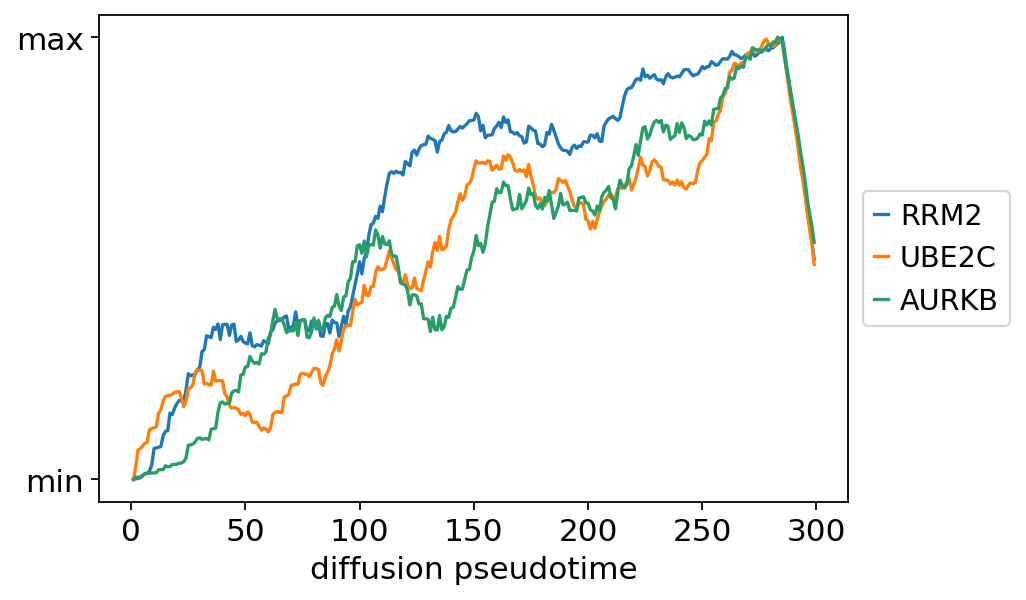

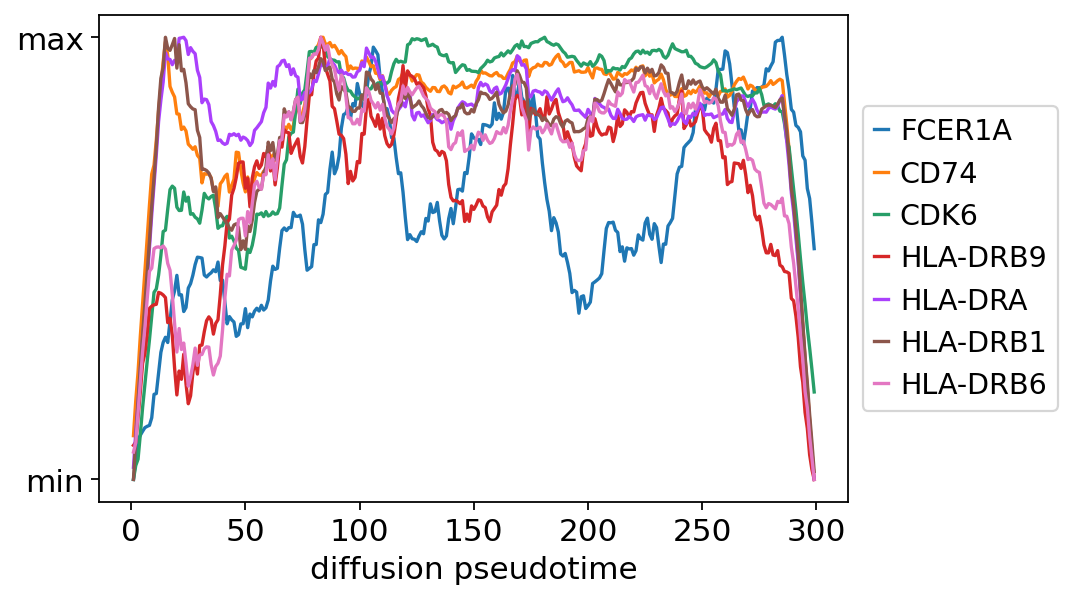

Day3_LT-HSC


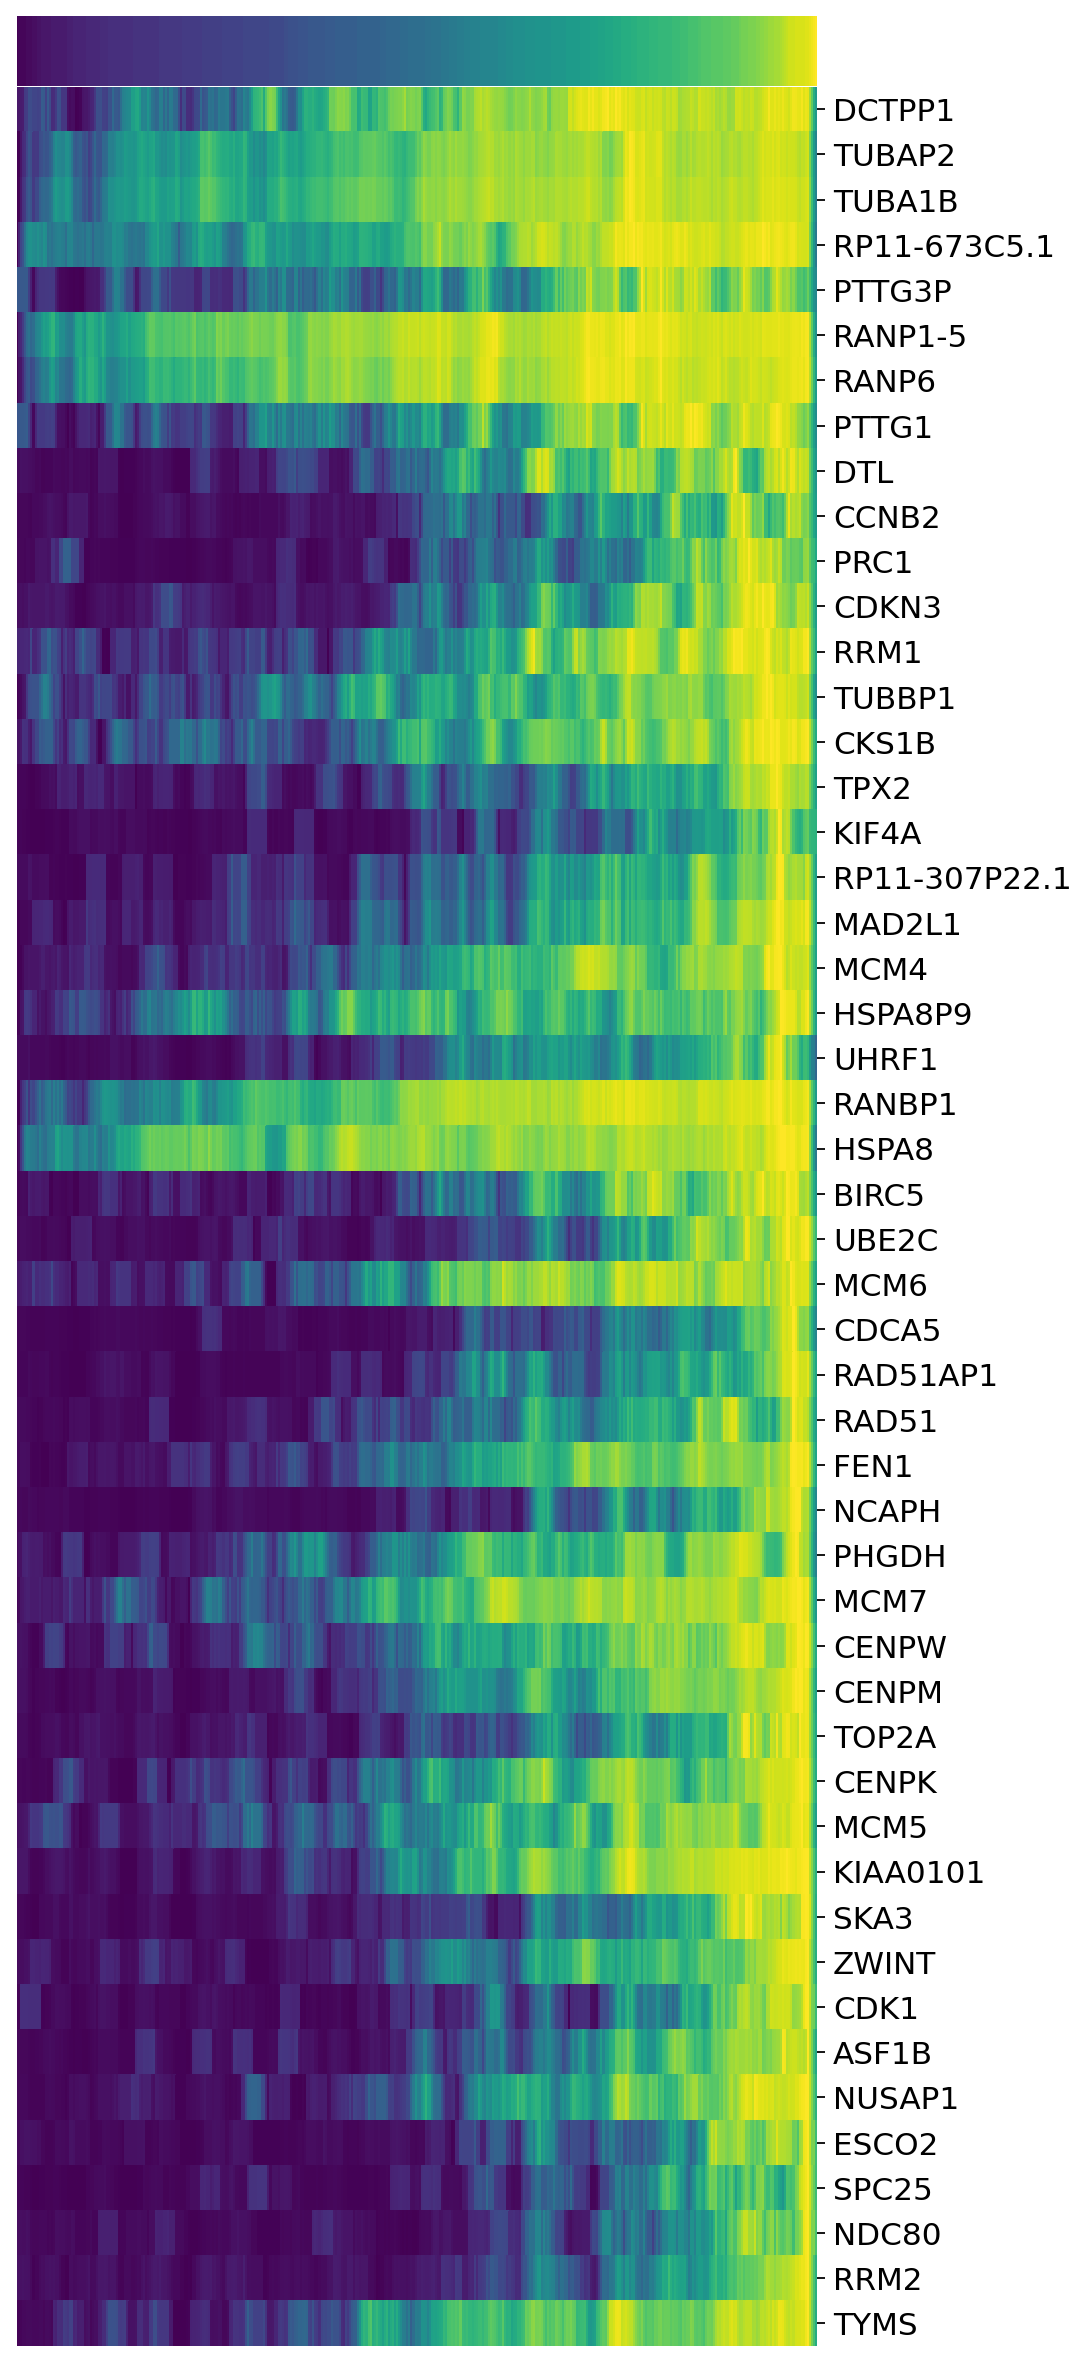

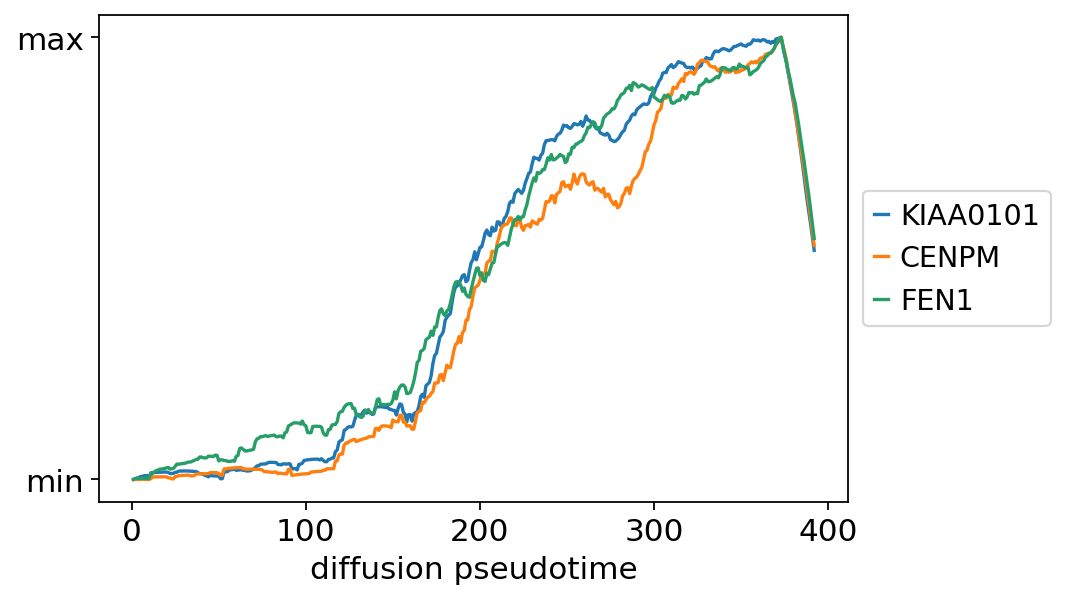

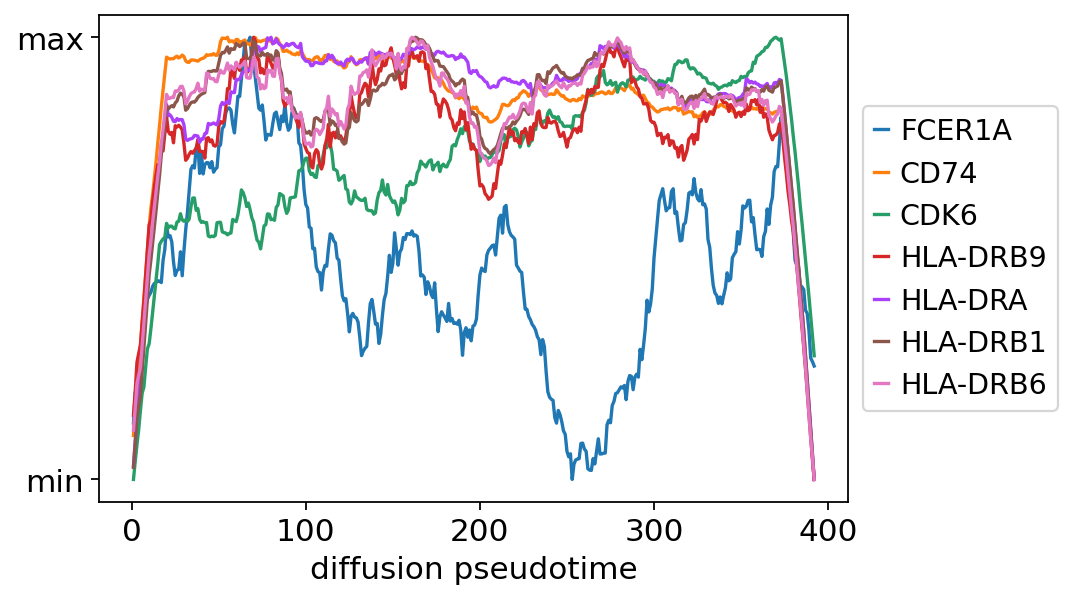

Day3_ST-HSC


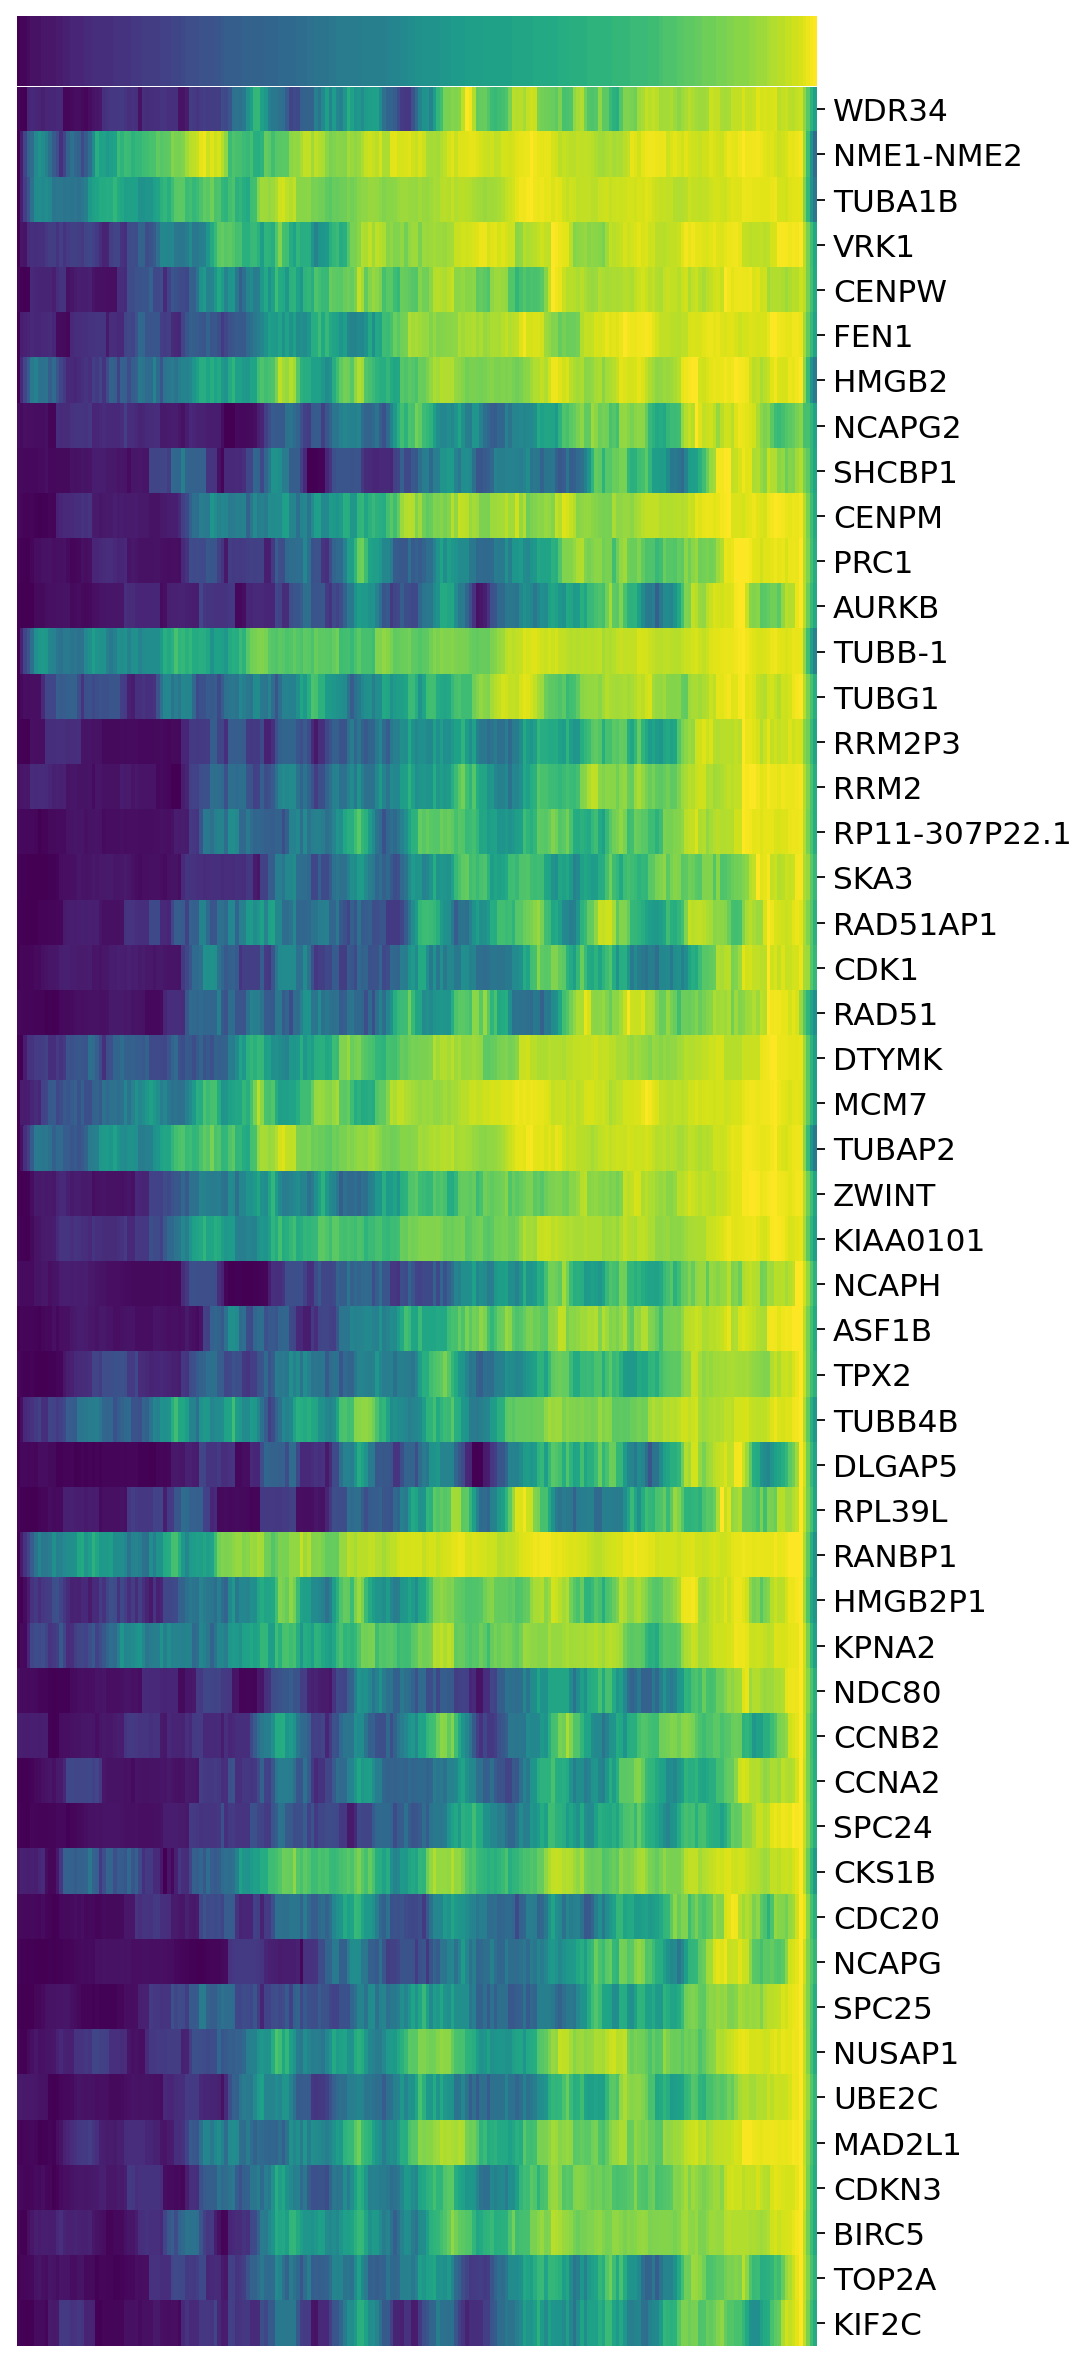

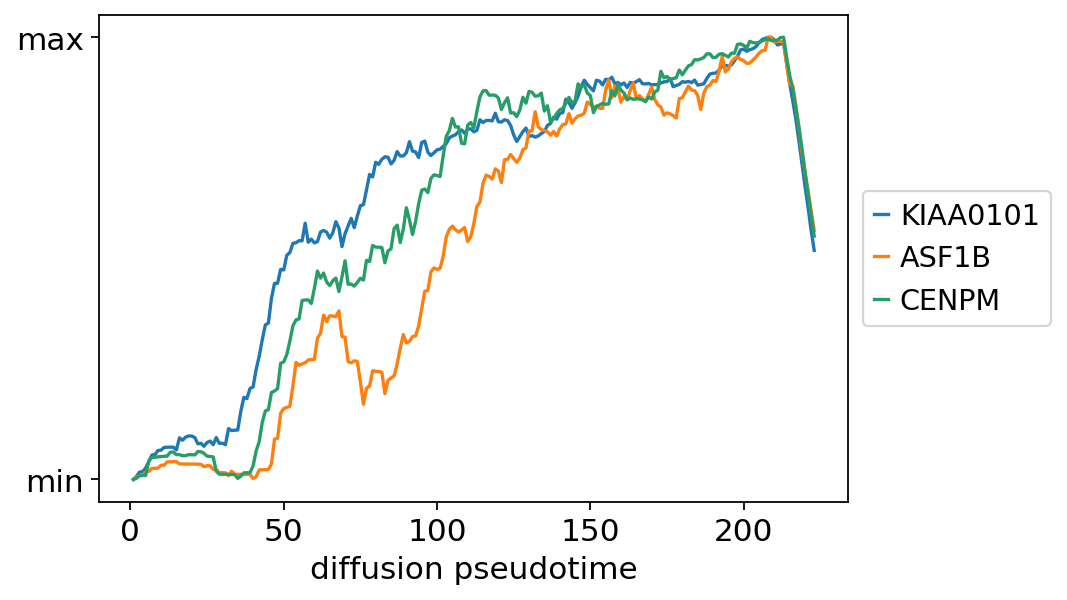

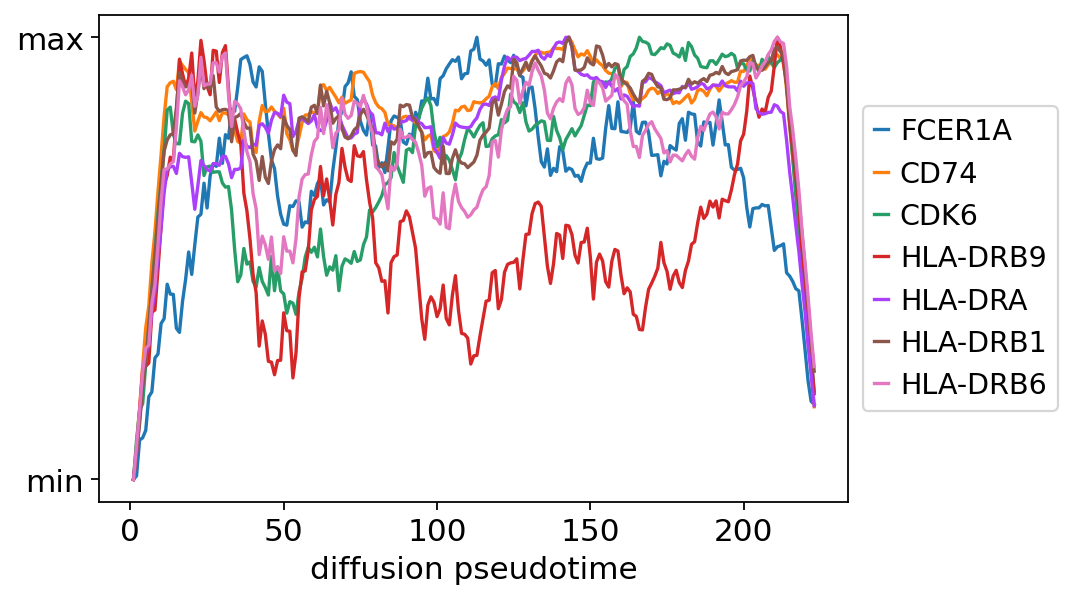

In [25]:
from scipy.stats import rankdata
import scvelo as scv
for cond in MPBdata.obs['cond_comb1'].cat.categories:
    print(cond)
    adata_sub = MPBdata[MPBdata.obs['cond_comb1'] == cond].copy()
    adata_sub = adata_sub[:,adata_sub.uns['varGenes']['genes']['highVar']].copy()
    adata_sub.obs['pt_rank'] = rankdata(adata_sub.obs['destiny_pt_kenny'])
    DEgene_pt = smqpp.GeneExp_LLR_test(adata_sub, alt_obs=['pt_rank', 'n_genes', 'batch'], useHVG=True, null_obs=['n_genes', 'batch'])

    scv.pl.heatmap(adata_sub, var_names=DEgene_pt.index[0:50], tkey='pt_rank', n_convolve=10, col_color='destiny_pt_kenny', figsize=(7,15), yticklabels=True)
    smqpp.plot_genes_along_pt(adata_sub, genes=DEgene_pt.index[0:3], sigma=20, pt_obs='pt_rank')
    GL1 = ['FCER1A', 'CD74', 'CDK6',  
           'HLA-DRB9', 'HLA-DRA', 'HLA-DRB1', 
          'HLA-DRB6']
    smqpp.plot_genes_along_pt(adata_sub, genes=GL1, sigma=20, pt_obs='pt_rank')

BM data

Day0_CD34+


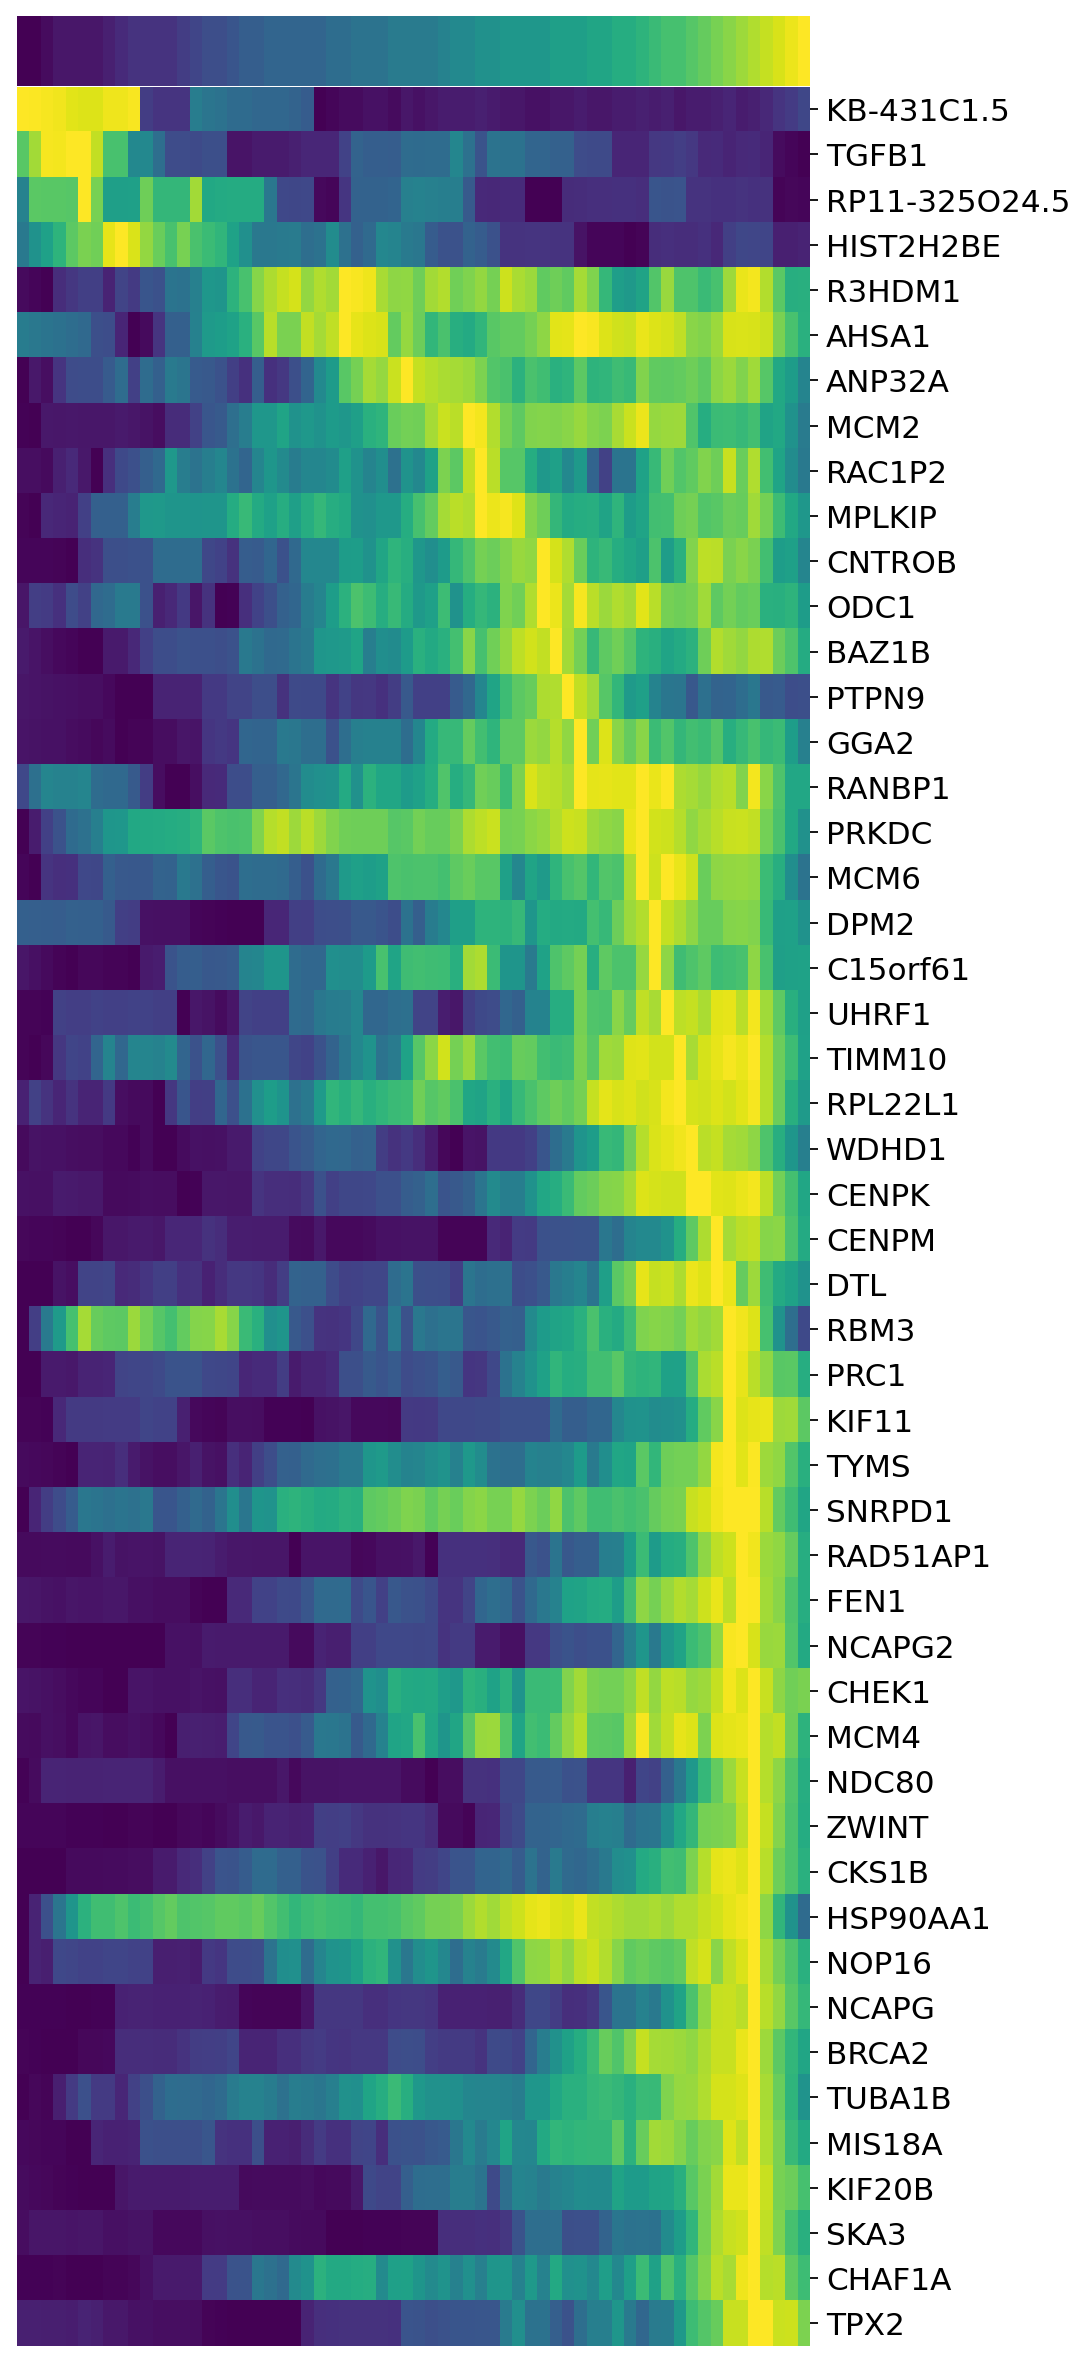

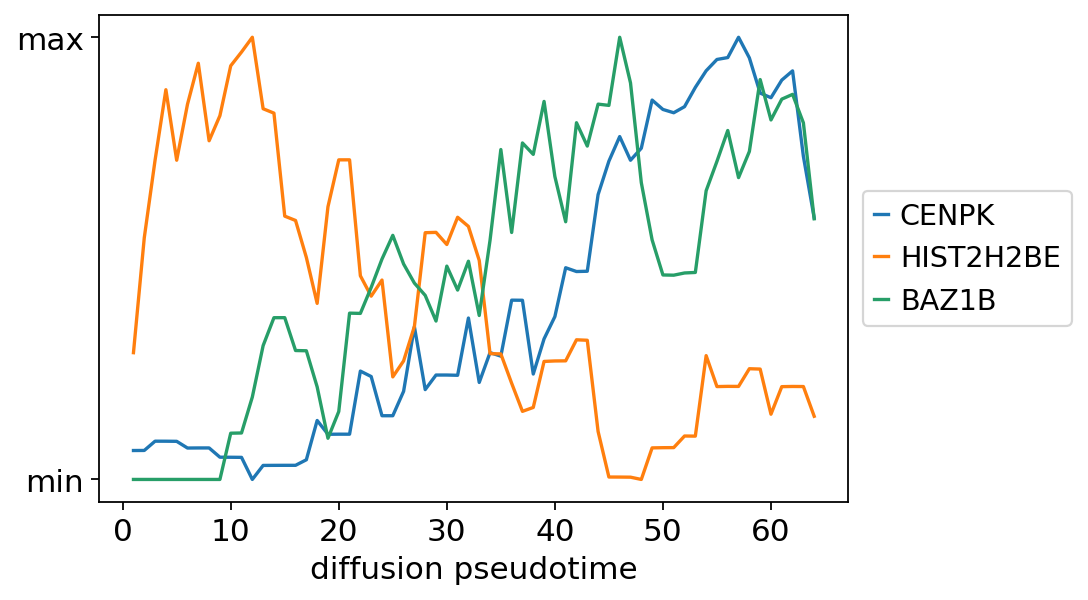

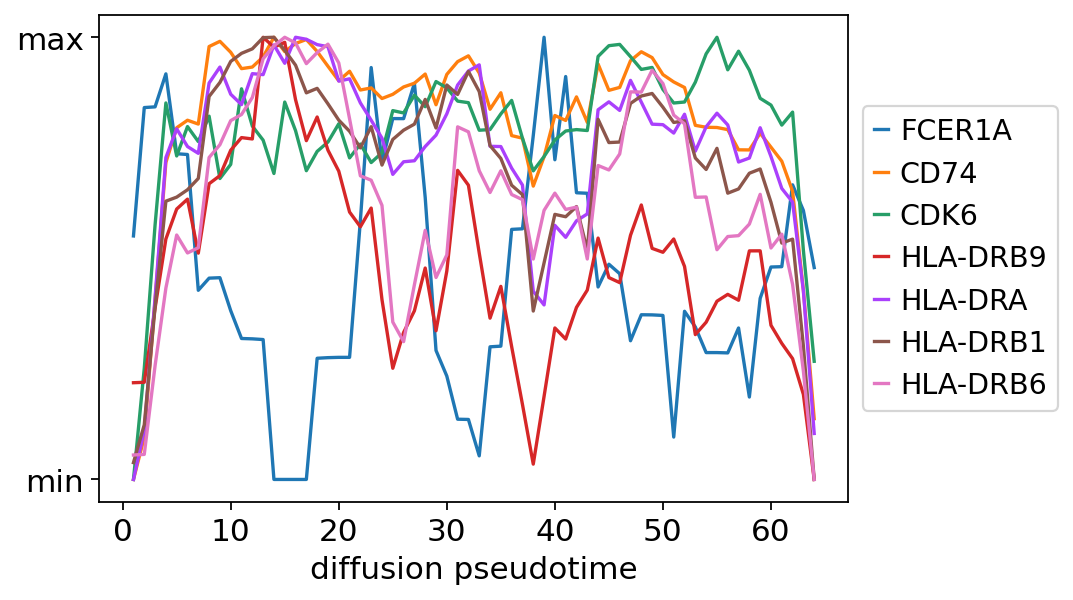

Day0_LT-HSC


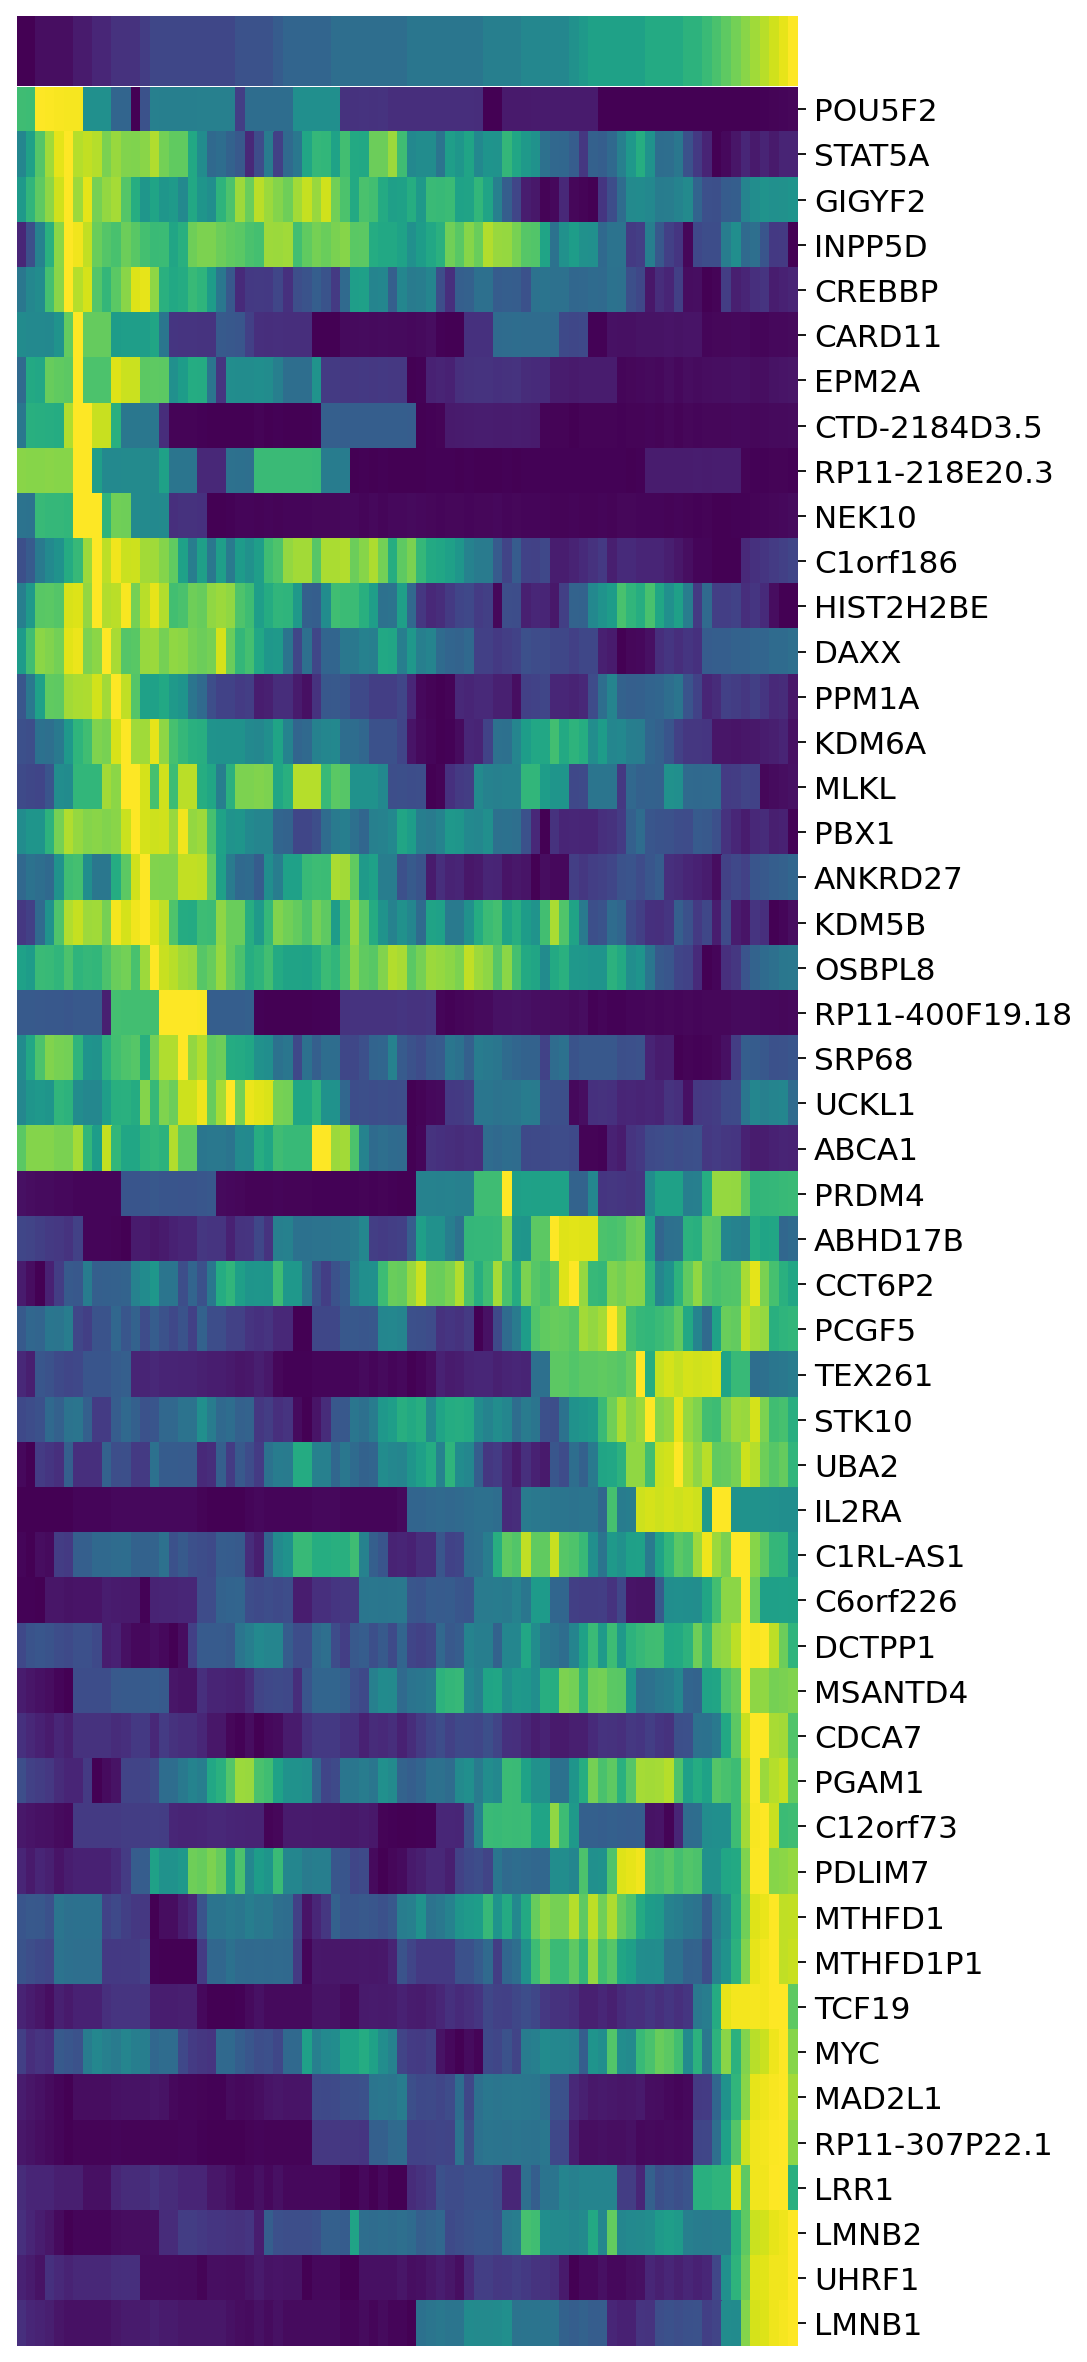

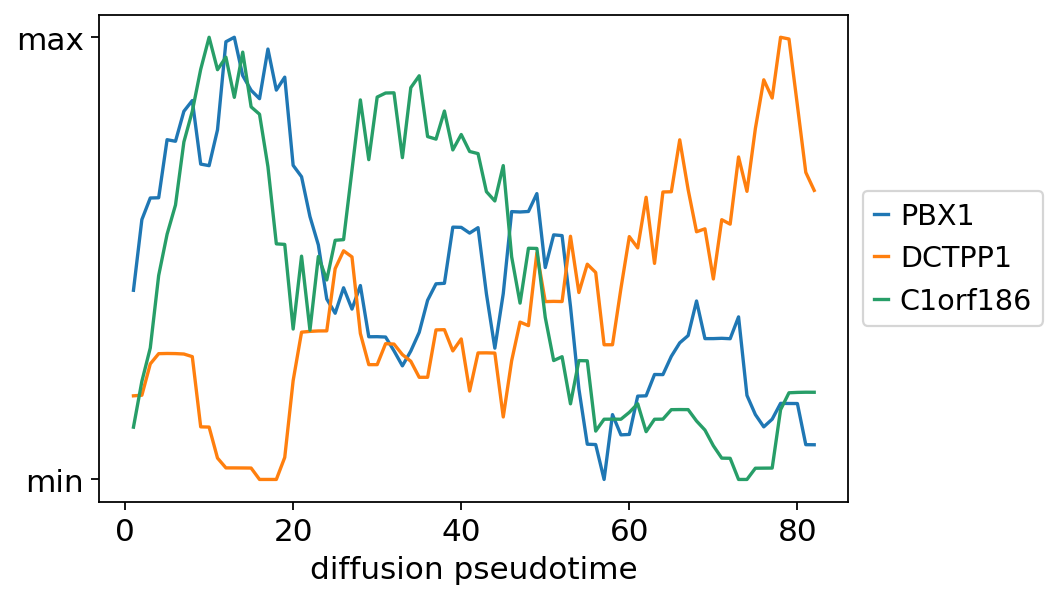

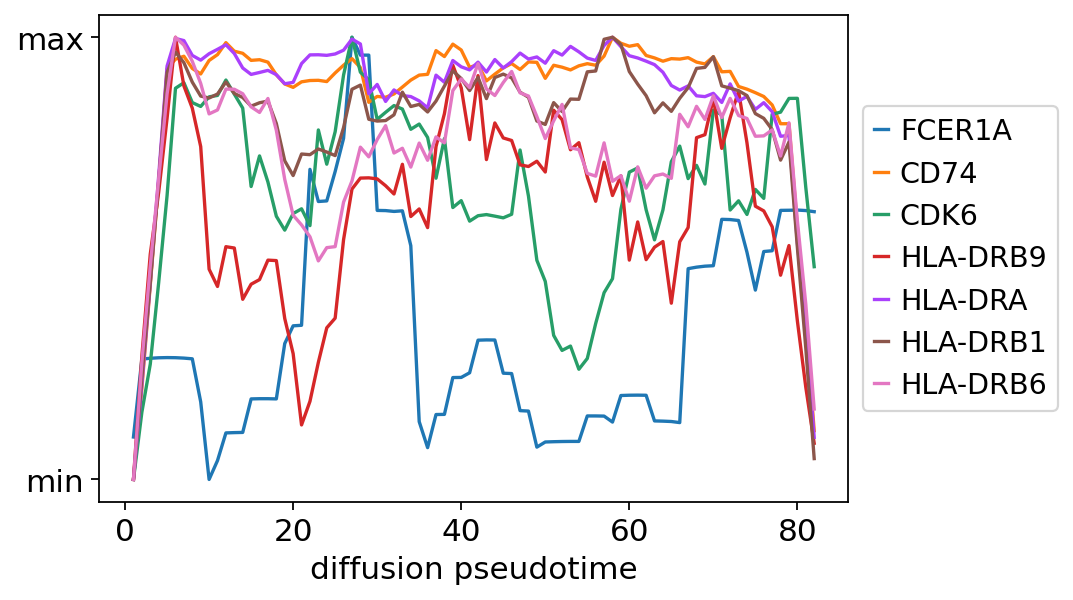

Day0_ST-HSC


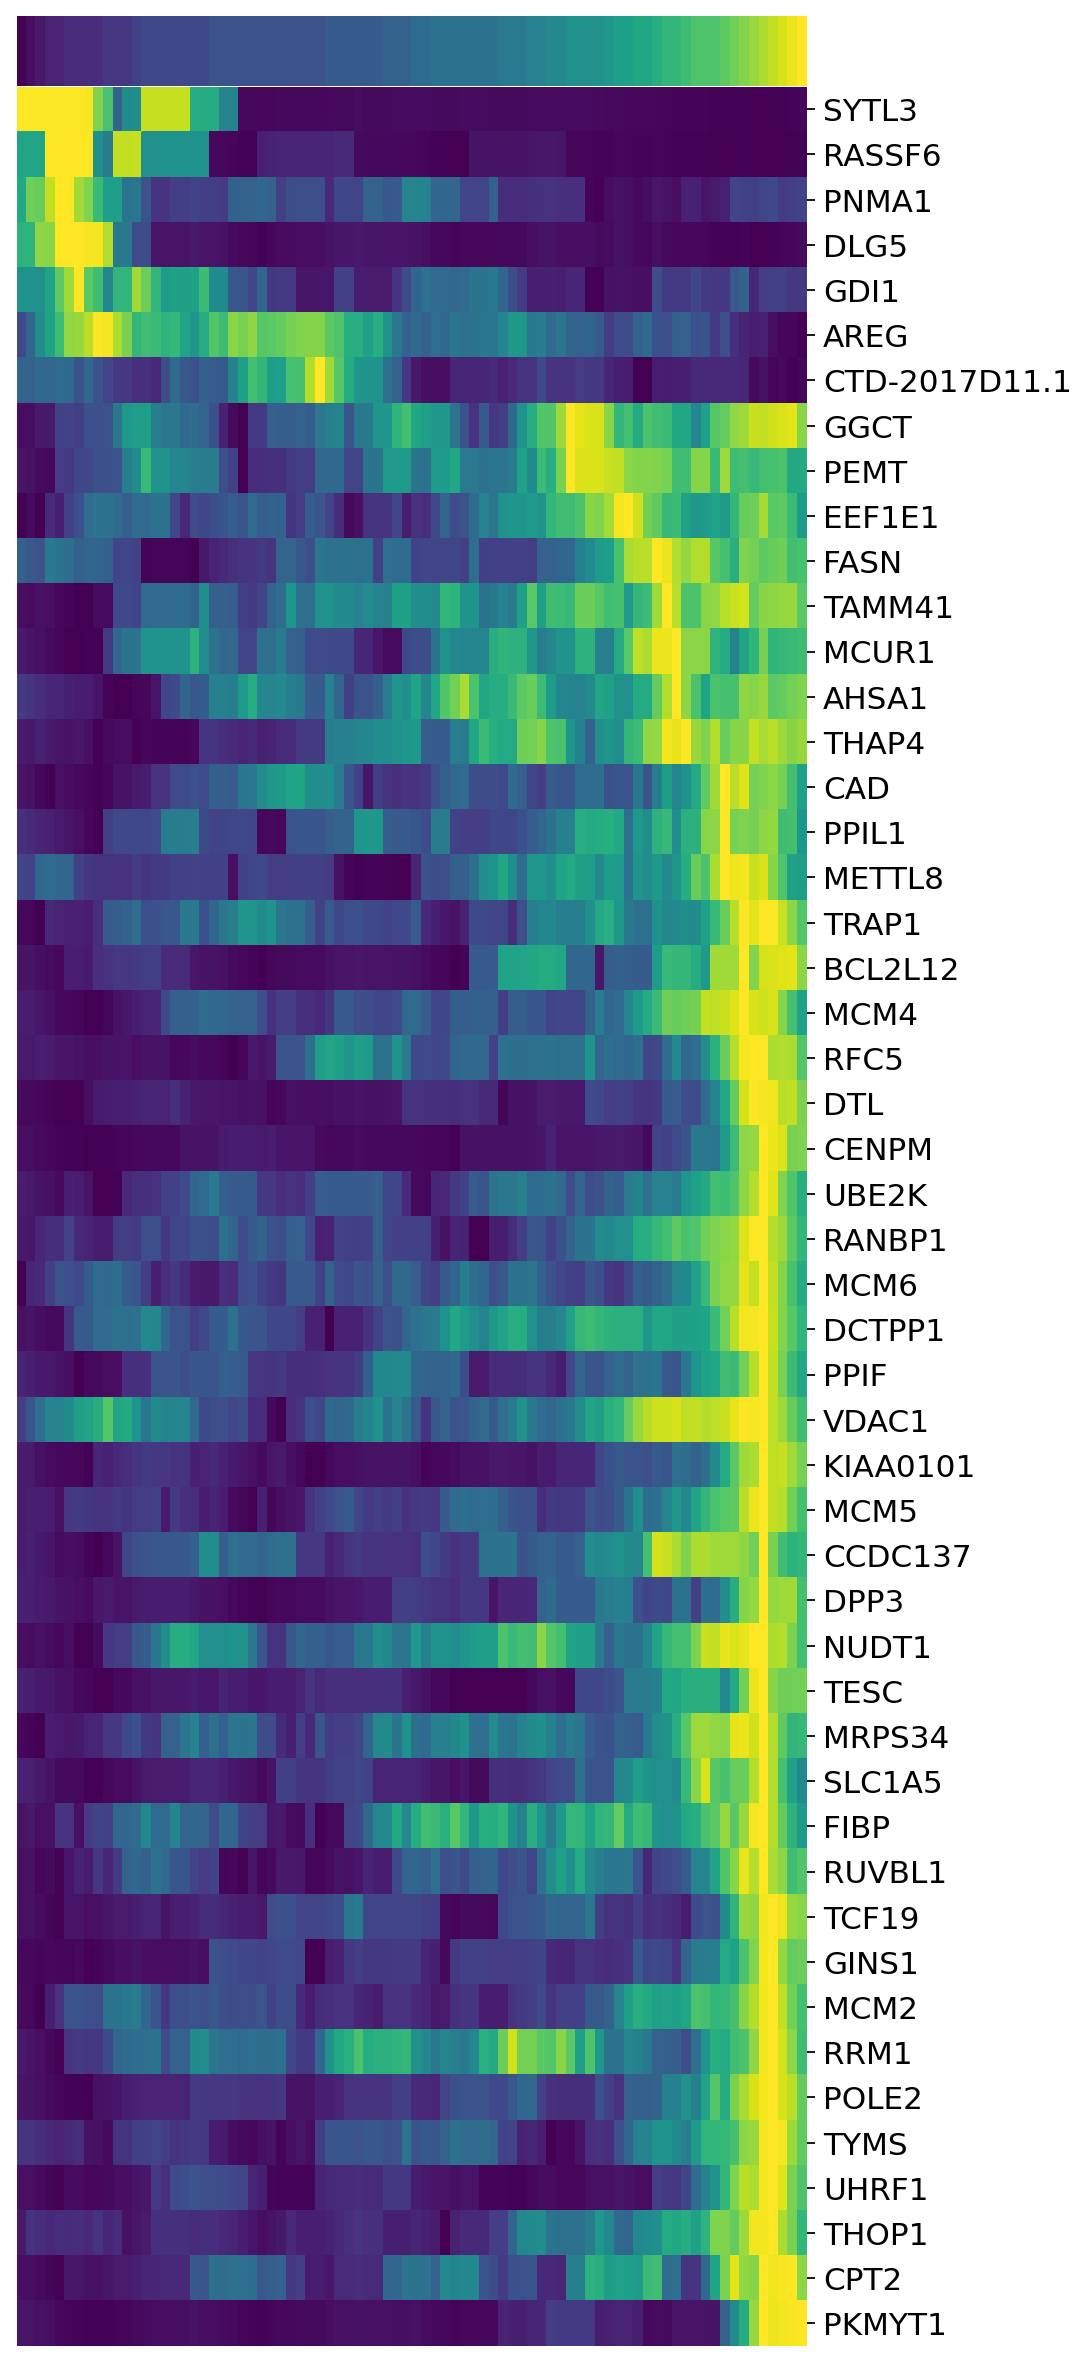

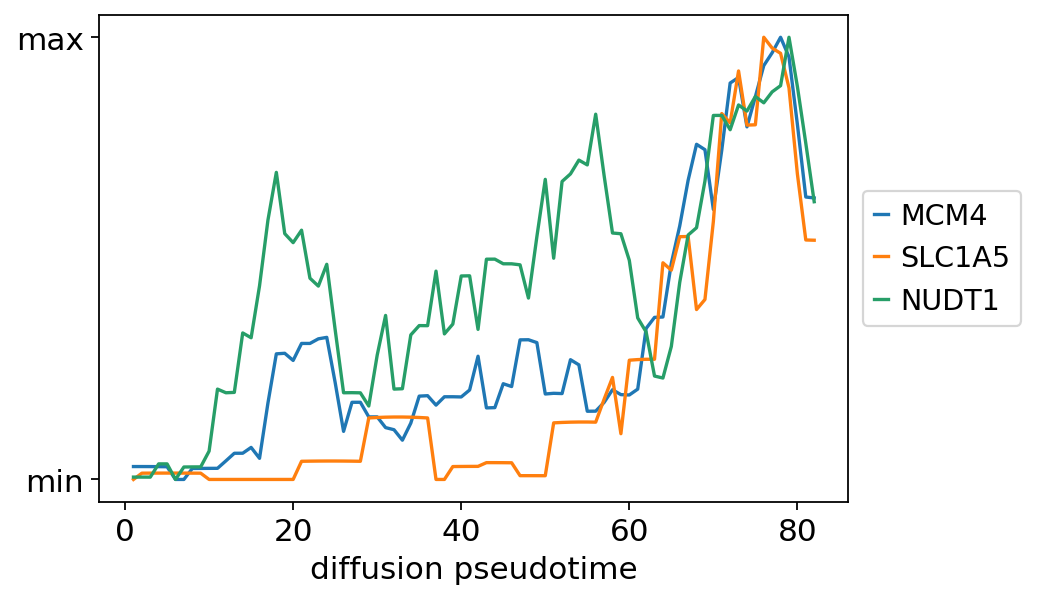

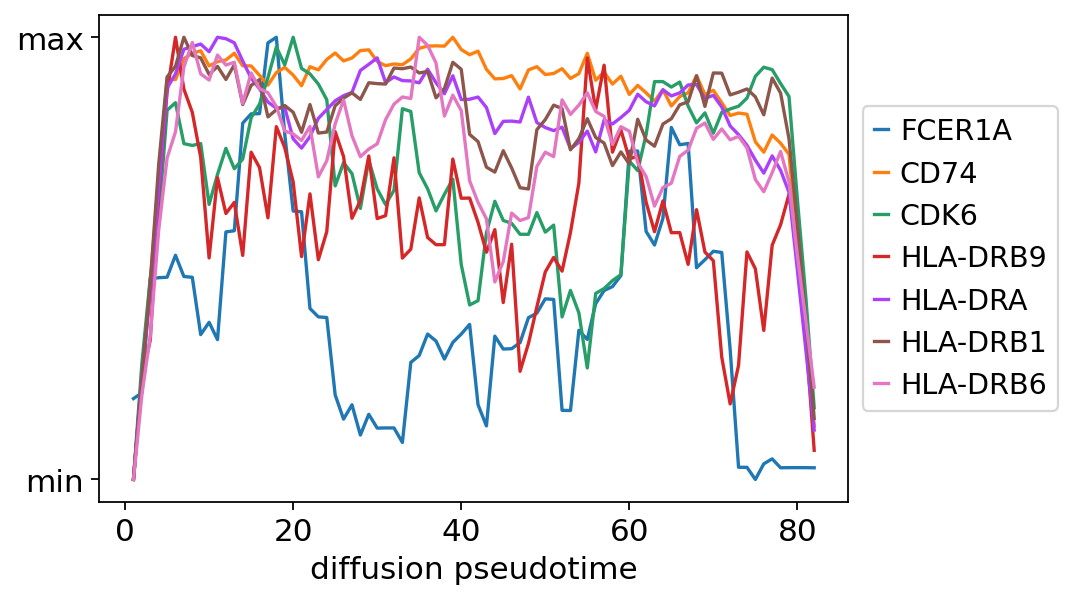

Day3_CD34+


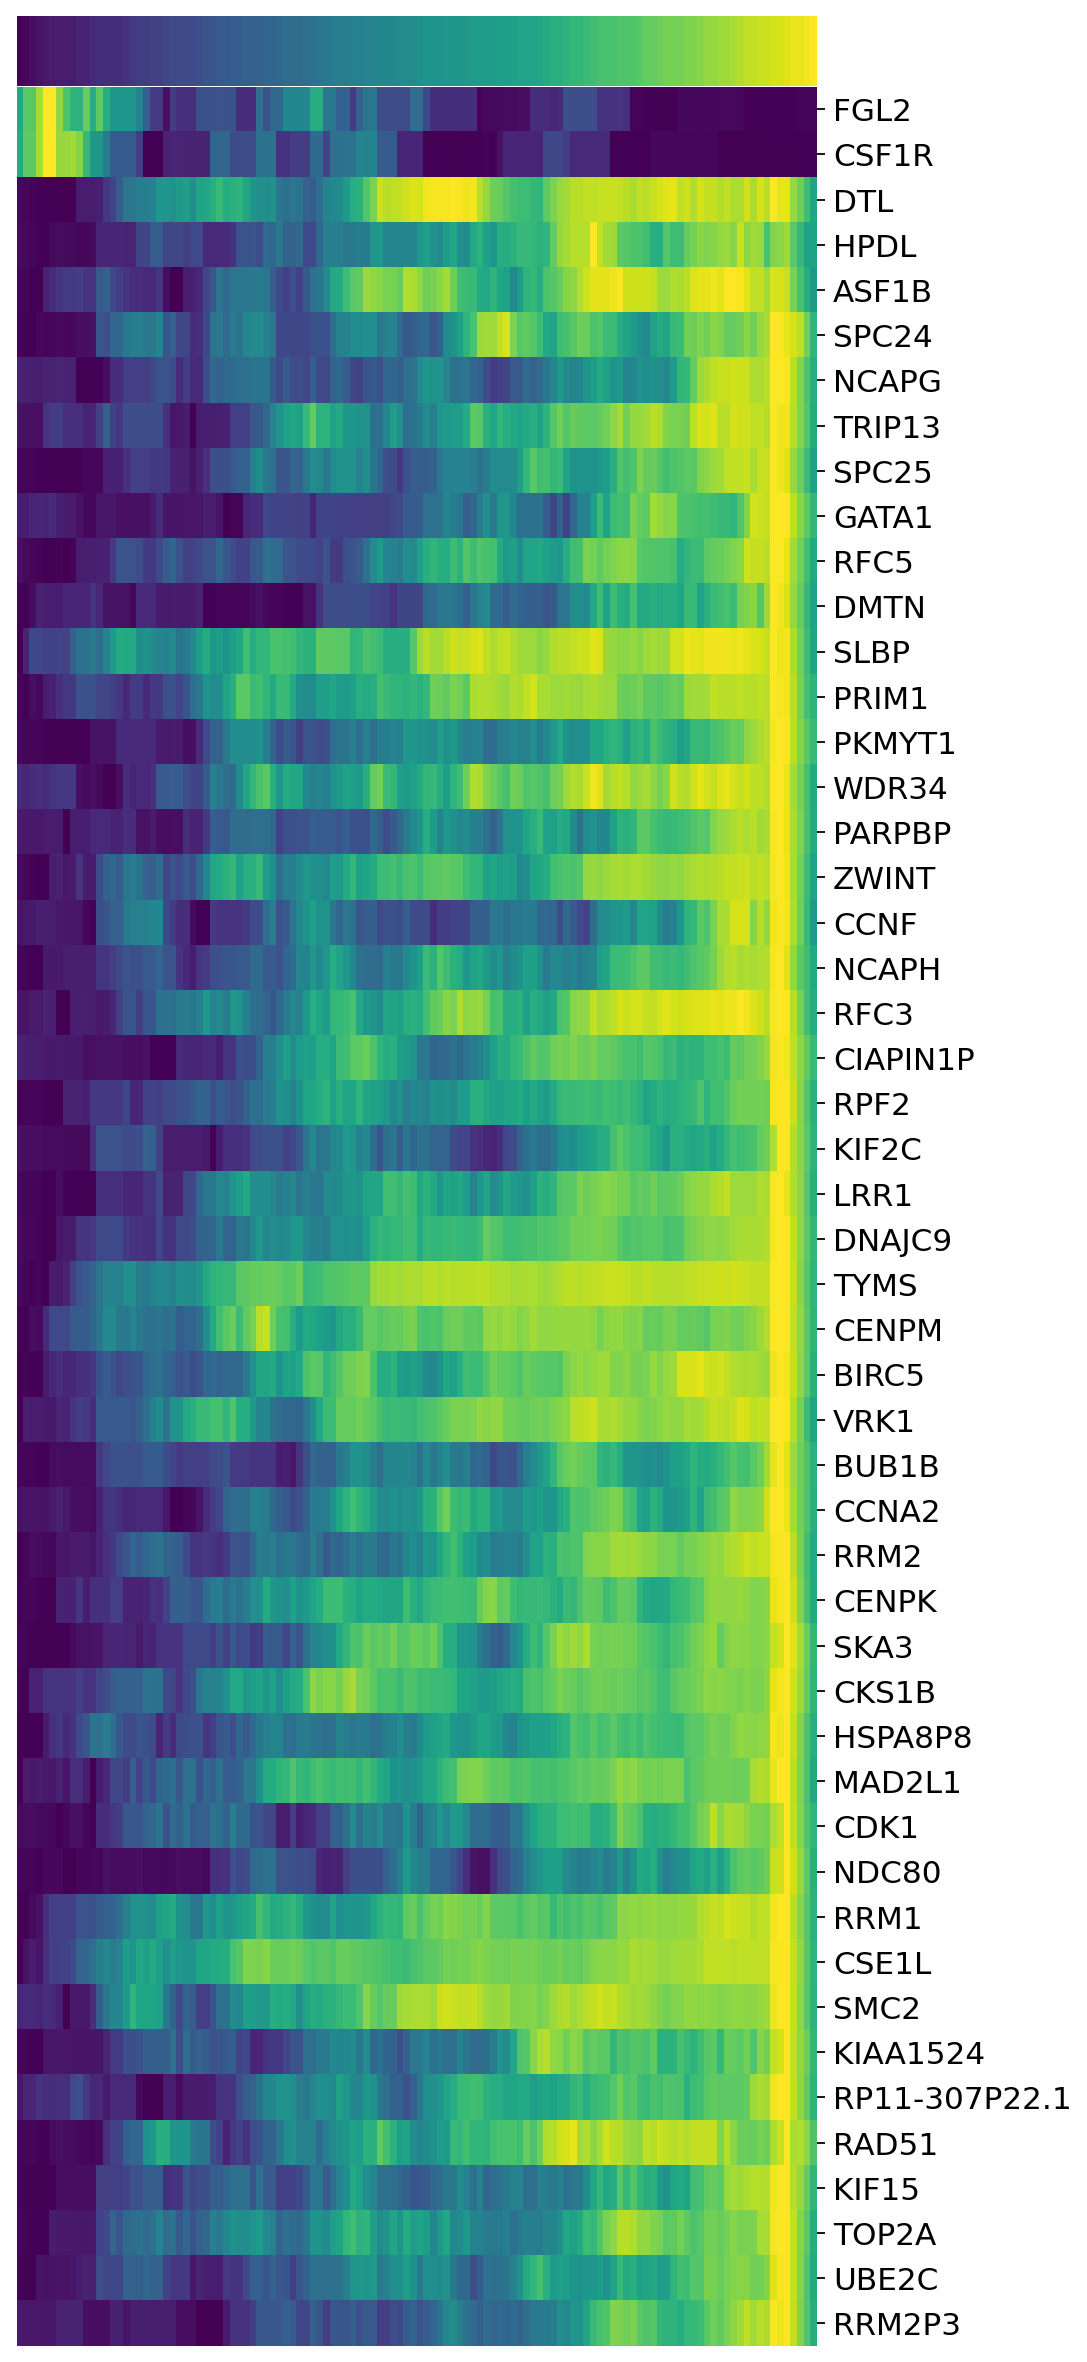

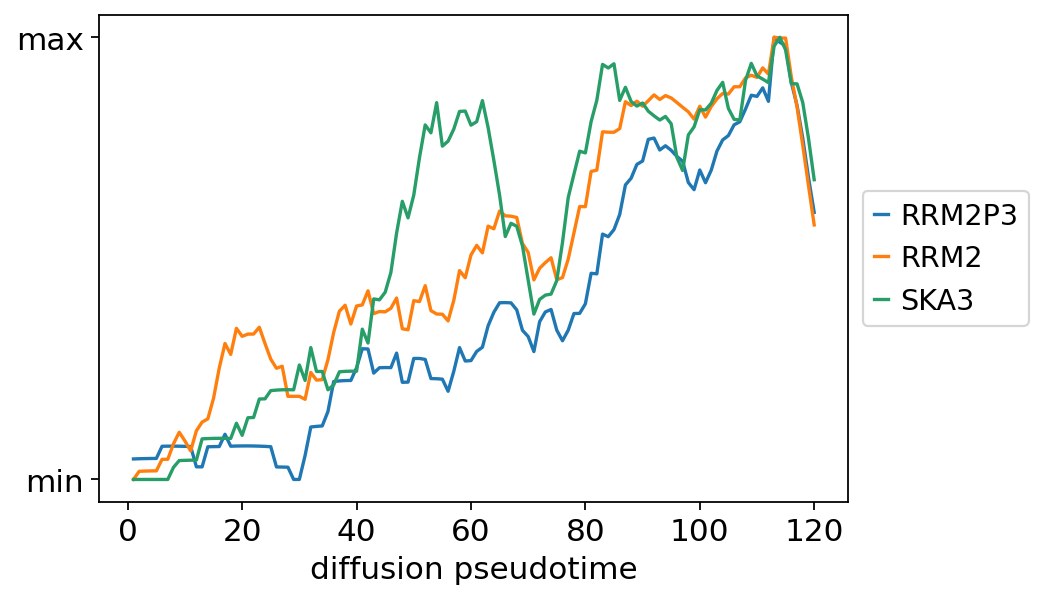

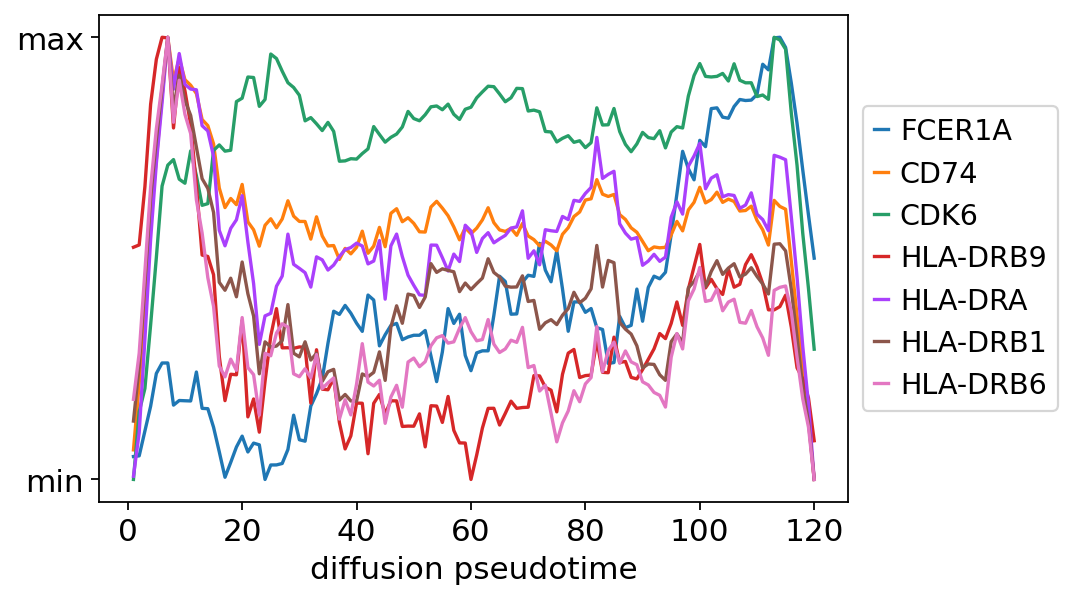

Day3_LT-HSC


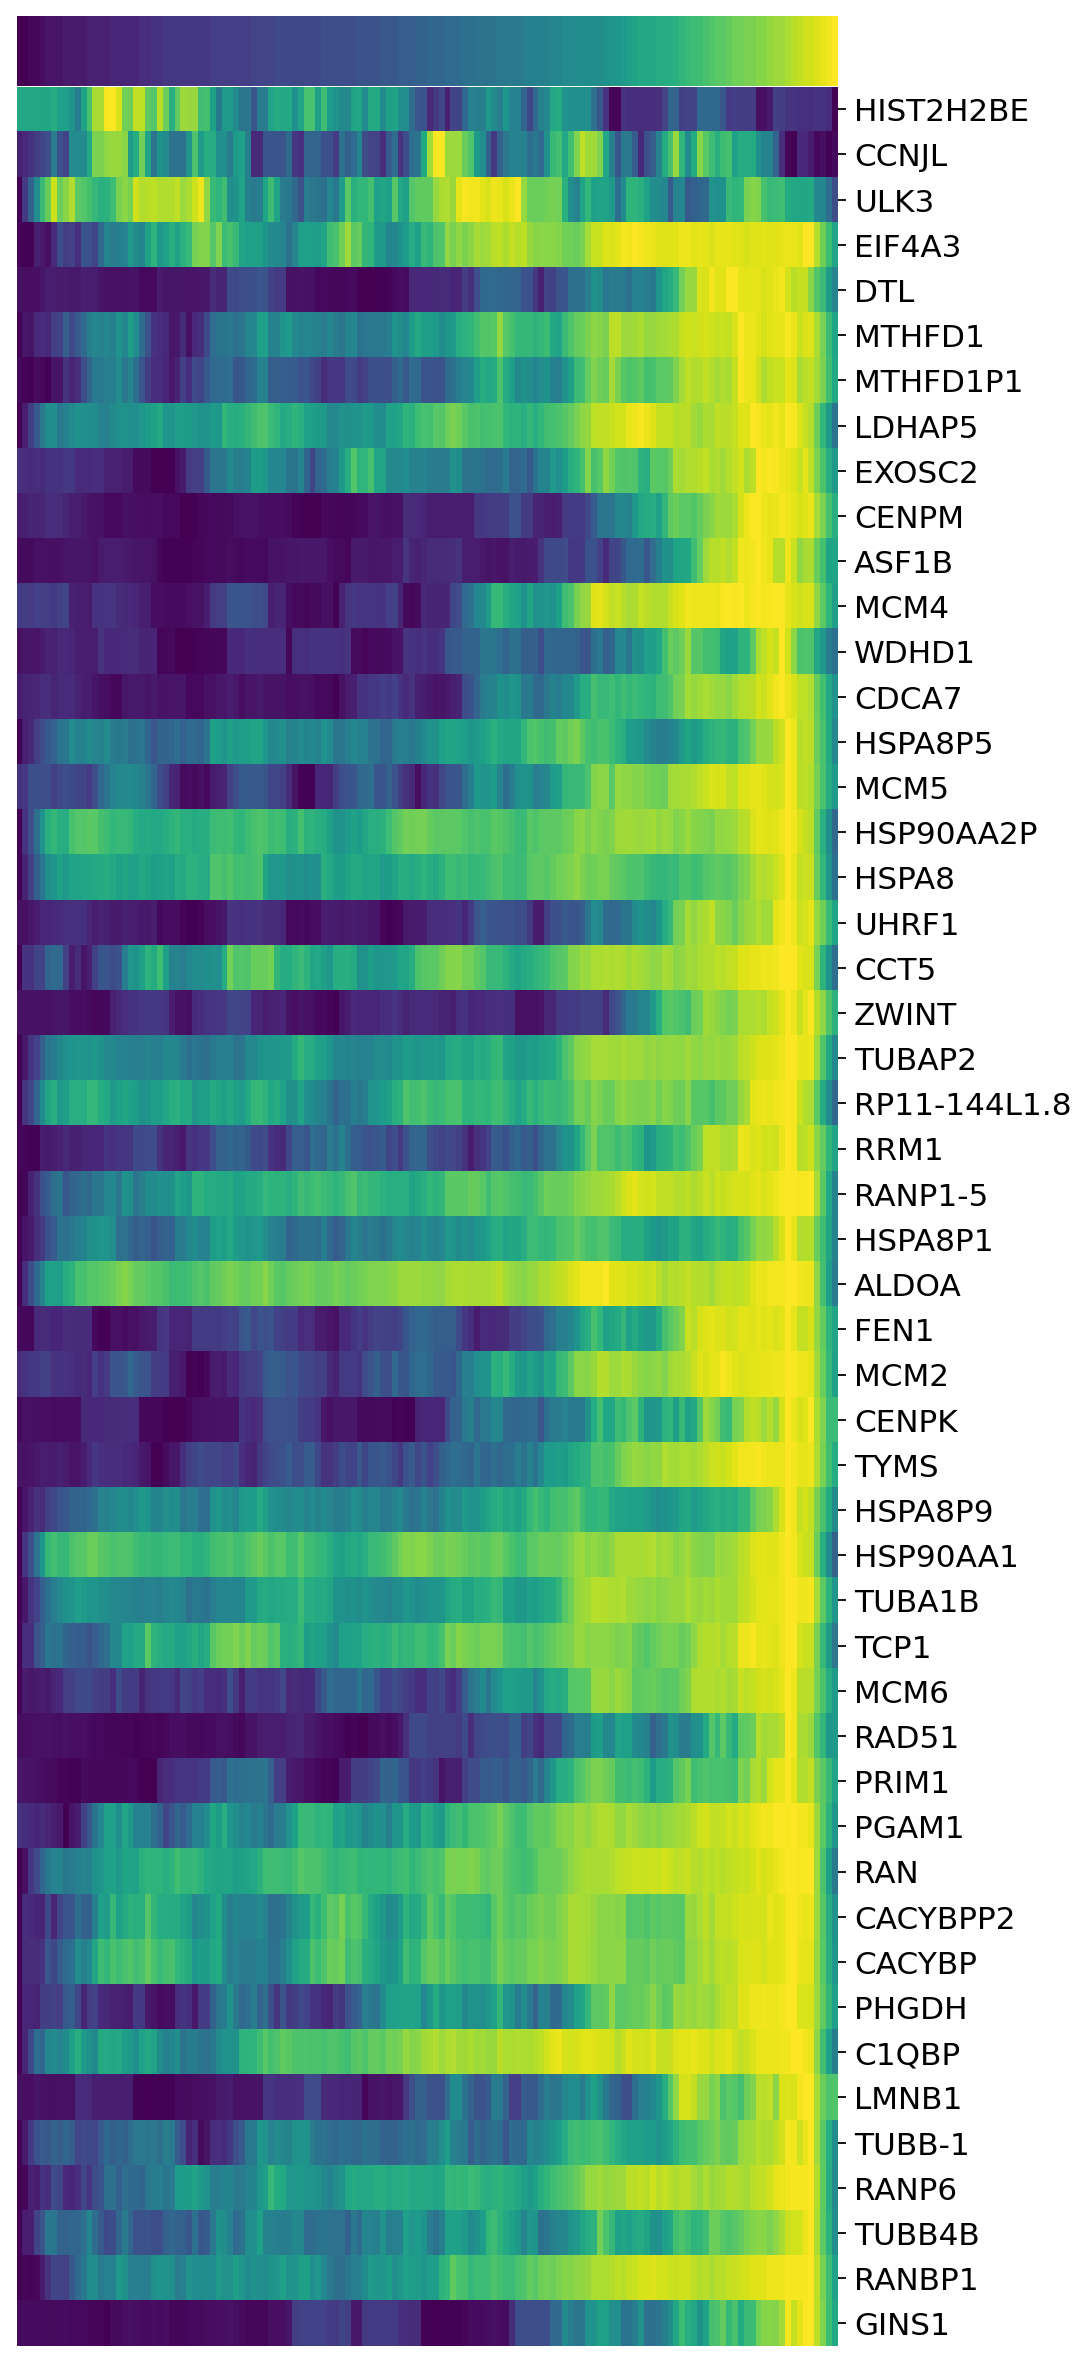

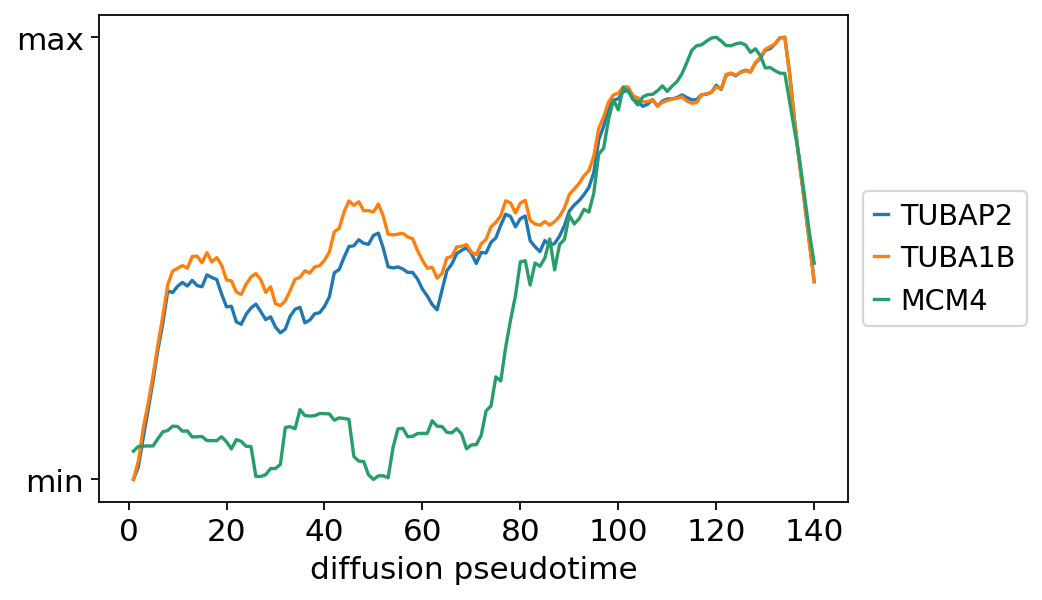

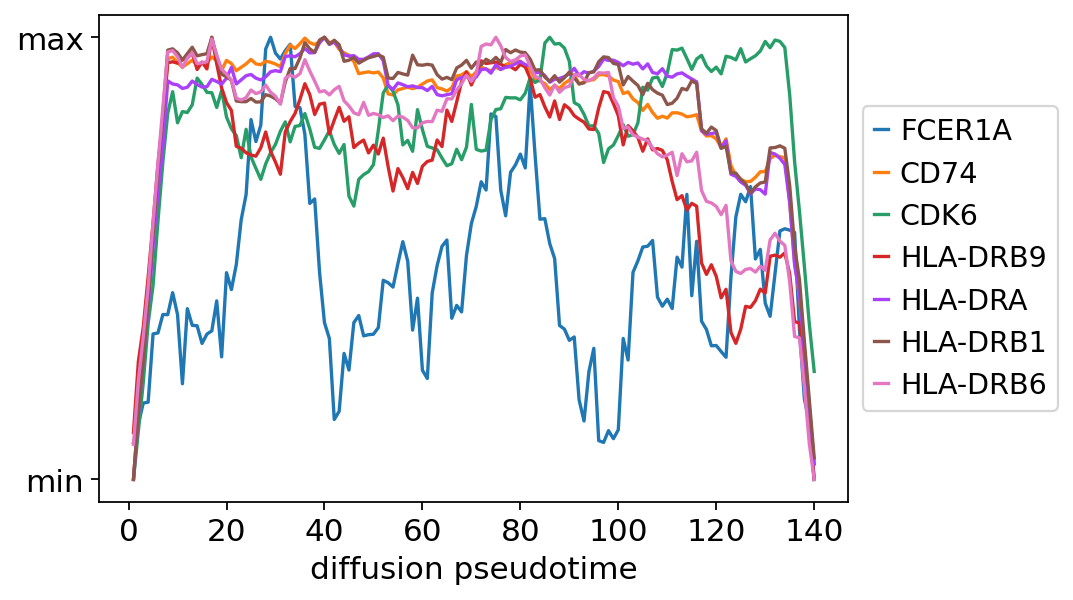

Day3_ST-HSC


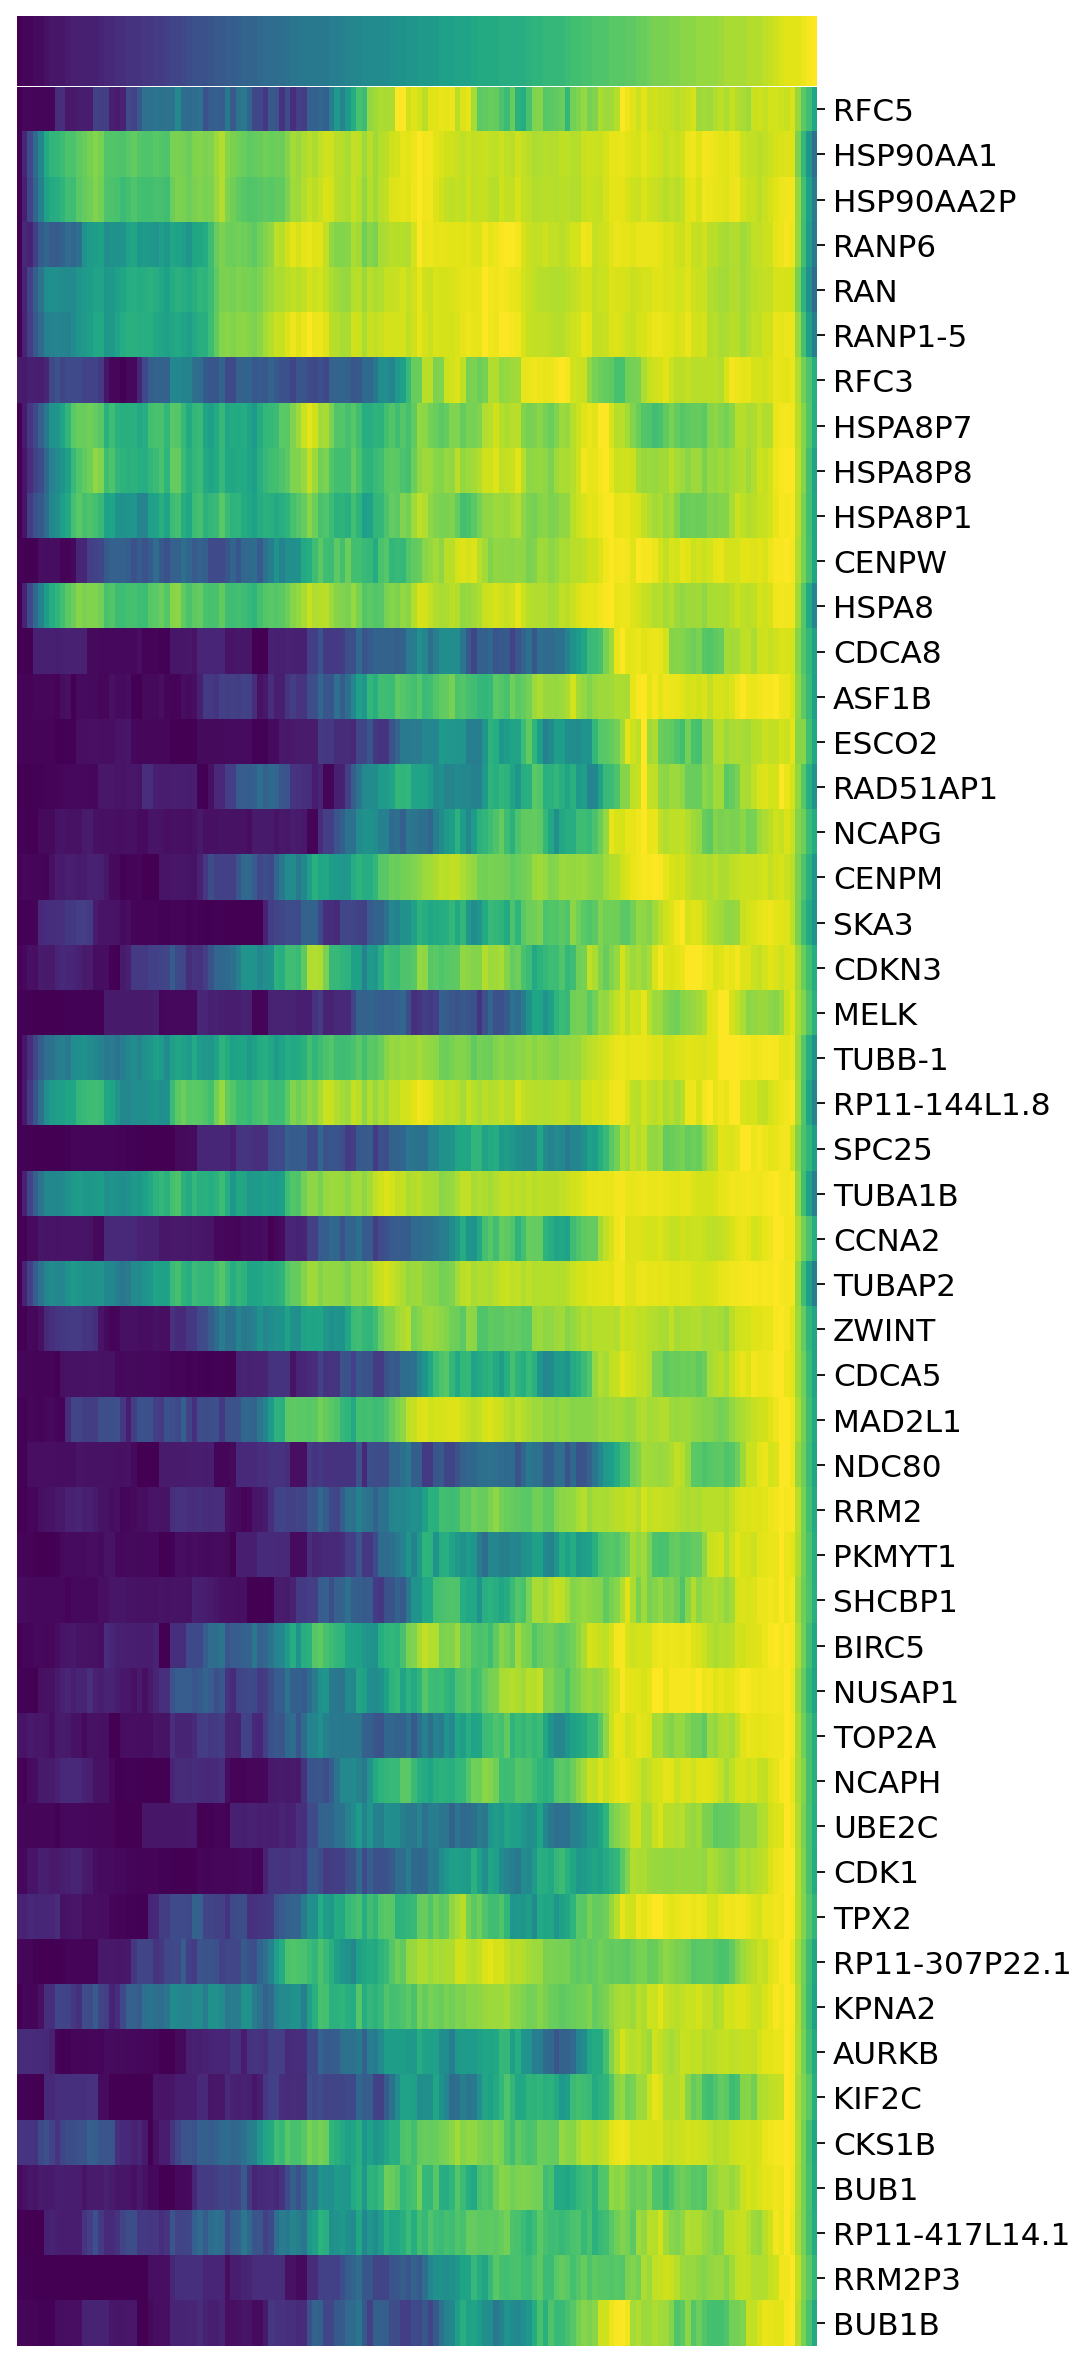

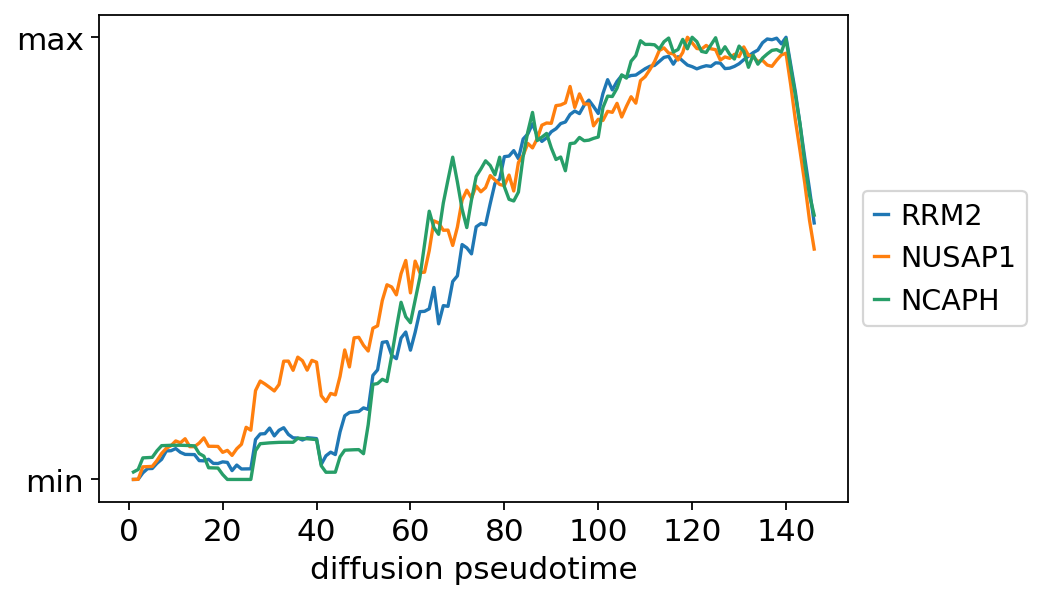

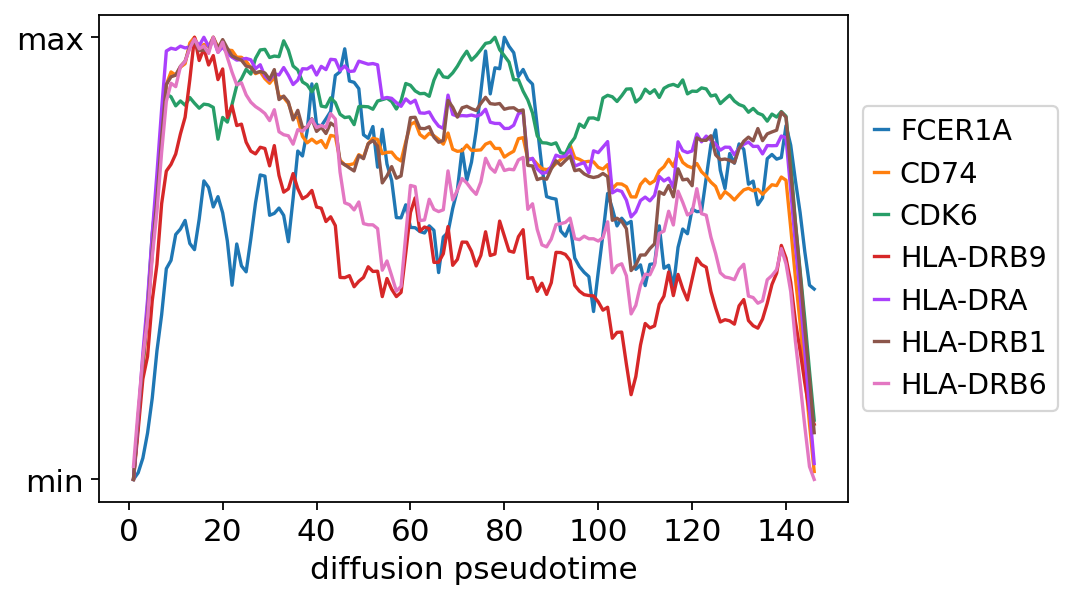

In [37]:
from scipy.stats import rankdata
import scvelo as scv
for cond in BMdata.obs['cond_comb1'].cat.categories:
    print(cond)
    adata_sub = BMdata[BMdata.obs['cond_comb1'] == cond].copy()
    adata_sub = adata_sub[:,adata_sub.uns['varGenes']['genes']['highVar']].copy()
    adata_sub.obs['pt_rank'] = rankdata(adata_sub.obs['destiny_pt_kenny'])
    DEgene_pt = smqpp.GeneExp_LLR_test(adata_sub, alt_obs=['pt_rank', 'n_genes', 'batch'], useHVG=True, null_obs=['n_genes', 'batch'])

    scv.pl.heatmap(adata_sub, var_names=DEgene_pt.index[0:50], tkey='pt_rank', n_convolve=10, col_color='destiny_pt_kenny', figsize=(7,15), yticklabels=True)
    smqpp.plot_genes_along_pt(adata_sub, genes=DEgene_pt.index[0:3], sigma=20, pt_obs='pt_rank')
    GL1 = ['FCER1A', 'CD74', 'CDK6',  
           'HLA-DRB9', 'HLA-DRA', 'HLA-DRB1', 
          'HLA-DRB6']
    smqpp.plot_genes_along_pt(adata_sub, genes=GL1, sigma=20, pt_obs='pt_rank')

### Plot projection

In [37]:
CB_raw.obsm['X_diffmap'] = np.array(pd.read_csv('X_DM_CB.csv', index_col=0, header=0))
MPB_raw.obsm['X_diffmap'] = np.array(pd.read_csv('X_DM_MPB.csv', index_col=0, header=0))
BM_raw.obsm['X_diffmap'] = np.array(pd.read_csv('X_DM_BM.csv', index_col=0, header=0))

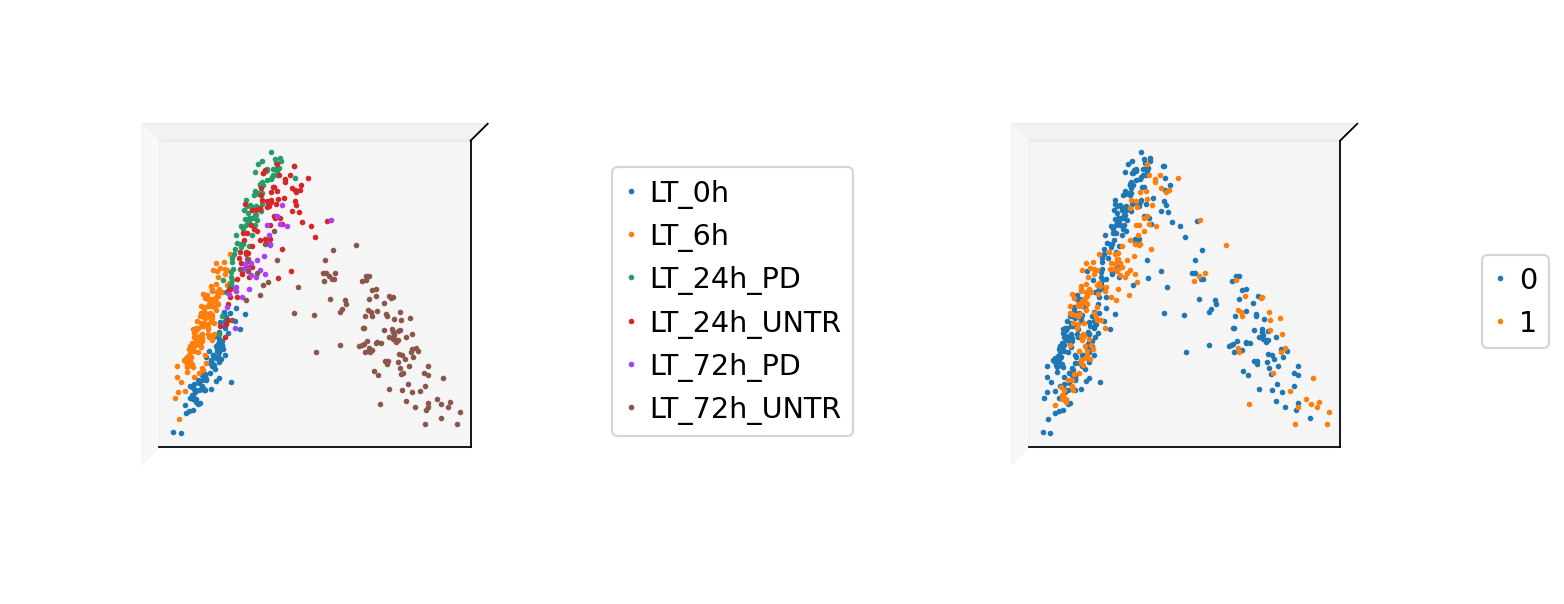

In [105]:
plot_3d(CB_raw, ['Details', 'batch'], figsize=(10,4), azim=270, elev=270, components=[0,1,2], alpha=1, markersize=3) #270,270

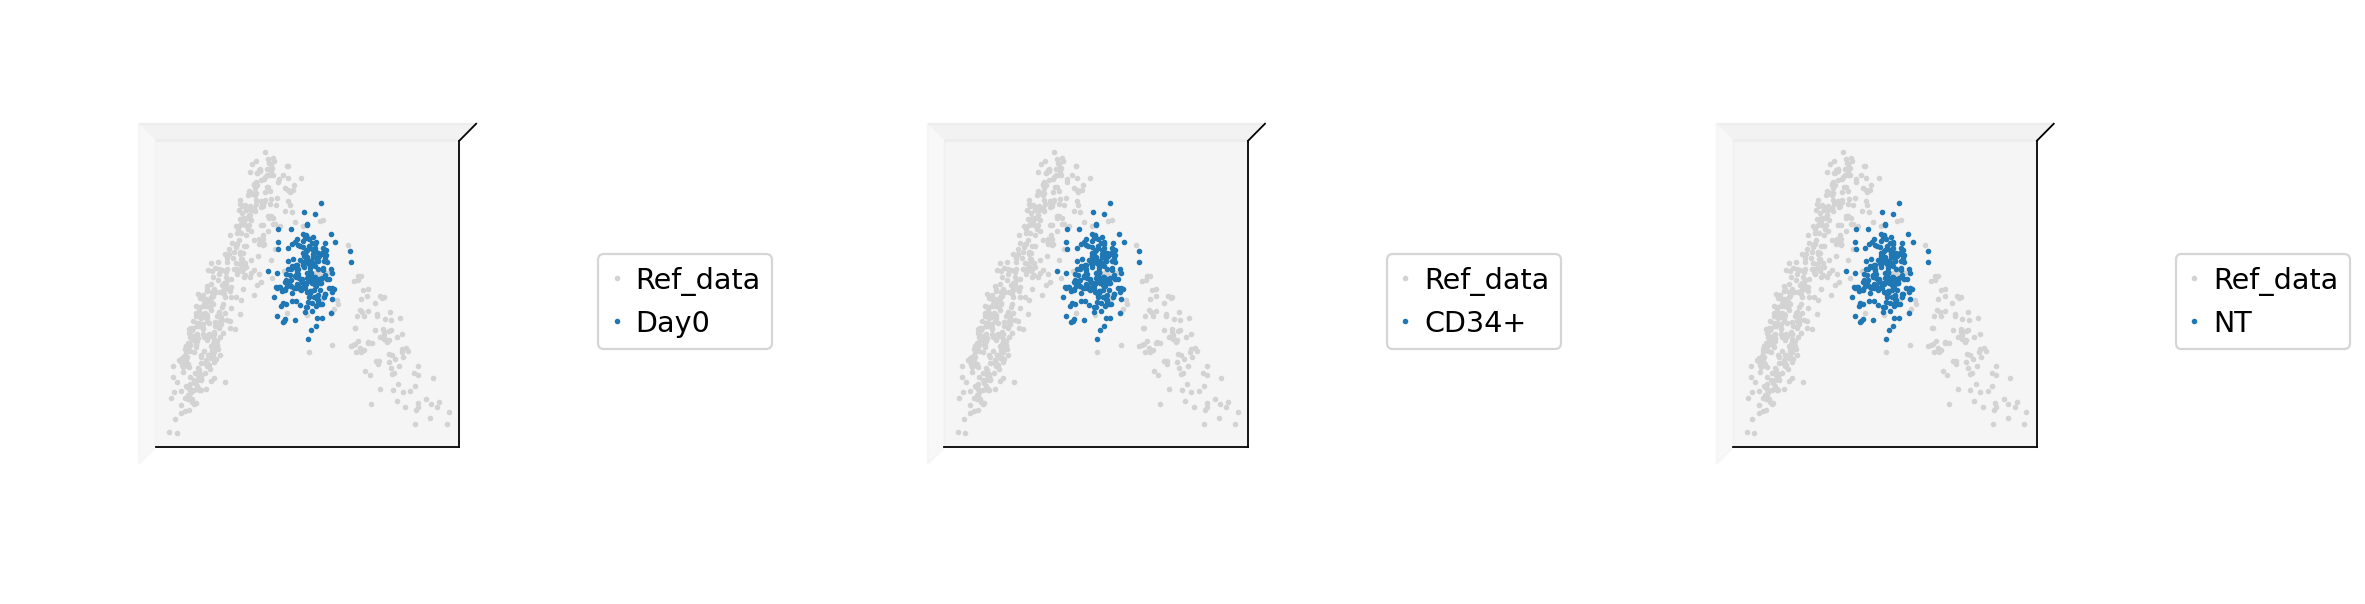

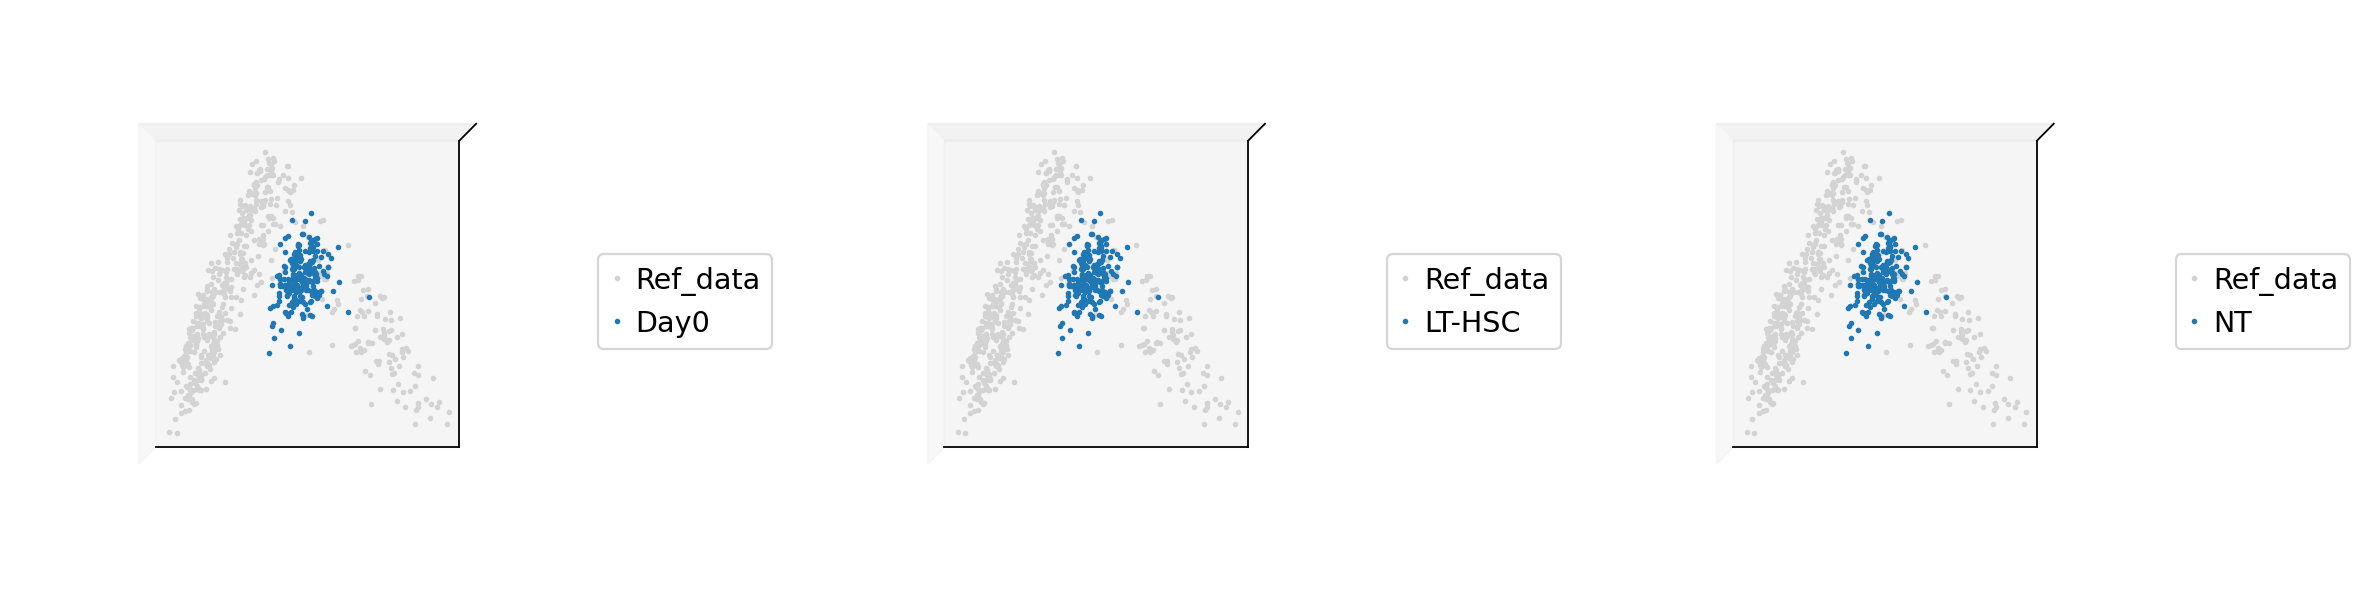

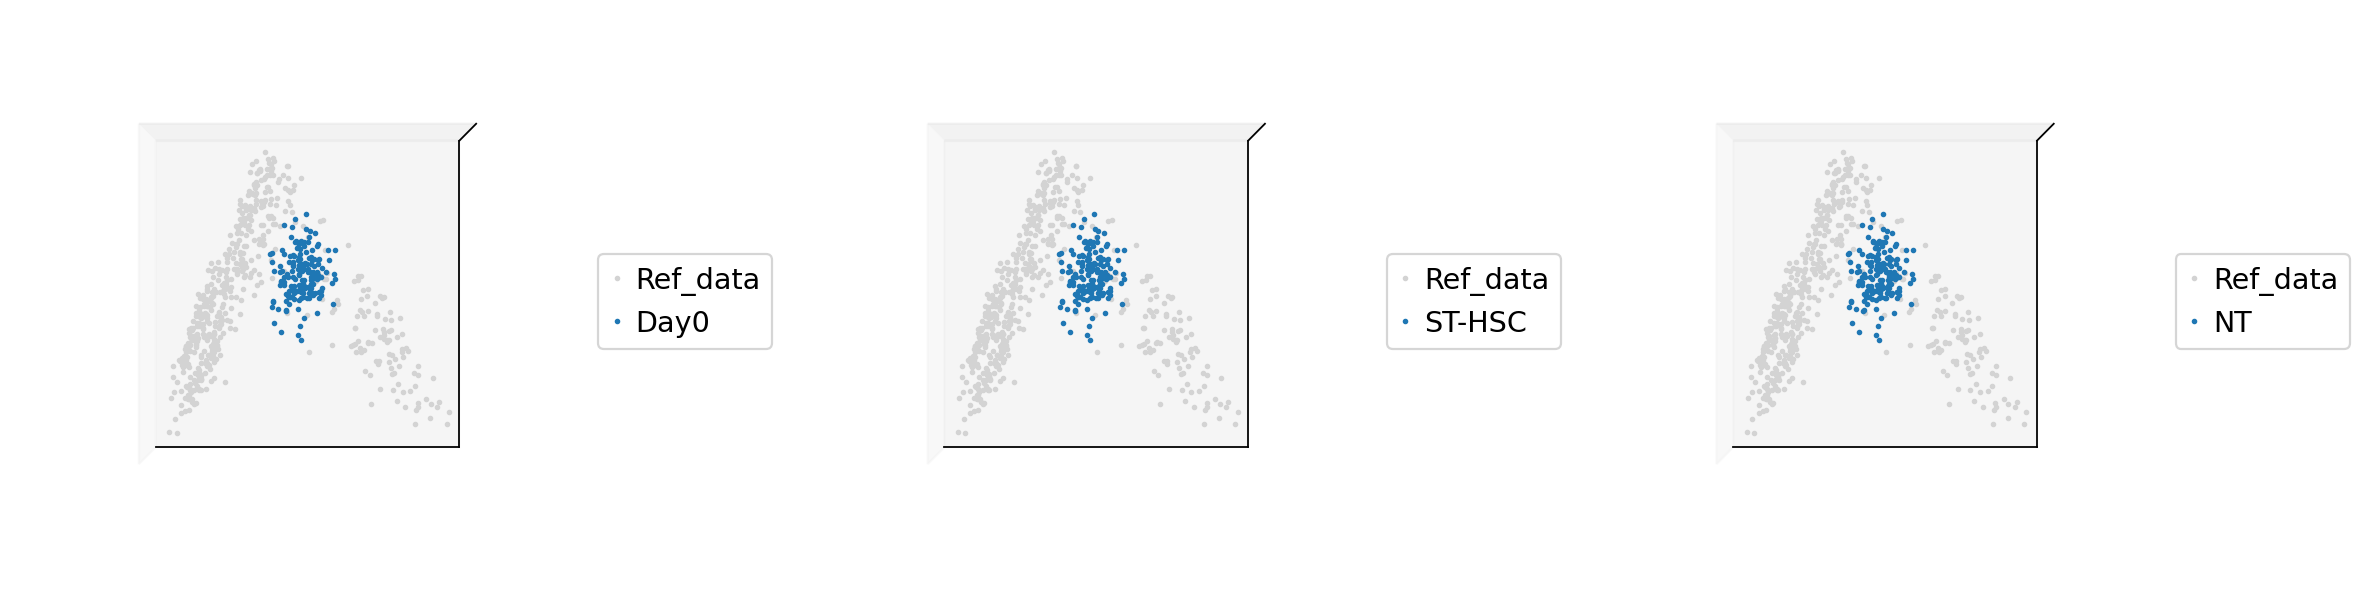

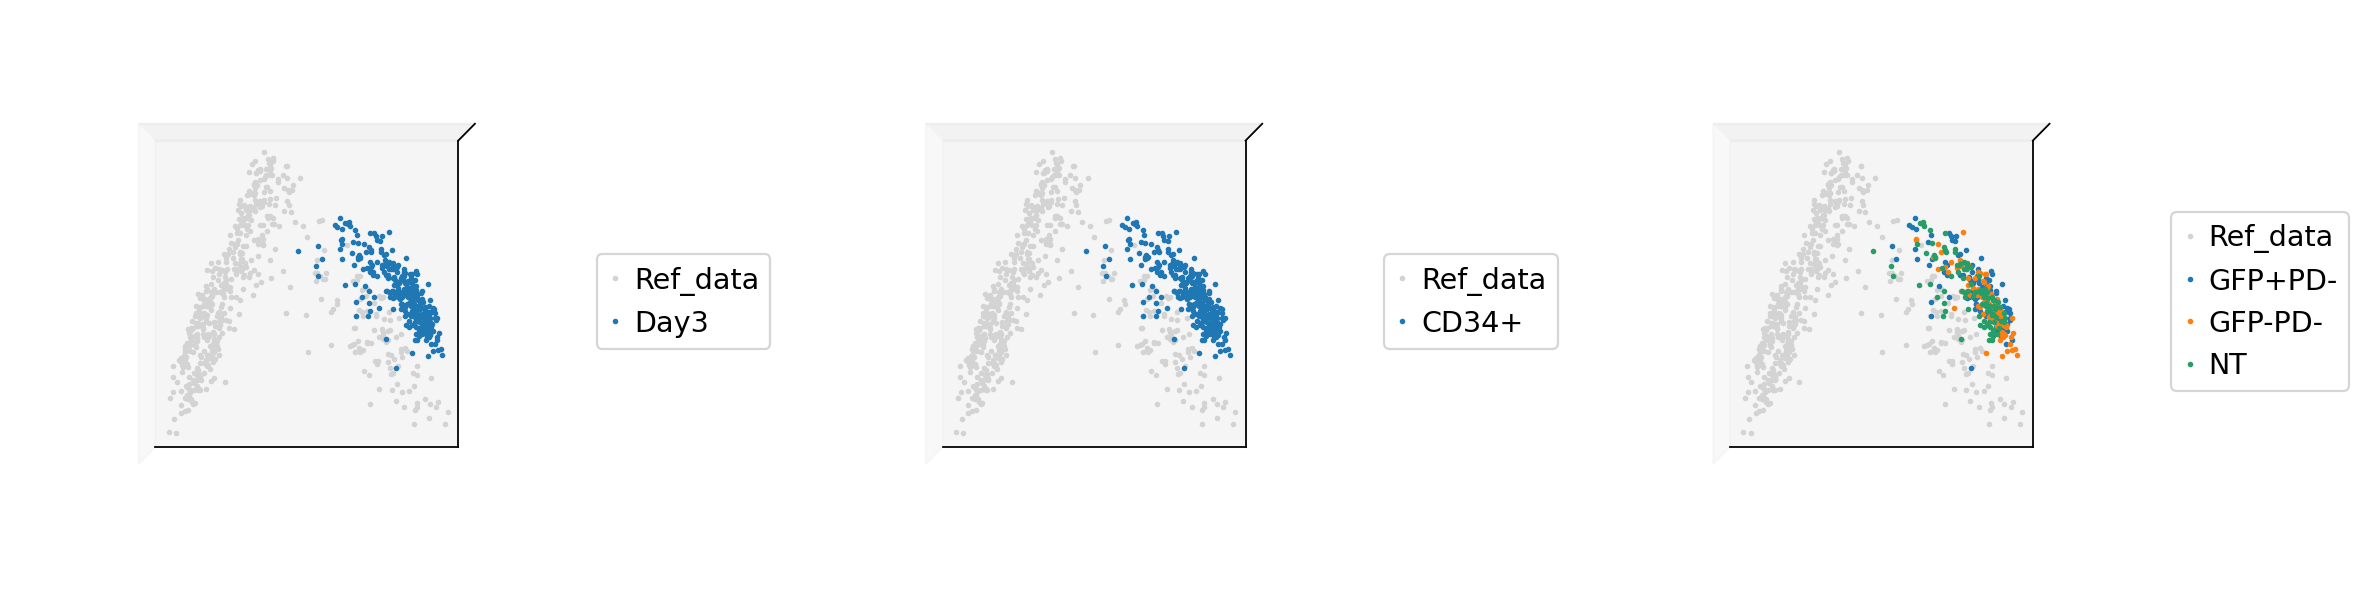

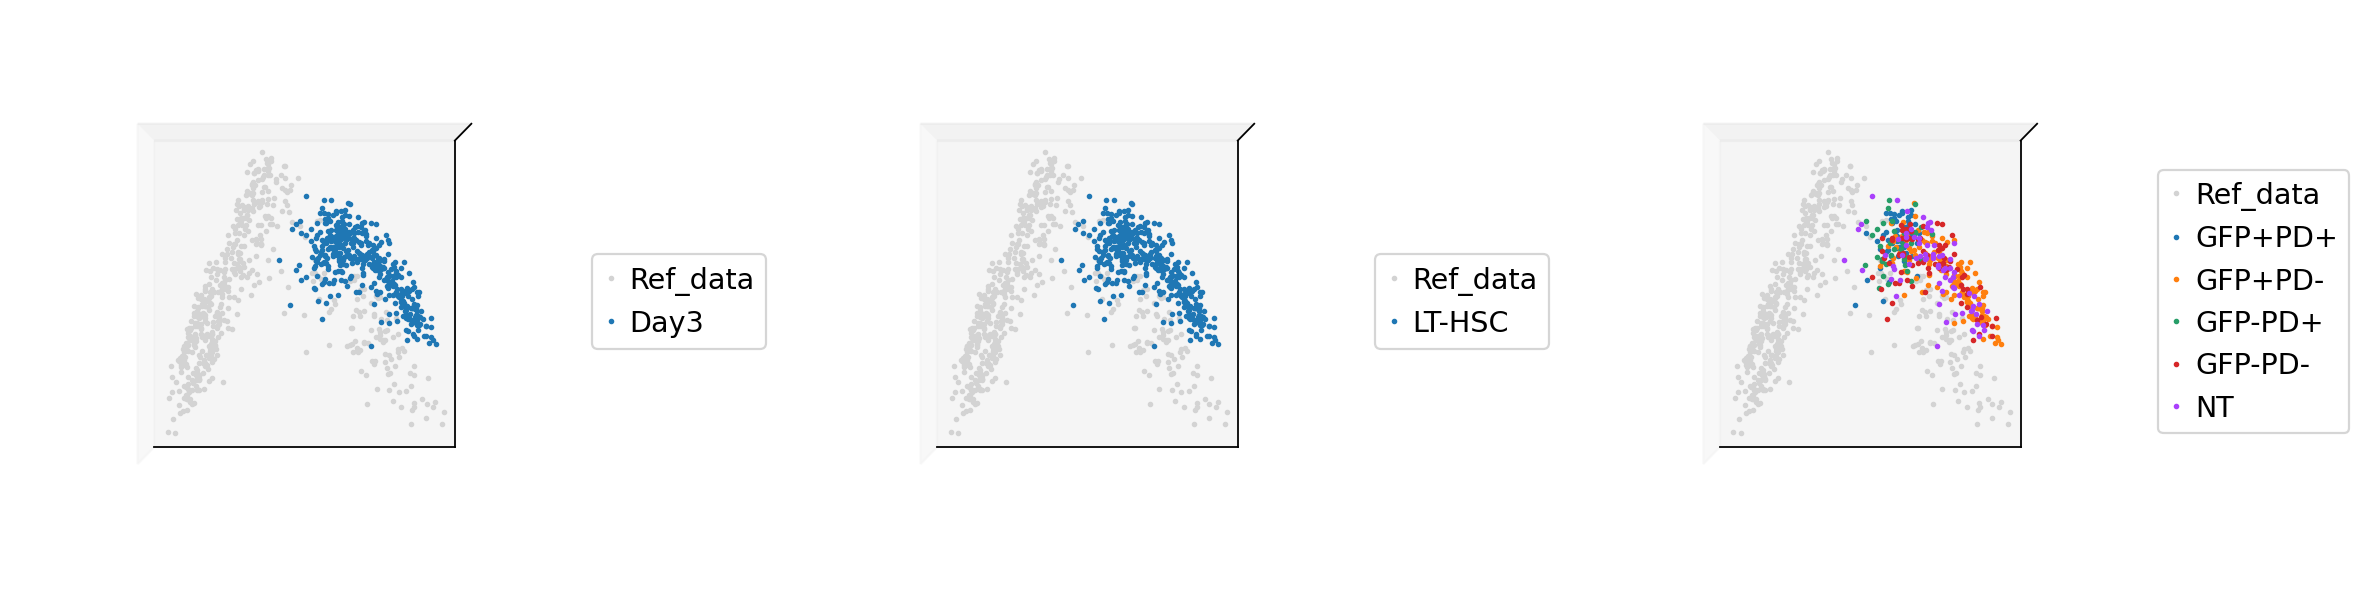

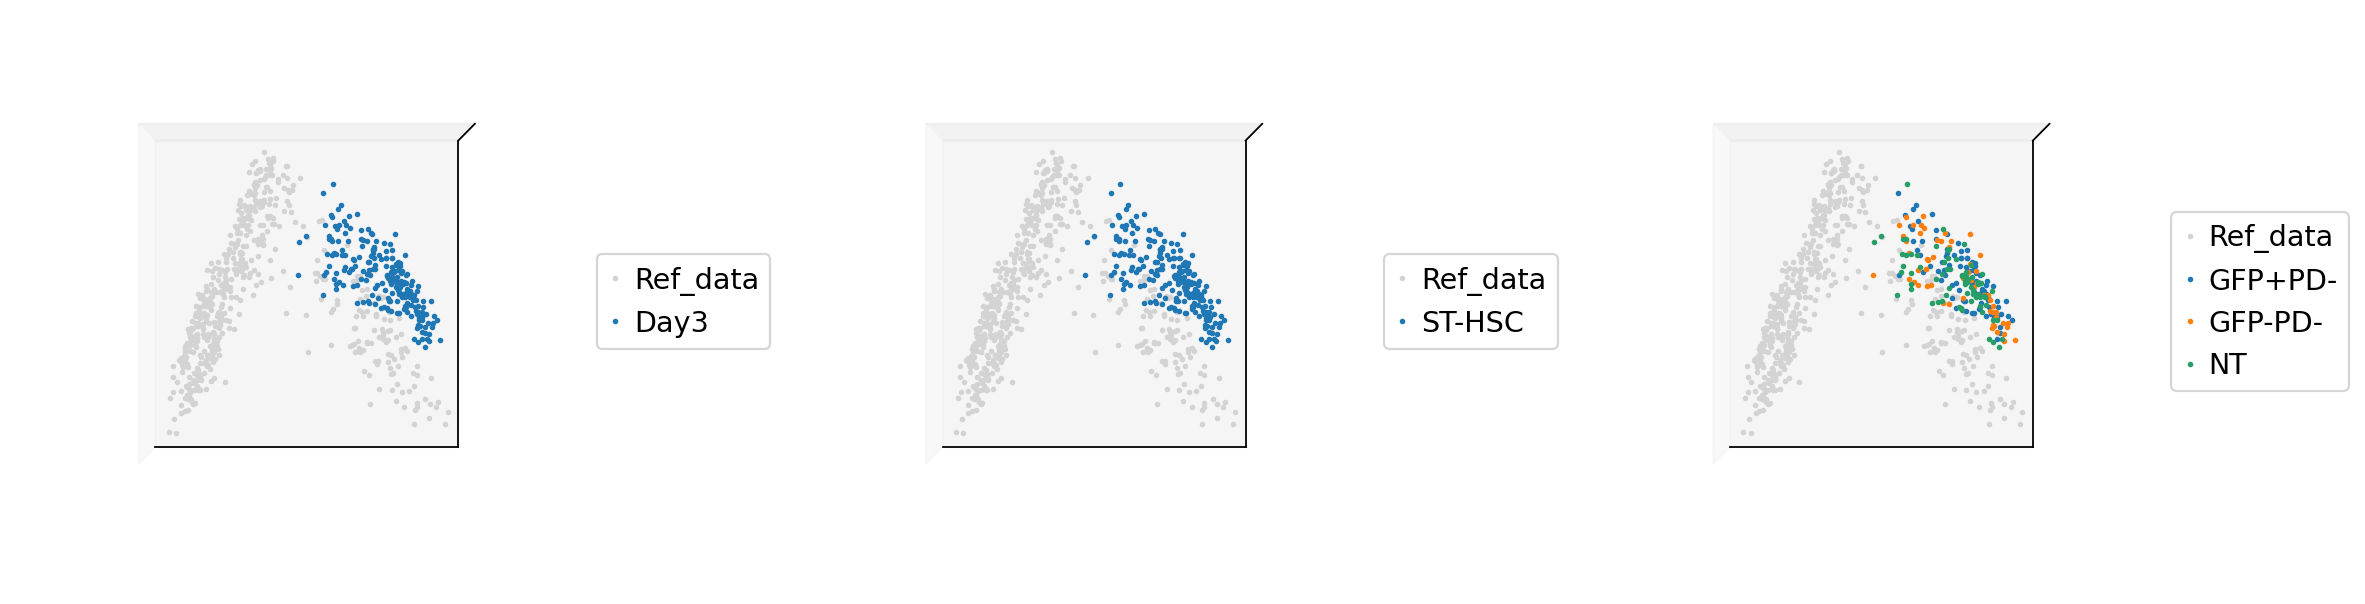

In [107]:
for i in np.unique(MPB_raw.obs['Day']):
    for j in np.unique(MPB_raw.obs['Cell_Type']):
        plot_3d(CB_raw, ['Day', 'Cell_Type', 'Condition'], MPB_raw[((MPB_raw.obs['Day'] == i) & (MPB_raw.obs['Cell_Type'] == j))], figsize=(15,4), azim=270,elev=270, components=[0,1,2], alpha=1, markersize=3)

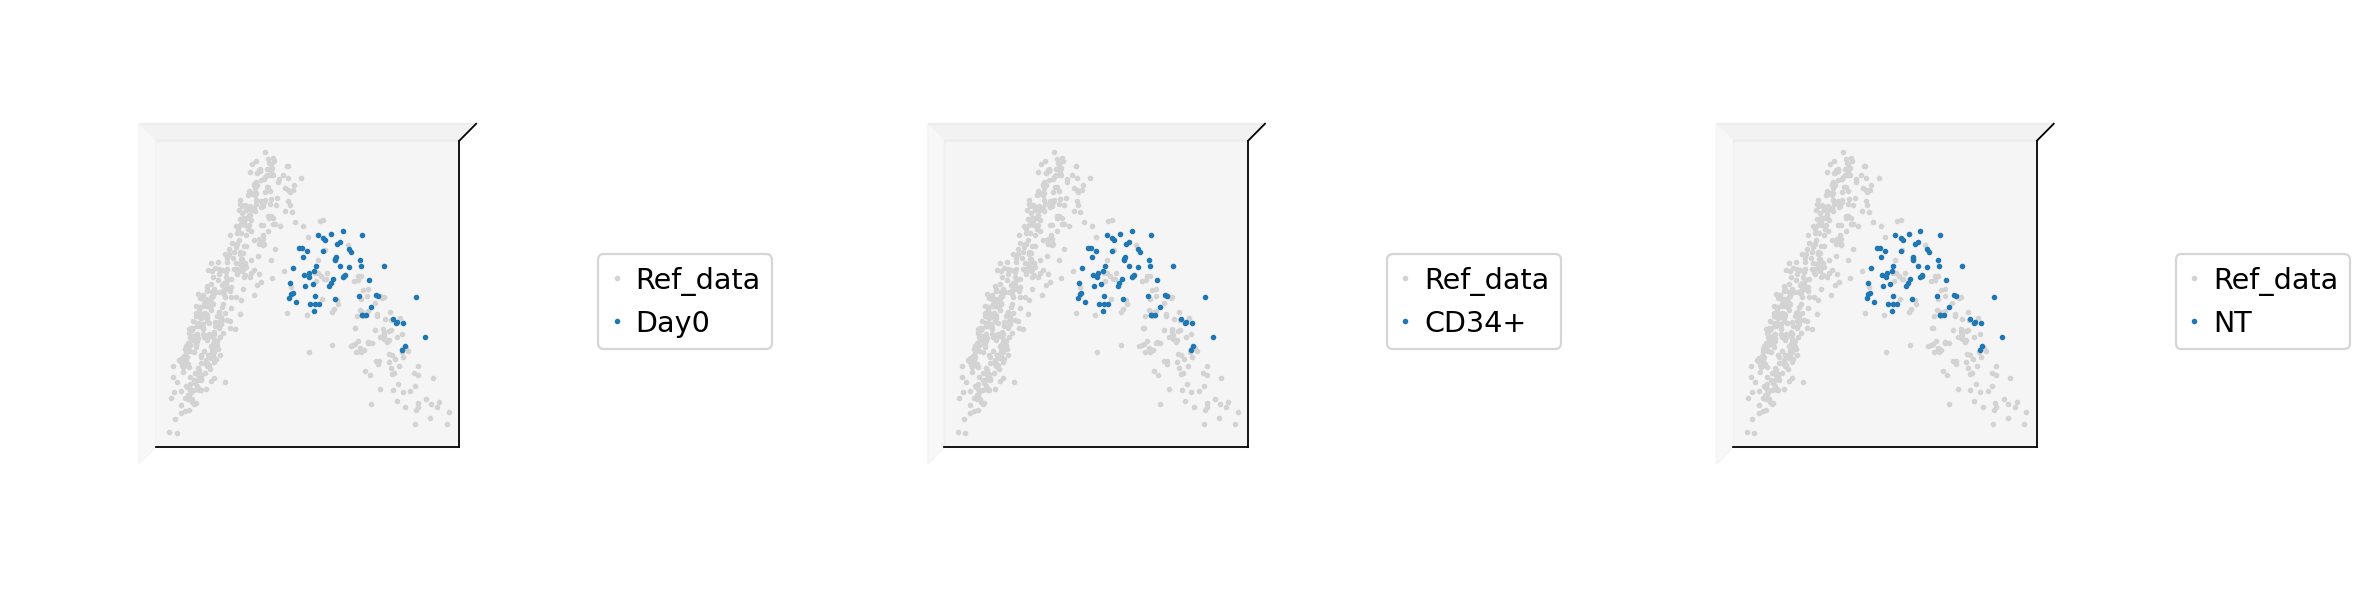

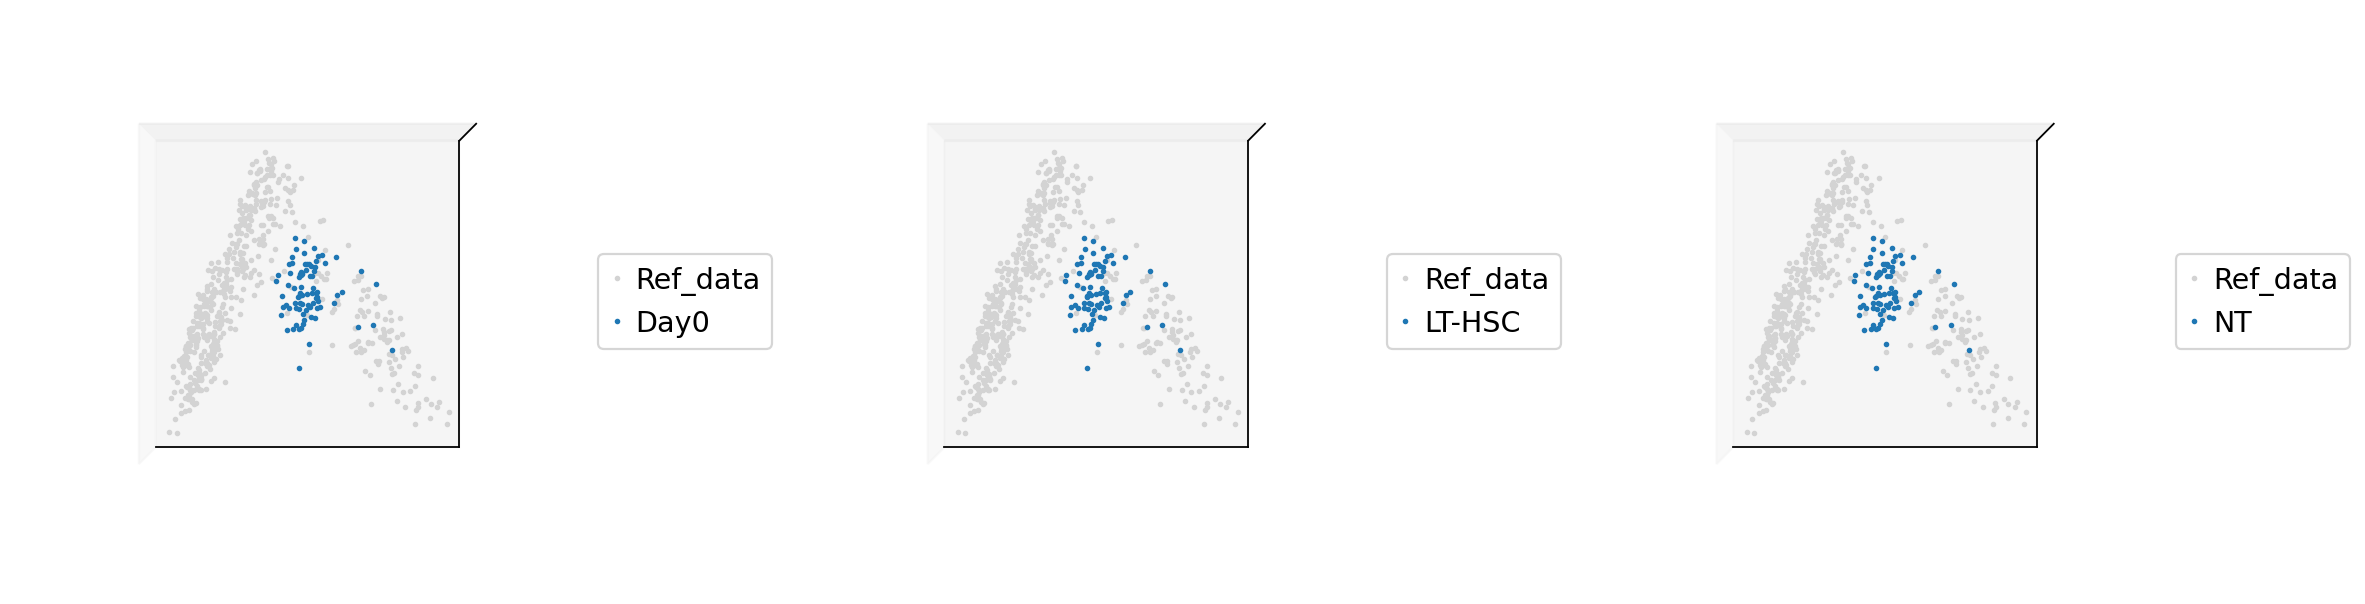

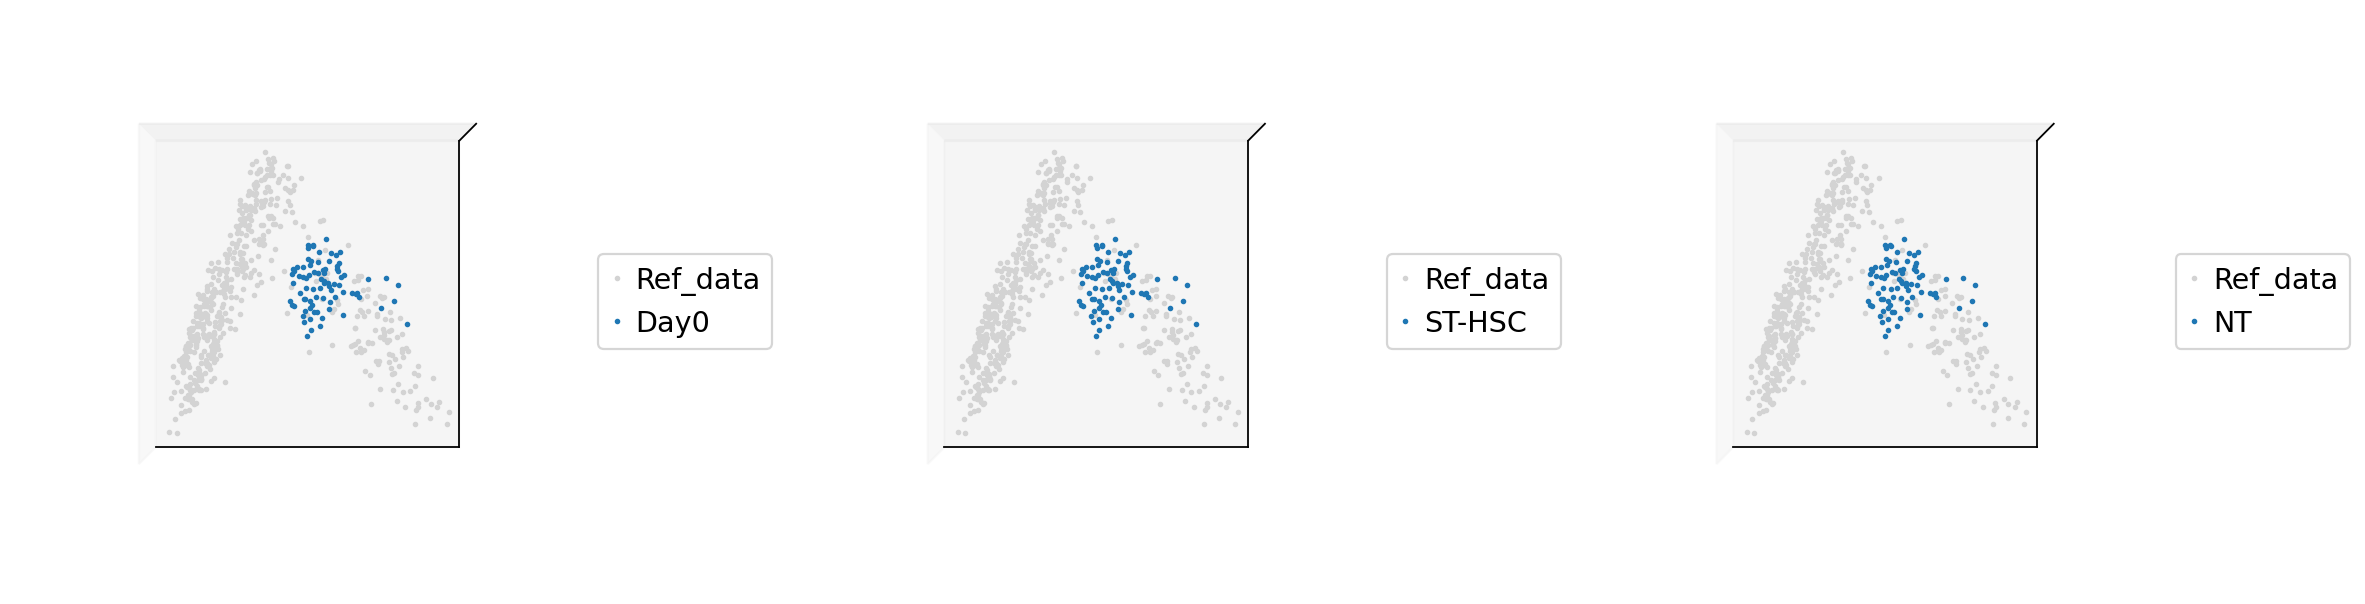

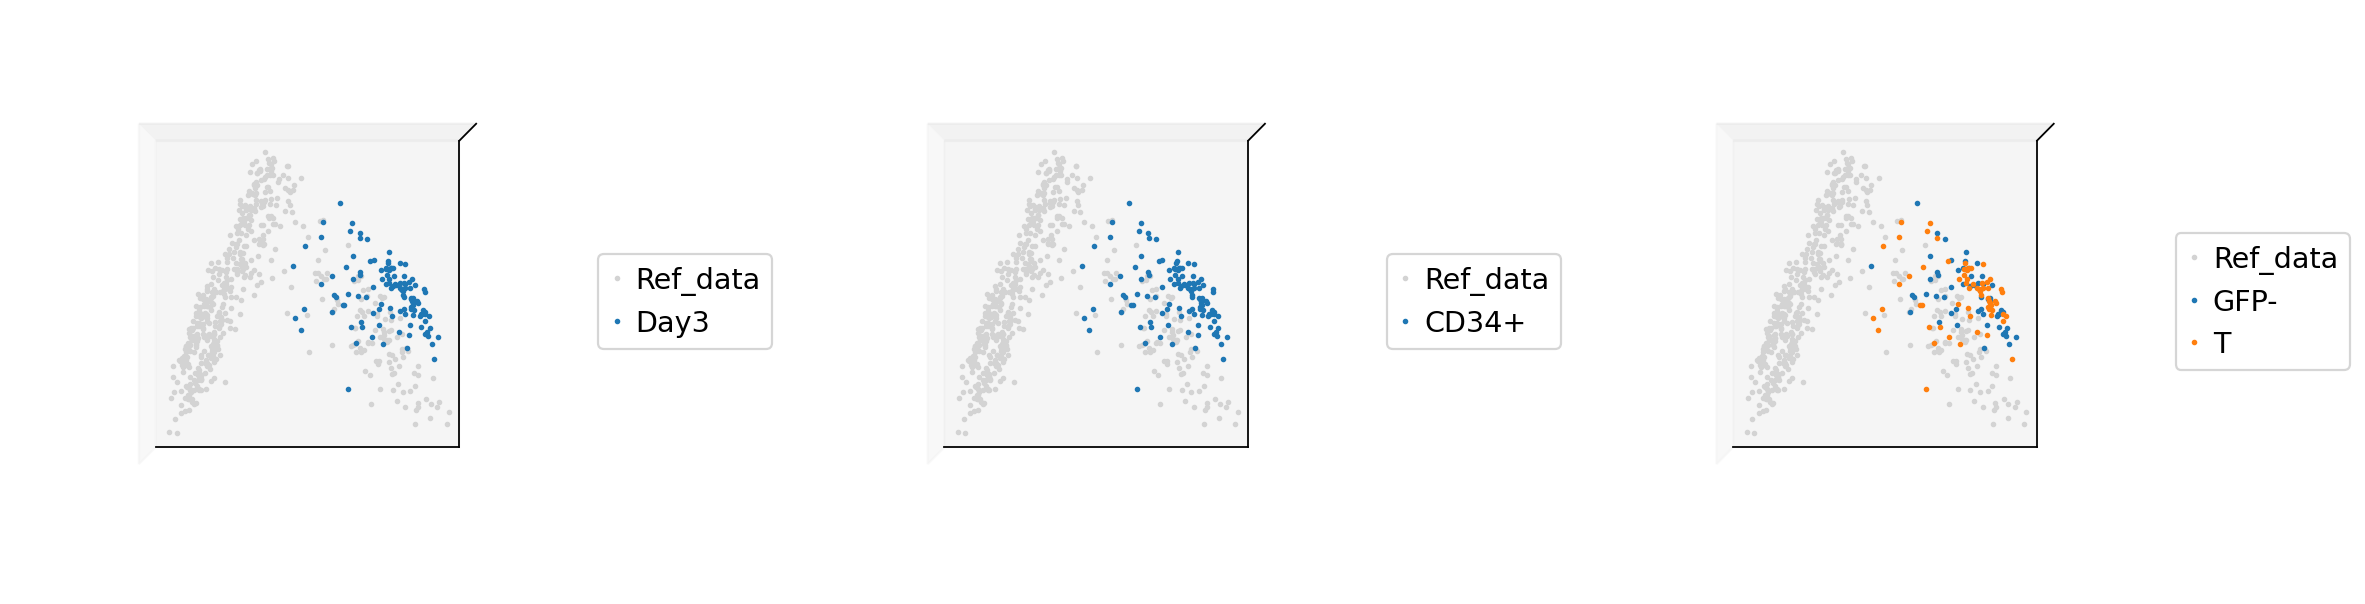

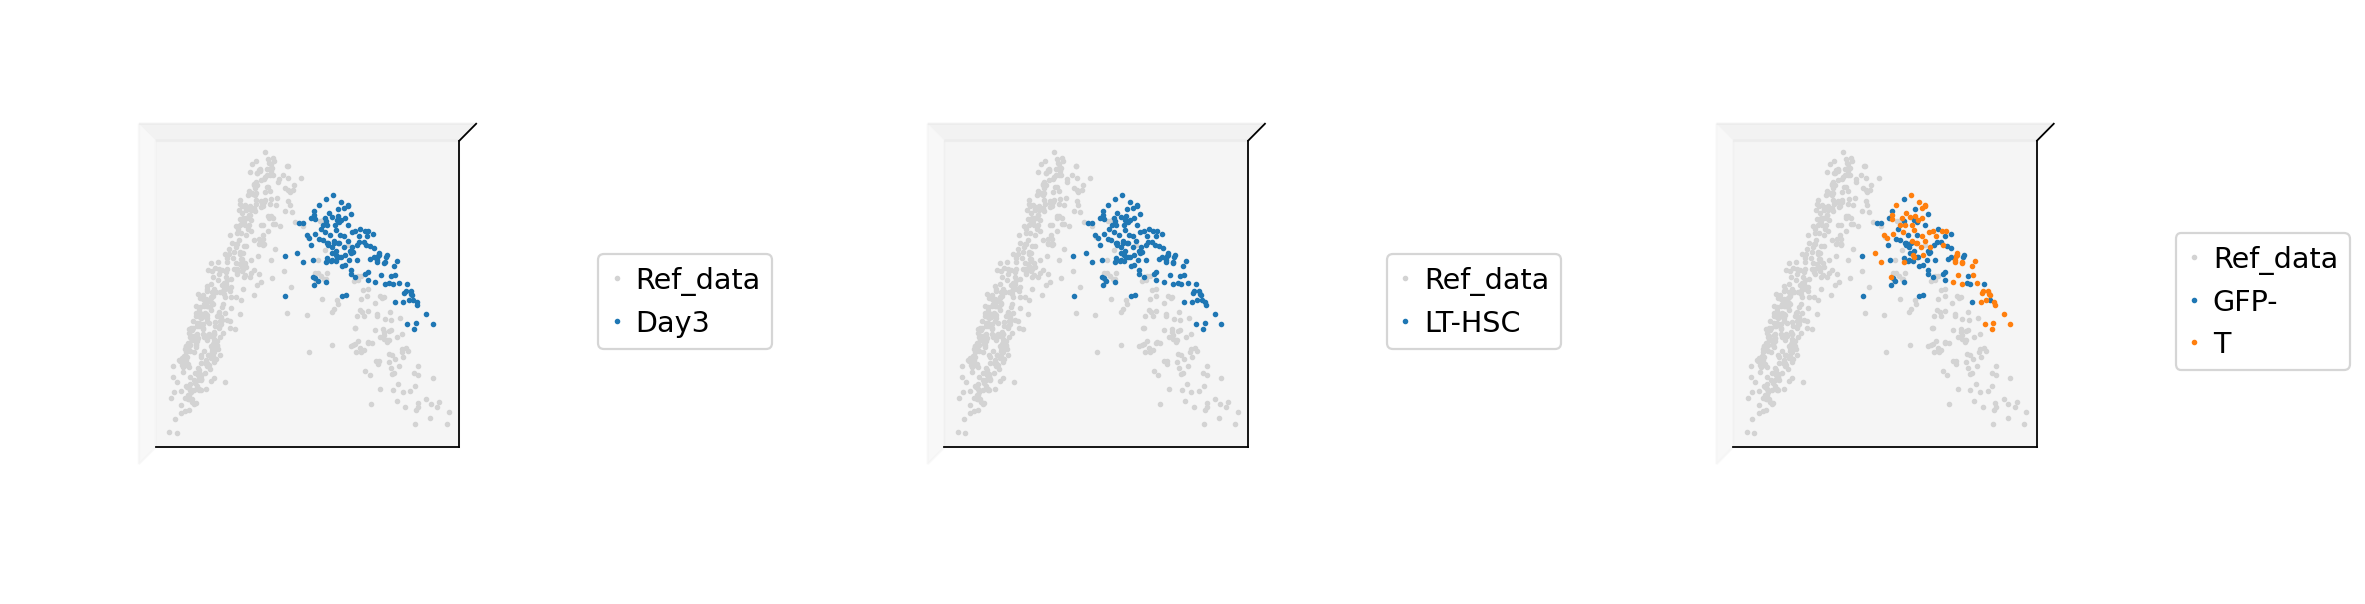

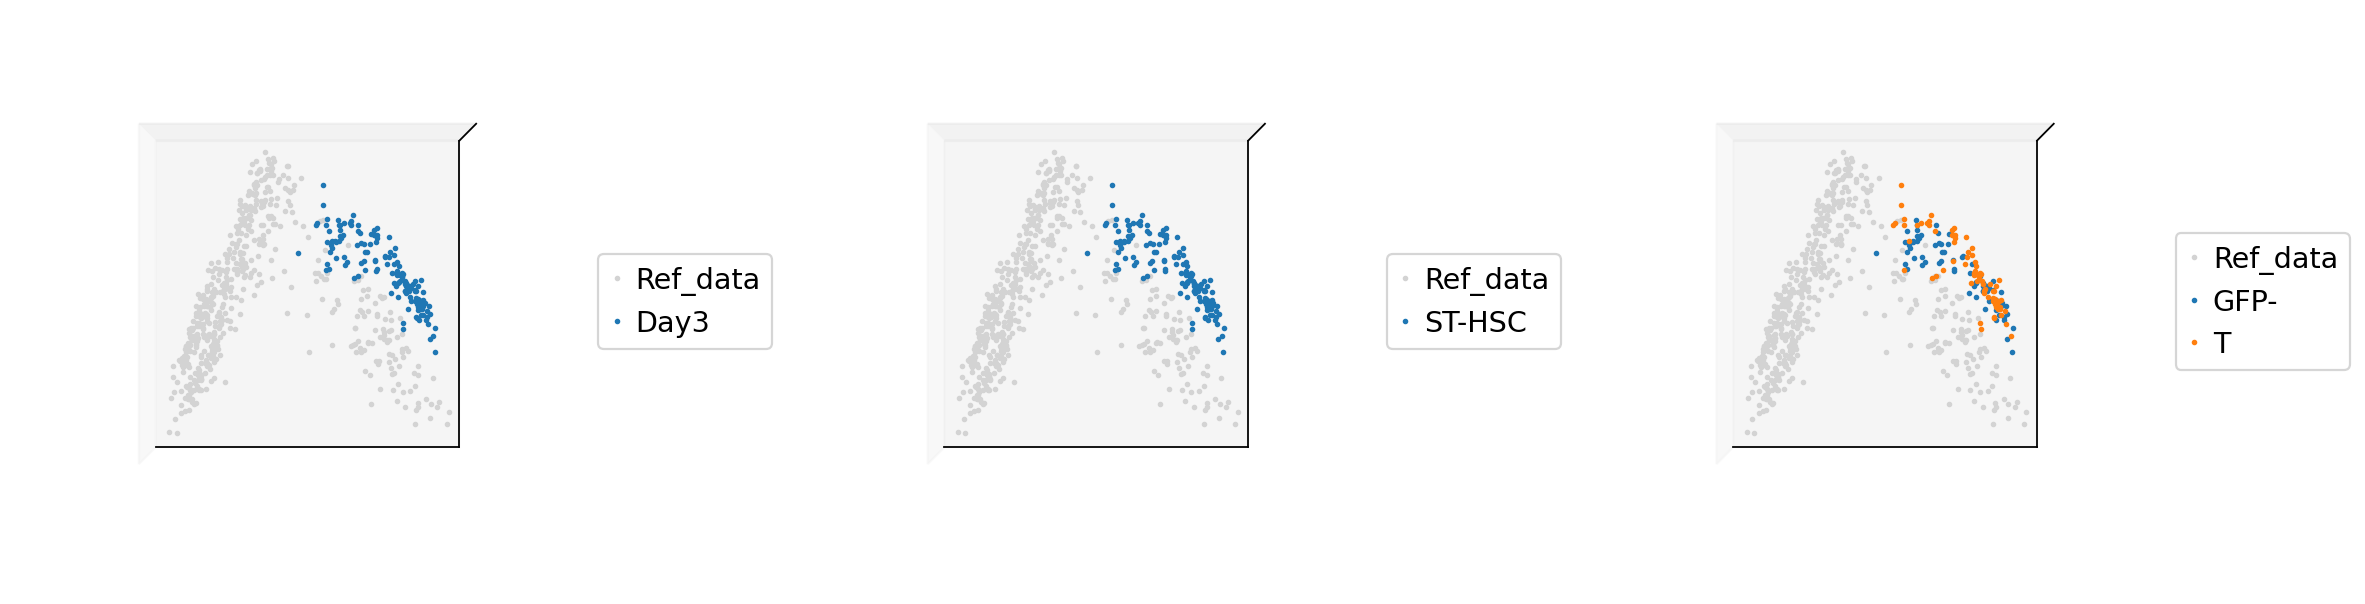

In [109]:
for i in np.unique(BM_raw.obs['Day']):
    for j in np.unique(BM_raw.obs['Cell_Type']):
        plot_3d(CB_raw, ['Day', 'Cell_Type', 'Condition'], BM_raw[((BM_raw.obs['Day'] == i) & (BM_raw.obs['Cell_Type'] == j))], figsize=(15,4), azim=270,elev=270, components=[0,1,2], alpha=1,markersize=3)